In [1]:
import numpy as np
import pickle  # 用 pickle 替代 cPickle
import gym
np.bool8 = np.bool_

In [2]:
import gym

In [3]:
env = gym.make("Pong-v4")
observation, _ = env.reset()

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [4]:
def show_img(observation):
    import numpy as np
    import matplotlib.pyplot as plt

    # 创建一个随机的 (210, 160, 3) 矩阵
    image = observation
    # image = prepro_1(observation)

    # 使用 matplotlib 显示图像
    plt.imshow(image)
    # plt.axis('off')  # 隐藏坐标轴
    plt.show()

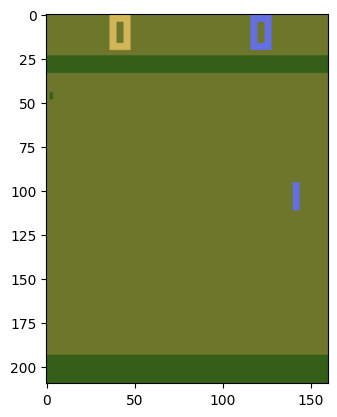

In [5]:
show_img(observation)

In [6]:
def prepro(I):
    """将 210x160x3 uint8 帧预处理为 6400 (80x80) 1D float 向量"""
    I = I[35:195]  # 裁剪
    I = I[::2, ::2, 0]  # 下采样因子为 2
    I[I == 144] = 0  # 删除背景类型 1
    I[I == 109] = 0  # 删除背景类型 2
    I[I != 0] = 1  # 其他设置为 1
    return I.astype(np.float32).ravel()

In [7]:
D = 6400
H = 200

In [8]:
from torch import nn

In [9]:
class MLP(nn.Module):
    
    
    def __init__(self, input_dim,output_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim,200,bias=False)
        self.linear2 = nn.Linear(200,output_dim,bias=False)
        
       # Xavier 初始化 + 偏置归零
        nn.init.xavier_normal_(self.linear1.weight)
        nn.init.xavier_normal_(self.linear2.weight)

        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self,x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return self.sigmoid(x)
    
    def sample_action(self,x):
        with torch.no_grad():
            prob = self.forward(x)
#             prob = torch.clamp(prob, min=1e-8, max=1-1e-8)  # 关键修复

#             m = Bernoulli(prob)
#             action = m.sample().item()  # 1 表示向上，0 表示向下
#             return int(action) + 2
        action = 2 if prob.item() < np.random.uniform() else 3
        return action

In [10]:
def discount_rewards(rewards):
    ans = np.zeros_like(rewards)
    adding = 0
    for t in reversed(range(len(rewards))):
        if rewards[t] != 0:
            adding = 0
        adding = adding * 0.99 + rewards[t]
        ans[t] = adding
    return ans

In [24]:
model = MLP(D,1)

In [25]:
from torch.optim import RMSprop
import torch

In [26]:
optimizer = RMSprop(model.parameters(), lr=0.001, alpha=0.99, eps=1e-5)

In [27]:
from torch.distributions import Bernoulli

observation, _ = env.reset()
episode_number = 0
prev_x = None
xs = []
logps = []
hs = []
ys = []
rewards = []
train_time = 0
total_sum = 0
while True:
    current_x = prepro(observation)
    gap = np.zeros_like(current_x) if prev_x is None else current_x - prev_x
#     h,p = policy_forward(gap)
    action = model.sample_action(torch.from_numpy(gap))
#     print(action)
    y = 0.0 if action == 2 else 1.0
    observation, reward, terminated, truncated, info = env.step(action)  # 更新为新的返回值
    prev_x = current_x
    rewards.append(reward)
    xs.append(gap)
    ys.append(y)
    total_sum += reward
    
    if terminated or truncated:
        episode_number += 1
        xs = np.vstack(xs)
        ys = np.vstack(ys).ravel()
        rewards = np.vstack(rewards).ravel()
        rewards = discount_rewards(rewards)
        rewards -= rewards.mean()
        rewards /= (rewards.std())

        rewards = torch.FloatTensor(rewards)
        xs = torch.FloatTensor(xs)
        ys = torch.FloatTensor(ys)
        
        ps = model(xs)
        ps = model(xs).squeeze()
#         print(ps.shape,ys.shape)

        # 防止概率为0或1导致log计算爆炸
        logps = torch.log(ys * ps + (1.0-ys) *(1.0-ps))
#         print(logps)
     
        loss = -(logps * rewards).mean()
        print((logps * rewards).sum())
#         print('loss',loss,len(rewards),sum(rewards),sum(logps))
        
        #### 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('total',total_sum,loss,(logps * rewards).sum(),len(rewards))
        
        xs = []
        rewards = []
        logps = []
        hs = []
        ys = []
        prev_x = None
        total_sum = 0
        observation, _ = env.reset()
        
        

tensor(-4.3607, grad_fn=<SumBackward0>)
total -20.0 tensor(0.0033, grad_fn=<NegBackward0>) tensor(-4.3607, grad_fn=<SumBackward0>) 1324
tensor(-0.8835, grad_fn=<SumBackward0>)
total -21.0 tensor(0.0008, grad_fn=<NegBackward0>) tensor(-0.8835, grad_fn=<SumBackward0>) 1112
tensor(6.8353, grad_fn=<SumBackward0>)
total -21.0 tensor(-0.0045, grad_fn=<NegBackward0>) tensor(6.8353, grad_fn=<SumBackward0>) 1504
tensor(-14.6706, grad_fn=<SumBackward0>)
total -20.0 tensor(0.0111, grad_fn=<NegBackward0>) tensor(-14.6706, grad_fn=<SumBackward0>) 1316
tensor(-2.6490, grad_fn=<SumBackward0>)
total -21.0 tensor(0.0019, grad_fn=<NegBackward0>) tensor(-2.6490, grad_fn=<SumBackward0>) 1419
tensor(-9.6086, grad_fn=<SumBackward0>)
total -20.0 tensor(0.0059, grad_fn=<NegBackward0>) tensor(-9.6086, grad_fn=<SumBackward0>) 1631
tensor(1.5375, grad_fn=<SumBackward0>)
total -20.0 tensor(-0.0011, grad_fn=<NegBackward0>) tensor(1.5375, grad_fn=<SumBackward0>) 1385
tensor(4.3027, grad_fn=<SumBackward0>)
total -21

tensor(50.9612, grad_fn=<SumBackward0>)
total -21.0 tensor(-0.0290, grad_fn=<NegBackward0>) tensor(50.9612, grad_fn=<SumBackward0>) 1757
tensor(23.2940, grad_fn=<SumBackward0>)
total -21.0 tensor(-0.0140, grad_fn=<NegBackward0>) tensor(23.2940, grad_fn=<SumBackward0>) 1659
tensor(20.8318, grad_fn=<SumBackward0>)
total -20.0 tensor(-0.0132, grad_fn=<NegBackward0>) tensor(20.8318, grad_fn=<SumBackward0>) 1574
tensor(15.6854, grad_fn=<SumBackward0>)
total -18.0 tensor(-0.0100, grad_fn=<NegBackward0>) tensor(15.6854, grad_fn=<SumBackward0>) 1564
tensor(34.4032, grad_fn=<SumBackward0>)
total -19.0 tensor(-0.0228, grad_fn=<NegBackward0>) tensor(34.4032, grad_fn=<SumBackward0>) 1511
tensor(16.7241, grad_fn=<SumBackward0>)
total -21.0 tensor(-0.0152, grad_fn=<NegBackward0>) tensor(16.7241, grad_fn=<SumBackward0>) 1101
tensor(-8.8646, grad_fn=<SumBackward0>)
total -18.0 tensor(0.0043, grad_fn=<NegBackward0>) tensor(-8.8646, grad_fn=<SumBackward0>) 2049
tensor(0.0043, grad_fn=<SumBackward0>)
tot

tensor(12.3080, grad_fn=<SumBackward0>)
total -19.0 tensor(-0.0067, grad_fn=<NegBackward0>) tensor(12.3080, grad_fn=<SumBackward0>) 1832
tensor(38.1038, grad_fn=<SumBackward0>)
total -21.0 tensor(-0.0221, grad_fn=<NegBackward0>) tensor(38.1038, grad_fn=<SumBackward0>) 1727
tensor(-1.0433, grad_fn=<SumBackward0>)
total -19.0 tensor(0.0005, grad_fn=<NegBackward0>) tensor(-1.0433, grad_fn=<SumBackward0>) 1909
tensor(56.6834, grad_fn=<SumBackward0>)
total -17.0 tensor(-0.0307, grad_fn=<NegBackward0>) tensor(56.6834, grad_fn=<SumBackward0>) 1849
tensor(-35.9942, grad_fn=<SumBackward0>)
total -20.0 tensor(0.0246, grad_fn=<NegBackward0>) tensor(-35.9942, grad_fn=<SumBackward0>) 1466
tensor(-13.5095, grad_fn=<SumBackward0>)
total -20.0 tensor(0.0064, grad_fn=<NegBackward0>) tensor(-13.5095, grad_fn=<SumBackward0>) 2095
tensor(-36.1274, grad_fn=<SumBackward0>)
total -20.0 tensor(0.0176, grad_fn=<NegBackward0>) tensor(-36.1274, grad_fn=<SumBackward0>) 2052
tensor(3.9246, grad_fn=<SumBackward0>)


tensor(3.5076, grad_fn=<SumBackward0>)
total -21.0 tensor(-0.0022, grad_fn=<NegBackward0>) tensor(3.5076, grad_fn=<SumBackward0>) 1573
tensor(-2.7010, grad_fn=<SumBackward0>)
total -21.0 tensor(0.0015, grad_fn=<NegBackward0>) tensor(-2.7010, grad_fn=<SumBackward0>) 1825
tensor(-10.6564, grad_fn=<SumBackward0>)
total -21.0 tensor(0.0058, grad_fn=<NegBackward0>) tensor(-10.6564, grad_fn=<SumBackward0>) 1837
tensor(47.6271, grad_fn=<SumBackward0>)
total -20.0 tensor(-0.0266, grad_fn=<NegBackward0>) tensor(47.6271, grad_fn=<SumBackward0>) 1792
tensor(47.1092, grad_fn=<SumBackward0>)
total -20.0 tensor(-0.0273, grad_fn=<NegBackward0>) tensor(47.1092, grad_fn=<SumBackward0>) 1723
tensor(-25.9393, grad_fn=<SumBackward0>)
total -18.0 tensor(0.0093, grad_fn=<NegBackward0>) tensor(-25.9393, grad_fn=<SumBackward0>) 2796
tensor(12.2630, grad_fn=<SumBackward0>)
total -20.0 tensor(-0.0075, grad_fn=<NegBackward0>) tensor(12.2630, grad_fn=<SumBackward0>) 1644
tensor(20.2315, grad_fn=<SumBackward0>)
to

tensor(-29.6314, grad_fn=<SumBackward0>)
total -21.0 tensor(0.0169, grad_fn=<NegBackward0>) tensor(-29.6314, grad_fn=<SumBackward0>) 1757
tensor(8.8102, grad_fn=<SumBackward0>)
total -20.0 tensor(-0.0045, grad_fn=<NegBackward0>) tensor(8.8102, grad_fn=<SumBackward0>) 1951
tensor(-4.5088, grad_fn=<SumBackward0>)
total -20.0 tensor(0.0021, grad_fn=<NegBackward0>) tensor(-4.5088, grad_fn=<SumBackward0>) 2125
tensor(52.4291, grad_fn=<SumBackward0>)
total -18.0 tensor(-0.0256, grad_fn=<NegBackward0>) tensor(52.4291, grad_fn=<SumBackward0>) 2046
tensor(12.4454, grad_fn=<SumBackward0>)
total -20.0 tensor(-0.0061, grad_fn=<NegBackward0>) tensor(12.4454, grad_fn=<SumBackward0>) 2054
tensor(19.0454, grad_fn=<SumBackward0>)
total -21.0 tensor(-0.0108, grad_fn=<NegBackward0>) tensor(19.0454, grad_fn=<SumBackward0>) 1756
tensor(1.0091, grad_fn=<SumBackward0>)
total -20.0 tensor(-0.0006, grad_fn=<NegBackward0>) tensor(1.0091, grad_fn=<SumBackward0>) 1811
tensor(21.8109, grad_fn=<SumBackward0>)
total

tensor(-1.3200, grad_fn=<SumBackward0>)
total -19.0 tensor(0.0007, grad_fn=<NegBackward0>) tensor(-1.3200, grad_fn=<SumBackward0>) 1834
tensor(10.9584, grad_fn=<SumBackward0>)
total -19.0 tensor(-0.0044, grad_fn=<NegBackward0>) tensor(10.9584, grad_fn=<SumBackward0>) 2492
tensor(15.2473, grad_fn=<SumBackward0>)
total -18.0 tensor(-0.0066, grad_fn=<NegBackward0>) tensor(15.2473, grad_fn=<SumBackward0>) 2299
tensor(54.4304, grad_fn=<SumBackward0>)
total -19.0 tensor(-0.0262, grad_fn=<NegBackward0>) tensor(54.4304, grad_fn=<SumBackward0>) 2077
tensor(-9.8642, grad_fn=<SumBackward0>)
total -20.0 tensor(0.0040, grad_fn=<NegBackward0>) tensor(-9.8642, grad_fn=<SumBackward0>) 2447
tensor(18.0747, grad_fn=<SumBackward0>)
total -19.0 tensor(-0.0084, grad_fn=<NegBackward0>) tensor(18.0747, grad_fn=<SumBackward0>) 2142
tensor(87.3390, grad_fn=<SumBackward0>)
total -14.0 tensor(-0.0287, grad_fn=<NegBackward0>) tensor(87.3390, grad_fn=<SumBackward0>) 3044
tensor(22.8288, grad_fn=<SumBackward0>)
tot

tensor(-6.4857, grad_fn=<SumBackward0>)
total -19.0 tensor(0.0030, grad_fn=<NegBackward0>) tensor(-6.4857, grad_fn=<SumBackward0>) 2195
tensor(-52.2583, grad_fn=<SumBackward0>)
total -21.0 tensor(0.0233, grad_fn=<NegBackward0>) tensor(-52.2583, grad_fn=<SumBackward0>) 2243
tensor(-10.8899, grad_fn=<SumBackward0>)
total -18.0 tensor(0.0051, grad_fn=<NegBackward0>) tensor(-10.8899, grad_fn=<SumBackward0>) 2147
tensor(-22.8913, grad_fn=<SumBackward0>)
total -19.0 tensor(0.0095, grad_fn=<NegBackward0>) tensor(-22.8913, grad_fn=<SumBackward0>) 2404
tensor(15.4356, grad_fn=<SumBackward0>)
total -17.0 tensor(-0.0053, grad_fn=<NegBackward0>) tensor(15.4356, grad_fn=<SumBackward0>) 2904
tensor(28.1331, grad_fn=<SumBackward0>)
total -19.0 tensor(-0.0136, grad_fn=<NegBackward0>) tensor(28.1331, grad_fn=<SumBackward0>) 2075
tensor(-28.2771, grad_fn=<SumBackward0>)
total -21.0 tensor(0.0170, grad_fn=<NegBackward0>) tensor(-28.2771, grad_fn=<SumBackward0>) 1660
tensor(-9.6071, grad_fn=<SumBackward0>

tensor(2.2009, grad_fn=<SumBackward0>)
total -19.0 tensor(-0.0010, grad_fn=<NegBackward0>) tensor(2.2009, grad_fn=<SumBackward0>) 2175
tensor(12.6979, grad_fn=<SumBackward0>)
total -18.0 tensor(-0.0050, grad_fn=<NegBackward0>) tensor(12.6979, grad_fn=<SumBackward0>) 2559
tensor(10.2631, grad_fn=<SumBackward0>)
total -19.0 tensor(-0.0044, grad_fn=<NegBackward0>) tensor(10.2631, grad_fn=<SumBackward0>) 2327
tensor(2.1059, grad_fn=<SumBackward0>)
total -19.0 tensor(-0.0007, grad_fn=<NegBackward0>) tensor(2.1059, grad_fn=<SumBackward0>) 3146
tensor(8.4187, grad_fn=<SumBackward0>)
total -19.0 tensor(-0.0031, grad_fn=<NegBackward0>) tensor(8.4187, grad_fn=<SumBackward0>) 2738
tensor(-27.3877, grad_fn=<SumBackward0>)
total -20.0 tensor(0.0090, grad_fn=<NegBackward0>) tensor(-27.3877, grad_fn=<SumBackward0>) 3036
tensor(-41.6740, grad_fn=<SumBackward0>)
total -17.0 tensor(0.0141, grad_fn=<NegBackward0>) tensor(-41.6740, grad_fn=<SumBackward0>) 2959
tensor(10.0574, grad_fn=<SumBackward0>)
total

tensor(18.7402, grad_fn=<SumBackward0>)
total -19.0 tensor(-0.0062, grad_fn=<NegBackward0>) tensor(18.7402, grad_fn=<SumBackward0>) 3005
tensor(15.6516, grad_fn=<SumBackward0>)
total -18.0 tensor(-0.0064, grad_fn=<NegBackward0>) tensor(15.6516, grad_fn=<SumBackward0>) 2460
tensor(4.3148, grad_fn=<SumBackward0>)
total -17.0 tensor(-0.0013, grad_fn=<NegBackward0>) tensor(4.3148, grad_fn=<SumBackward0>) 3217
tensor(15.3162, grad_fn=<SumBackward0>)
total -20.0 tensor(-0.0054, grad_fn=<NegBackward0>) tensor(15.3162, grad_fn=<SumBackward0>) 2860
tensor(-20.8999, grad_fn=<SumBackward0>)
total -17.0 tensor(0.0065, grad_fn=<NegBackward0>) tensor(-20.8999, grad_fn=<SumBackward0>) 3232
tensor(3.4979, grad_fn=<SumBackward0>)
total -16.0 tensor(-0.0011, grad_fn=<NegBackward0>) tensor(3.4979, grad_fn=<SumBackward0>) 3099
tensor(5.8182, grad_fn=<SumBackward0>)
total -18.0 tensor(-0.0019, grad_fn=<NegBackward0>) tensor(5.8182, grad_fn=<SumBackward0>) 3119
tensor(-21.9830, grad_fn=<SumBackward0>)
total

tensor(18.3717, grad_fn=<SumBackward0>)
total -18.0 tensor(-0.0049, grad_fn=<NegBackward0>) tensor(18.3717, grad_fn=<SumBackward0>) 3721
tensor(6.4872, grad_fn=<SumBackward0>)
total -19.0 tensor(-0.0021, grad_fn=<NegBackward0>) tensor(6.4872, grad_fn=<SumBackward0>) 3133
tensor(-49.9620, grad_fn=<SumBackward0>)
total -19.0 tensor(0.0158, grad_fn=<NegBackward0>) tensor(-49.9620, grad_fn=<SumBackward0>) 3172
tensor(48.9575, grad_fn=<SumBackward0>)
total -16.0 tensor(-0.0149, grad_fn=<NegBackward0>) tensor(48.9575, grad_fn=<SumBackward0>) 3282
tensor(50.0563, grad_fn=<SumBackward0>)
total -12.0 tensor(-0.0118, grad_fn=<NegBackward0>) tensor(50.0563, grad_fn=<SumBackward0>) 4234
tensor(-3.5954, grad_fn=<SumBackward0>)
total -15.0 tensor(0.0012, grad_fn=<NegBackward0>) tensor(-3.5954, grad_fn=<SumBackward0>) 2984
tensor(17.0255, grad_fn=<SumBackward0>)
total -17.0 tensor(-0.0049, grad_fn=<NegBackward0>) tensor(17.0255, grad_fn=<SumBackward0>) 3467
tensor(19.4600, grad_fn=<SumBackward0>)
tot

tensor(-2.0740, grad_fn=<SumBackward0>)
total -19.0 tensor(0.0006, grad_fn=<NegBackward0>) tensor(-2.0740, grad_fn=<SumBackward0>) 3335
tensor(-7.3539, grad_fn=<SumBackward0>)
total -14.0 tensor(0.0019, grad_fn=<NegBackward0>) tensor(-7.3539, grad_fn=<SumBackward0>) 3880
tensor(11.7104, grad_fn=<SumBackward0>)
total -15.0 tensor(-0.0026, grad_fn=<NegBackward0>) tensor(11.7104, grad_fn=<SumBackward0>) 4520
tensor(-4.2880, grad_fn=<SumBackward0>)
total -17.0 tensor(0.0014, grad_fn=<NegBackward0>) tensor(-4.2880, grad_fn=<SumBackward0>) 3066
tensor(47.5380, grad_fn=<SumBackward0>)
total -17.0 tensor(-0.0115, grad_fn=<NegBackward0>) tensor(47.5380, grad_fn=<SumBackward0>) 4121
tensor(13.3356, grad_fn=<SumBackward0>)
total -18.0 tensor(-0.0044, grad_fn=<NegBackward0>) tensor(13.3356, grad_fn=<SumBackward0>) 3013
tensor(2.3579, grad_fn=<SumBackward0>)
total -16.0 tensor(-0.0006, grad_fn=<NegBackward0>) tensor(2.3579, grad_fn=<SumBackward0>) 3969
tensor(-21.7275, grad_fn=<SumBackward0>)
total

tensor(-14.4482, grad_fn=<SumBackward0>)
total -17.0 tensor(0.0040, grad_fn=<NegBackward0>) tensor(-14.4482, grad_fn=<SumBackward0>) 3638
tensor(-50.6699, grad_fn=<SumBackward0>)
total -17.0 tensor(0.0111, grad_fn=<NegBackward0>) tensor(-50.6699, grad_fn=<SumBackward0>) 4585
tensor(-1.2765, grad_fn=<SumBackward0>)
total -13.0 tensor(0.0003, grad_fn=<NegBackward0>) tensor(-1.2765, grad_fn=<SumBackward0>) 3865
tensor(65.3608, grad_fn=<SumBackward0>)
total -17.0 tensor(-0.0145, grad_fn=<NegBackward0>) tensor(65.3608, grad_fn=<SumBackward0>) 4516
tensor(21.8816, grad_fn=<SumBackward0>)
total -13.0 tensor(-0.0049, grad_fn=<NegBackward0>) tensor(21.8816, grad_fn=<SumBackward0>) 4462
tensor(5.8443, grad_fn=<SumBackward0>)
total -17.0 tensor(-0.0017, grad_fn=<NegBackward0>) tensor(5.8443, grad_fn=<SumBackward0>) 3396
tensor(51.3228, grad_fn=<SumBackward0>)
total -18.0 tensor(-0.0131, grad_fn=<NegBackward0>) tensor(51.3228, grad_fn=<SumBackward0>) 3905
tensor(-40.2052, grad_fn=<SumBackward0>)
t

tensor(34.3276, grad_fn=<SumBackward0>)
total -11.0 tensor(-0.0090, grad_fn=<NegBackward0>) tensor(34.3276, grad_fn=<SumBackward0>) 3834
tensor(91.9724, grad_fn=<SumBackward0>)
total -16.0 tensor(-0.0217, grad_fn=<NegBackward0>) tensor(91.9724, grad_fn=<SumBackward0>) 4245
tensor(45.1646, grad_fn=<SumBackward0>)
total -15.0 tensor(-0.0105, grad_fn=<NegBackward0>) tensor(45.1646, grad_fn=<SumBackward0>) 4300
tensor(-16.2534, grad_fn=<SumBackward0>)
total -18.0 tensor(0.0045, grad_fn=<NegBackward0>) tensor(-16.2534, grad_fn=<SumBackward0>) 3588
tensor(59.8491, grad_fn=<SumBackward0>)
total -11.0 tensor(-0.0129, grad_fn=<NegBackward0>) tensor(59.8491, grad_fn=<SumBackward0>) 4639
tensor(-15.0444, grad_fn=<SumBackward0>)
total -14.0 tensor(0.0037, grad_fn=<NegBackward0>) tensor(-15.0444, grad_fn=<SumBackward0>) 4081
tensor(62.1721, grad_fn=<SumBackward0>)
total -14.0 tensor(-0.0151, grad_fn=<NegBackward0>) tensor(62.1721, grad_fn=<SumBackward0>) 4118
tensor(22.9910, grad_fn=<SumBackward0>)

tensor(37.6027, grad_fn=<SumBackward0>)
total -19.0 tensor(-0.0080, grad_fn=<NegBackward0>) tensor(37.6027, grad_fn=<SumBackward0>) 4723
tensor(84.2193, grad_fn=<SumBackward0>)
total -14.0 tensor(-0.0191, grad_fn=<NegBackward0>) tensor(84.2193, grad_fn=<SumBackward0>) 4409
tensor(40.4534, grad_fn=<SumBackward0>)
total -17.0 tensor(-0.0100, grad_fn=<NegBackward0>) tensor(40.4534, grad_fn=<SumBackward0>) 4046
tensor(96.7399, grad_fn=<SumBackward0>)
total -11.0 tensor(-0.0224, grad_fn=<NegBackward0>) tensor(96.7399, grad_fn=<SumBackward0>) 4318
tensor(-26.7937, grad_fn=<SumBackward0>)
total -19.0 tensor(0.0064, grad_fn=<NegBackward0>) tensor(-26.7937, grad_fn=<SumBackward0>) 4184
tensor(8.2932, grad_fn=<SumBackward0>)
total -17.0 tensor(-0.0022, grad_fn=<NegBackward0>) tensor(8.2932, grad_fn=<SumBackward0>) 3779
tensor(-17.1519, grad_fn=<SumBackward0>)
total -17.0 tensor(0.0039, grad_fn=<NegBackward0>) tensor(-17.1519, grad_fn=<SumBackward0>) 4371
tensor(60.5164, grad_fn=<SumBackward0>)
t

tensor(40.5787, grad_fn=<SumBackward0>)
total -15.0 tensor(-0.0087, grad_fn=<NegBackward0>) tensor(40.5787, grad_fn=<SumBackward0>) 4687
tensor(-25.7061, grad_fn=<SumBackward0>)
total -15.0 tensor(0.0062, grad_fn=<NegBackward0>) tensor(-25.7061, grad_fn=<SumBackward0>) 4146
tensor(-49.5213, grad_fn=<SumBackward0>)
total -19.0 tensor(0.0102, grad_fn=<NegBackward0>) tensor(-49.5213, grad_fn=<SumBackward0>) 4848
tensor(61.5399, grad_fn=<SumBackward0>)
total -18.0 tensor(-0.0147, grad_fn=<NegBackward0>) tensor(61.5399, grad_fn=<SumBackward0>) 4173
tensor(23.5744, grad_fn=<SumBackward0>)
total -17.0 tensor(-0.0053, grad_fn=<NegBackward0>) tensor(23.5744, grad_fn=<SumBackward0>) 4445
tensor(58.3617, grad_fn=<SumBackward0>)
total -15.0 tensor(-0.0136, grad_fn=<NegBackward0>) tensor(58.3617, grad_fn=<SumBackward0>) 4305
tensor(68.1196, grad_fn=<SumBackward0>)
total -19.0 tensor(-0.0201, grad_fn=<NegBackward0>) tensor(68.1196, grad_fn=<SumBackward0>) 3384
tensor(39.2494, grad_fn=<SumBackward0>)

tensor(63.0770, grad_fn=<SumBackward0>)
total -18.0 tensor(-0.0152, grad_fn=<NegBackward0>) tensor(63.0770, grad_fn=<SumBackward0>) 4152
tensor(2.8549, grad_fn=<SumBackward0>)
total -13.0 tensor(-0.0006, grad_fn=<NegBackward0>) tensor(2.8549, grad_fn=<SumBackward0>) 5131
tensor(38.0018, grad_fn=<SumBackward0>)
total -19.0 tensor(-0.0077, grad_fn=<NegBackward0>) tensor(38.0018, grad_fn=<SumBackward0>) 4924
tensor(17.0631, grad_fn=<SumBackward0>)
total -17.0 tensor(-0.0033, grad_fn=<NegBackward0>) tensor(17.0631, grad_fn=<SumBackward0>) 5164
tensor(4.6599, grad_fn=<SumBackward0>)
total -16.0 tensor(-0.0010, grad_fn=<NegBackward0>) tensor(4.6599, grad_fn=<SumBackward0>) 4813
tensor(66.4139, grad_fn=<SumBackward0>)
total -17.0 tensor(-0.0141, grad_fn=<NegBackward0>) tensor(66.4139, grad_fn=<SumBackward0>) 4726
tensor(28.4259, grad_fn=<SumBackward0>)
total -18.0 tensor(-0.0074, grad_fn=<NegBackward0>) tensor(28.4259, grad_fn=<SumBackward0>) 3821
tensor(1.1799, grad_fn=<SumBackward0>)
total 

tensor(79.8461, grad_fn=<SumBackward0>)
total -13.0 tensor(-0.0173, grad_fn=<NegBackward0>) tensor(79.8461, grad_fn=<SumBackward0>) 4613
tensor(-12.1297, grad_fn=<SumBackward0>)
total -18.0 tensor(0.0035, grad_fn=<NegBackward0>) tensor(-12.1297, grad_fn=<SumBackward0>) 3443
tensor(-13.6312, grad_fn=<SumBackward0>)
total -14.0 tensor(0.0031, grad_fn=<NegBackward0>) tensor(-13.6312, grad_fn=<SumBackward0>) 4332
tensor(53.1160, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0119, grad_fn=<NegBackward0>) tensor(53.1160, grad_fn=<SumBackward0>) 4476
tensor(-5.1156, grad_fn=<SumBackward0>)
total -8.0 tensor(0.0009, grad_fn=<NegBackward0>) tensor(-5.1156, grad_fn=<SumBackward0>) 5689
tensor(15.7716, grad_fn=<SumBackward0>)
total -14.0 tensor(-0.0032, grad_fn=<NegBackward0>) tensor(15.7716, grad_fn=<SumBackward0>) 4886
tensor(-17.1443, grad_fn=<SumBackward0>)
total -15.0 tensor(0.0046, grad_fn=<NegBackward0>) tensor(-17.1443, grad_fn=<SumBackward0>) 3737
tensor(79.0356, grad_fn=<SumBackward0>)
t

tensor(52.2851, grad_fn=<SumBackward0>)
total -11.0 tensor(-0.0115, grad_fn=<NegBackward0>) tensor(52.2851, grad_fn=<SumBackward0>) 4561
tensor(-7.0449, grad_fn=<SumBackward0>)
total -14.0 tensor(0.0016, grad_fn=<NegBackward0>) tensor(-7.0449, grad_fn=<SumBackward0>) 4443
tensor(16.7657, grad_fn=<SumBackward0>)
total -16.0 tensor(-0.0033, grad_fn=<NegBackward0>) tensor(16.7657, grad_fn=<SumBackward0>) 5009
tensor(26.9386, grad_fn=<SumBackward0>)
total -12.0 tensor(-0.0058, grad_fn=<NegBackward0>) tensor(26.9386, grad_fn=<SumBackward0>) 4611
tensor(69.7043, grad_fn=<SumBackward0>)
total -12.0 tensor(-0.0127, grad_fn=<NegBackward0>) tensor(69.7043, grad_fn=<SumBackward0>) 5473
tensor(65.9447, grad_fn=<SumBackward0>)
total -15.0 tensor(-0.0148, grad_fn=<NegBackward0>) tensor(65.9447, grad_fn=<SumBackward0>) 4464
tensor(90.3179, grad_fn=<SumBackward0>)
total -8.0 tensor(-0.0172, grad_fn=<NegBackward0>) tensor(90.3179, grad_fn=<SumBackward0>) 5236
tensor(84.5312, grad_fn=<SumBackward0>)
tot

tensor(48.8874, grad_fn=<SumBackward0>)
total -14.0 tensor(-0.0103, grad_fn=<NegBackward0>) tensor(48.8874, grad_fn=<SumBackward0>) 4747
tensor(64.9682, grad_fn=<SumBackward0>)
total -12.0 tensor(-0.0128, grad_fn=<NegBackward0>) tensor(64.9682, grad_fn=<SumBackward0>) 5079
tensor(47.1479, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0089, grad_fn=<NegBackward0>) tensor(47.1479, grad_fn=<SumBackward0>) 5306
tensor(39.2579, grad_fn=<SumBackward0>)
total -16.0 tensor(-0.0072, grad_fn=<NegBackward0>) tensor(39.2579, grad_fn=<SumBackward0>) 5452
tensor(153.4908, grad_fn=<SumBackward0>)
total -11.0 tensor(-0.0254, grad_fn=<NegBackward0>) tensor(153.4908, grad_fn=<SumBackward0>) 6034
tensor(47.5206, grad_fn=<SumBackward0>)
total -12.0 tensor(-0.0100, grad_fn=<NegBackward0>) tensor(47.5206, grad_fn=<SumBackward0>) 4768
tensor(78.6385, grad_fn=<SumBackward0>)
total -17.0 tensor(-0.0198, grad_fn=<NegBackward0>) tensor(78.6385, grad_fn=<SumBackward0>) 3966
tensor(-16.5080, grad_fn=<SumBackward0>)

tensor(-6.2260, grad_fn=<SumBackward0>)
total -12.0 tensor(0.0013, grad_fn=<NegBackward0>) tensor(-6.2260, grad_fn=<SumBackward0>) 4650
tensor(42.9937, grad_fn=<SumBackward0>)
total -14.0 tensor(-0.0081, grad_fn=<NegBackward0>) tensor(42.9937, grad_fn=<SumBackward0>) 5330
tensor(86.3497, grad_fn=<SumBackward0>)
total -11.0 tensor(-0.0151, grad_fn=<NegBackward0>) tensor(86.3497, grad_fn=<SumBackward0>) 5724
tensor(23.1843, grad_fn=<SumBackward0>)
total -19.0 tensor(-0.0052, grad_fn=<NegBackward0>) tensor(23.1843, grad_fn=<SumBackward0>) 4430
tensor(67.0920, grad_fn=<SumBackward0>)
total -10.0 tensor(-0.0120, grad_fn=<NegBackward0>) tensor(67.0920, grad_fn=<SumBackward0>) 5595
tensor(35.3001, grad_fn=<SumBackward0>)
total -11.0 tensor(-0.0053, grad_fn=<NegBackward0>) tensor(35.3001, grad_fn=<SumBackward0>) 6667
tensor(63.5037, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0123, grad_fn=<NegBackward0>) tensor(63.5037, grad_fn=<SumBackward0>) 5143
tensor(-11.4919, grad_fn=<SumBackward0>)
to

tensor(98.1732, grad_fn=<SumBackward0>)
total -14.0 tensor(-0.0190, grad_fn=<NegBackward0>) tensor(98.1732, grad_fn=<SumBackward0>) 5161
tensor(124.4694, grad_fn=<SumBackward0>)
total -10.0 tensor(-0.0223, grad_fn=<NegBackward0>) tensor(124.4694, grad_fn=<SumBackward0>) 5586
tensor(31.1091, grad_fn=<SumBackward0>)
total -11.0 tensor(-0.0053, grad_fn=<NegBackward0>) tensor(31.1091, grad_fn=<SumBackward0>) 5919
tensor(35.5721, grad_fn=<SumBackward0>)
total -16.0 tensor(-0.0062, grad_fn=<NegBackward0>) tensor(35.5721, grad_fn=<SumBackward0>) 5783
tensor(42.3925, grad_fn=<SumBackward0>)
total -17.0 tensor(-0.0103, grad_fn=<NegBackward0>) tensor(42.3925, grad_fn=<SumBackward0>) 4102
tensor(-16.3750, grad_fn=<SumBackward0>)
total -17.0 tensor(0.0034, grad_fn=<NegBackward0>) tensor(-16.3750, grad_fn=<SumBackward0>) 4855
tensor(85.4958, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0121, grad_fn=<NegBackward0>) tensor(85.4958, grad_fn=<SumBackward0>) 7048
tensor(27.4393, grad_fn=<SumBackward0>)

tensor(44.4062, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0074, grad_fn=<NegBackward0>) tensor(44.4062, grad_fn=<SumBackward0>) 6037
tensor(178.1776, grad_fn=<SumBackward0>)
total -2.0 tensor(-0.0243, grad_fn=<NegBackward0>) tensor(178.1776, grad_fn=<SumBackward0>) 7331
tensor(26.2804, grad_fn=<SumBackward0>)
total -13.0 tensor(-0.0066, grad_fn=<NegBackward0>) tensor(26.2804, grad_fn=<SumBackward0>) 3984
tensor(59.6018, grad_fn=<SumBackward0>)
total -11.0 tensor(-0.0115, grad_fn=<NegBackward0>) tensor(59.6018, grad_fn=<SumBackward0>) 5189
tensor(-5.4577, grad_fn=<SumBackward0>)
total -5.0 tensor(0.0008, grad_fn=<NegBackward0>) tensor(-5.4577, grad_fn=<SumBackward0>) 7013
tensor(85.1886, grad_fn=<SumBackward0>)
total -15.0 tensor(-0.0178, grad_fn=<NegBackward0>) tensor(85.1886, grad_fn=<SumBackward0>) 4794
tensor(23.3162, grad_fn=<SumBackward0>)
total -13.0 tensor(-0.0046, grad_fn=<NegBackward0>) tensor(23.3162, grad_fn=<SumBackward0>) 5016
tensor(94.7478, grad_fn=<SumBackward0>)
tot

tensor(160.7119, grad_fn=<SumBackward0>)
total -2.0 tensor(-0.0236, grad_fn=<NegBackward0>) tensor(160.7119, grad_fn=<SumBackward0>) 6808
tensor(43.1231, grad_fn=<SumBackward0>)
total -10.0 tensor(-0.0085, grad_fn=<NegBackward0>) tensor(43.1231, grad_fn=<SumBackward0>) 5095
tensor(1.0178, grad_fn=<SumBackward0>)
total -14.0 tensor(-0.0002, grad_fn=<NegBackward0>) tensor(1.0178, grad_fn=<SumBackward0>) 5237
tensor(55.5238, grad_fn=<SumBackward0>)
total -13.0 tensor(-0.0101, grad_fn=<NegBackward0>) tensor(55.5238, grad_fn=<SumBackward0>) 5494
tensor(51.5253, grad_fn=<SumBackward0>)
total -13.0 tensor(-0.0097, grad_fn=<NegBackward0>) tensor(51.5253, grad_fn=<SumBackward0>) 5325
tensor(132.5333, grad_fn=<SumBackward0>)
total -10.0 tensor(-0.0250, grad_fn=<NegBackward0>) tensor(132.5333, grad_fn=<SumBackward0>) 5310
tensor(27.5207, grad_fn=<SumBackward0>)
total -15.0 tensor(-0.0065, grad_fn=<NegBackward0>) tensor(27.5207, grad_fn=<SumBackward0>) 4224
tensor(155.9880, grad_fn=<SumBackward0>)

tensor(83.2530, grad_fn=<SumBackward0>)
total -5.0 tensor(-0.0124, grad_fn=<NegBackward0>) tensor(83.2530, grad_fn=<SumBackward0>) 6723
tensor(55.4753, grad_fn=<SumBackward0>)
total -12.0 tensor(-0.0103, grad_fn=<NegBackward0>) tensor(55.4753, grad_fn=<SumBackward0>) 5390
tensor(27.9005, grad_fn=<SumBackward0>)
total -20.0 tensor(-0.0065, grad_fn=<NegBackward0>) tensor(27.9005, grad_fn=<SumBackward0>) 4313
tensor(100.6906, grad_fn=<SumBackward0>)
total -3.0 tensor(-0.0141, grad_fn=<NegBackward0>) tensor(100.6906, grad_fn=<SumBackward0>) 7116
tensor(79.7852, grad_fn=<SumBackward0>)
total -15.0 tensor(-0.0154, grad_fn=<NegBackward0>) tensor(79.7852, grad_fn=<SumBackward0>) 5189
tensor(126.6042, grad_fn=<SumBackward0>)
total -6.0 tensor(-0.0198, grad_fn=<NegBackward0>) tensor(126.6042, grad_fn=<SumBackward0>) 6389
tensor(64.6251, grad_fn=<SumBackward0>)
total -8.0 tensor(-0.0096, grad_fn=<NegBackward0>) tensor(64.6251, grad_fn=<SumBackward0>) 6699
tensor(11.6832, grad_fn=<SumBackward0>)
t

tensor(10.7336, grad_fn=<SumBackward0>)
total -16.0 tensor(-0.0019, grad_fn=<NegBackward0>) tensor(10.7336, grad_fn=<SumBackward0>) 5751
tensor(12.8345, grad_fn=<SumBackward0>)
total -15.0 tensor(-0.0022, grad_fn=<NegBackward0>) tensor(12.8345, grad_fn=<SumBackward0>) 5909
tensor(-6.6431, grad_fn=<SumBackward0>)
total -17.0 tensor(0.0013, grad_fn=<NegBackward0>) tensor(-6.6431, grad_fn=<SumBackward0>) 4936
tensor(189.3437, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0275, grad_fn=<NegBackward0>) tensor(189.3437, grad_fn=<SumBackward0>) 6889
tensor(64.7205, grad_fn=<SumBackward0>)
total -13.0 tensor(-0.0111, grad_fn=<NegBackward0>) tensor(64.7205, grad_fn=<SumBackward0>) 5811
tensor(59.1357, grad_fn=<SumBackward0>)
total -18.0 tensor(-0.0103, grad_fn=<NegBackward0>) tensor(59.1357, grad_fn=<SumBackward0>) 5761
tensor(45.4327, grad_fn=<SumBackward0>)
total -10.0 tensor(-0.0067, grad_fn=<NegBackward0>) tensor(45.4327, grad_fn=<SumBackward0>) 6780
tensor(-34.3622, grad_fn=<SumBackward0>)


tensor(35.7816, grad_fn=<SumBackward0>)
total -8.0 tensor(-0.0064, grad_fn=<NegBackward0>) tensor(35.7816, grad_fn=<SumBackward0>) 5632
tensor(69.4004, grad_fn=<SumBackward0>)
total -12.0 tensor(-0.0137, grad_fn=<NegBackward0>) tensor(69.4004, grad_fn=<SumBackward0>) 5057
tensor(141.1744, grad_fn=<SumBackward0>)
total -6.0 tensor(-0.0202, grad_fn=<NegBackward0>) tensor(141.1744, grad_fn=<SumBackward0>) 6983
tensor(-5.2127, grad_fn=<SumBackward0>)
total -10.0 tensor(0.0009, grad_fn=<NegBackward0>) tensor(-5.2127, grad_fn=<SumBackward0>) 6065
tensor(113.2576, grad_fn=<SumBackward0>)
total -4.0 tensor(-0.0147, grad_fn=<NegBackward0>) tensor(113.2576, grad_fn=<SumBackward0>) 7701
tensor(73.8749, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0116, grad_fn=<NegBackward0>) tensor(73.8749, grad_fn=<SumBackward0>) 6362
tensor(47.7660, grad_fn=<SumBackward0>)
total -12.0 tensor(-0.0081, grad_fn=<NegBackward0>) tensor(47.7660, grad_fn=<SumBackward0>) 5922
tensor(85.0351, grad_fn=<SumBackward0>)
to

tensor(-31.2003, grad_fn=<SumBackward0>)
total -16.0 tensor(0.0072, grad_fn=<NegBackward0>) tensor(-31.2003, grad_fn=<SumBackward0>) 4335
tensor(70.3797, grad_fn=<SumBackward0>)
total -16.0 tensor(-0.0130, grad_fn=<NegBackward0>) tensor(70.3797, grad_fn=<SumBackward0>) 5417
tensor(74.7355, grad_fn=<SumBackward0>)
total -8.0 tensor(-0.0107, grad_fn=<NegBackward0>) tensor(74.7355, grad_fn=<SumBackward0>) 6983
tensor(28.3454, grad_fn=<SumBackward0>)
total -8.0 tensor(-0.0042, grad_fn=<NegBackward0>) tensor(28.3454, grad_fn=<SumBackward0>) 6737
tensor(81.0137, grad_fn=<SumBackward0>)
total -6.0 tensor(-0.0145, grad_fn=<NegBackward0>) tensor(81.0137, grad_fn=<SumBackward0>) 5593
tensor(46.2574, grad_fn=<SumBackward0>)
total -10.0 tensor(-0.0066, grad_fn=<NegBackward0>) tensor(46.2574, grad_fn=<SumBackward0>) 6959
tensor(122.0558, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0162, grad_fn=<NegBackward0>) tensor(122.0558, grad_fn=<SumBackward0>) 7538
tensor(-12.8773, grad_fn=<SumBackward0>)
t

tensor(75.2572, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0114, grad_fn=<NegBackward0>) tensor(75.2572, grad_fn=<SumBackward0>) 6591
tensor(43.9515, grad_fn=<SumBackward0>)
total -10.0 tensor(-0.0082, grad_fn=<NegBackward0>) tensor(43.9515, grad_fn=<SumBackward0>) 5361
tensor(25.0944, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0034, grad_fn=<NegBackward0>) tensor(25.0944, grad_fn=<SumBackward0>) 7278
tensor(85.0174, grad_fn=<SumBackward0>)
total -14.0 tensor(-0.0153, grad_fn=<NegBackward0>) tensor(85.0174, grad_fn=<SumBackward0>) 5563
tensor(-33.7104, grad_fn=<SumBackward0>)
total -19.0 tensor(0.0076, grad_fn=<NegBackward0>) tensor(-33.7104, grad_fn=<SumBackward0>) 4438
tensor(104.0548, grad_fn=<SumBackward0>)
total -10.0 tensor(-0.0153, grad_fn=<NegBackward0>) tensor(104.0548, grad_fn=<SumBackward0>) 6787
tensor(43.3785, grad_fn=<SumBackward0>)
total -8.0 tensor(-0.0078, grad_fn=<NegBackward0>) tensor(43.3785, grad_fn=<SumBackward0>) 5589
tensor(137.8325, grad_fn=<SumBackward0>)


tensor(98.1289, grad_fn=<SumBackward0>)
total -8.0 tensor(-0.0146, grad_fn=<NegBackward0>) tensor(98.1289, grad_fn=<SumBackward0>) 6731
tensor(161.5455, grad_fn=<SumBackward0>)
total -3.0 tensor(-0.0236, grad_fn=<NegBackward0>) tensor(161.5455, grad_fn=<SumBackward0>) 6846
tensor(59.8786, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0093, grad_fn=<NegBackward0>) tensor(59.8786, grad_fn=<SumBackward0>) 6412
tensor(107.8836, grad_fn=<SumBackward0>)
total -4.0 tensor(-0.0133, grad_fn=<NegBackward0>) tensor(107.8836, grad_fn=<SumBackward0>) 8129
tensor(81.8727, grad_fn=<SumBackward0>)
total -5.0 tensor(-0.0113, grad_fn=<NegBackward0>) tensor(81.8727, grad_fn=<SumBackward0>) 7237
tensor(70.3325, grad_fn=<SumBackward0>)
total -10.0 tensor(-0.0111, grad_fn=<NegBackward0>) tensor(70.3325, grad_fn=<SumBackward0>) 6362
tensor(128.8030, grad_fn=<SumBackward0>)
total -2.0 tensor(-0.0170, grad_fn=<NegBackward0>) tensor(128.8030, grad_fn=<SumBackward0>) 7576
tensor(-4.5074, grad_fn=<SumBackward0>)
t

tensor(-6.6187, grad_fn=<SumBackward0>)
total -6.0 tensor(0.0010, grad_fn=<NegBackward0>) tensor(-6.6187, grad_fn=<SumBackward0>) 6917
tensor(46.8858, grad_fn=<SumBackward0>)
total -13.0 tensor(-0.0081, grad_fn=<NegBackward0>) tensor(46.8858, grad_fn=<SumBackward0>) 5775
tensor(104.1260, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0155, grad_fn=<NegBackward0>) tensor(104.1260, grad_fn=<SumBackward0>) 6739
tensor(80.9322, grad_fn=<SumBackward0>)
total -12.0 tensor(-0.0139, grad_fn=<NegBackward0>) tensor(80.9322, grad_fn=<SumBackward0>) 5816
tensor(123.5000, grad_fn=<SumBackward0>)
total -5.0 tensor(-0.0192, grad_fn=<NegBackward0>) tensor(123.5000, grad_fn=<SumBackward0>) 6441
tensor(53.5136, grad_fn=<SumBackward0>)
total -12.0 tensor(-0.0089, grad_fn=<NegBackward0>) tensor(53.5136, grad_fn=<SumBackward0>) 6031
tensor(72.0771, grad_fn=<SumBackward0>)
total -8.0 tensor(-0.0135, grad_fn=<NegBackward0>) tensor(72.0771, grad_fn=<SumBackward0>) 5340
tensor(126.6156, grad_fn=<SumBackward0>)
t

tensor(161.4833, grad_fn=<SumBackward0>)
total -3.0 tensor(-0.0216, grad_fn=<NegBackward0>) tensor(161.4833, grad_fn=<SumBackward0>) 7483
tensor(77.0481, grad_fn=<SumBackward0>)
total -8.0 tensor(-0.0132, grad_fn=<NegBackward0>) tensor(77.0481, grad_fn=<SumBackward0>) 5839
tensor(97.6819, grad_fn=<SumBackward0>)
total -6.0 tensor(-0.0153, grad_fn=<NegBackward0>) tensor(97.6819, grad_fn=<SumBackward0>) 6397
tensor(40.7073, grad_fn=<SumBackward0>)
total -13.0 tensor(-0.0077, grad_fn=<NegBackward0>) tensor(40.7073, grad_fn=<SumBackward0>) 5287
tensor(73.6005, grad_fn=<SumBackward0>)
total -2.0 tensor(-0.0102, grad_fn=<NegBackward0>) tensor(73.6005, grad_fn=<SumBackward0>) 7195
tensor(164.7862, grad_fn=<SumBackward0>)
total -1.0 tensor(-0.0222, grad_fn=<NegBackward0>) tensor(164.7862, grad_fn=<SumBackward0>) 7408
tensor(69.2009, grad_fn=<SumBackward0>)
total -10.0 tensor(-0.0105, grad_fn=<NegBackward0>) tensor(69.2009, grad_fn=<SumBackward0>) 6604
tensor(80.2019, grad_fn=<SumBackward0>)
to

tensor(62.2344, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0099, grad_fn=<NegBackward0>) tensor(62.2344, grad_fn=<SumBackward0>) 6286
tensor(98.7795, grad_fn=<SumBackward0>)
total -5.0 tensor(-0.0140, grad_fn=<NegBackward0>) tensor(98.7795, grad_fn=<SumBackward0>) 7045
tensor(55.4949, grad_fn=<SumBackward0>)
total -6.0 tensor(-0.0078, grad_fn=<NegBackward0>) tensor(55.4949, grad_fn=<SumBackward0>) 7149
tensor(150.8054, grad_fn=<SumBackward0>)
total -3.0 tensor(-0.0188, grad_fn=<NegBackward0>) tensor(150.8054, grad_fn=<SumBackward0>) 8028
tensor(125.4551, grad_fn=<SumBackward0>)
total -2.0 tensor(-0.0147, grad_fn=<NegBackward0>) tensor(125.4551, grad_fn=<SumBackward0>) 8542
tensor(133.0095, grad_fn=<SumBackward0>)
total -6.0 tensor(-0.0189, grad_fn=<NegBackward0>) tensor(133.0095, grad_fn=<SumBackward0>) 7051
tensor(63.6575, grad_fn=<SumBackward0>)
total -5.0 tensor(-0.0089, grad_fn=<NegBackward0>) tensor(63.6575, grad_fn=<SumBackward0>) 7179
tensor(-6.4959, grad_fn=<SumBackward0>)
tot

tensor(138.6255, grad_fn=<SumBackward0>)
total -13.0 tensor(-0.0228, grad_fn=<NegBackward0>) tensor(138.6255, grad_fn=<SumBackward0>) 6080
tensor(22.9384, grad_fn=<SumBackward0>)
total -11.0 tensor(-0.0042, grad_fn=<NegBackward0>) tensor(22.9384, grad_fn=<SumBackward0>) 5475
tensor(80.7181, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0129, grad_fn=<NegBackward0>) tensor(80.7181, grad_fn=<SumBackward0>) 6242
tensor(73.1486, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0107, grad_fn=<NegBackward0>) tensor(73.1486, grad_fn=<SumBackward0>) 6848
tensor(34.3842, grad_fn=<SumBackward0>)
total -16.0 tensor(-0.0057, grad_fn=<NegBackward0>) tensor(34.3842, grad_fn=<SumBackward0>) 6012
tensor(5.3961, grad_fn=<SumBackward0>)
total -14.0 tensor(-0.0010, grad_fn=<NegBackward0>) tensor(5.3961, grad_fn=<SumBackward0>) 5153
tensor(85.9662, grad_fn=<SumBackward0>)
total -15.0 tensor(-0.0141, grad_fn=<NegBackward0>) tensor(85.9662, grad_fn=<SumBackward0>) 6118
tensor(10.8420, grad_fn=<SumBackward0>)
tot

tensor(78.6830, grad_fn=<SumBackward0>)
total -11.0 tensor(-0.0137, grad_fn=<NegBackward0>) tensor(78.6830, grad_fn=<SumBackward0>) 5756
tensor(25.9770, grad_fn=<SumBackward0>)
total -11.0 tensor(-0.0048, grad_fn=<NegBackward0>) tensor(25.9770, grad_fn=<SumBackward0>) 5423
tensor(58.6351, grad_fn=<SumBackward0>)
total -11.0 tensor(-0.0080, grad_fn=<NegBackward0>) tensor(58.6351, grad_fn=<SumBackward0>) 7325
tensor(66.1584, grad_fn=<SumBackward0>)
total -8.0 tensor(-0.0105, grad_fn=<NegBackward0>) tensor(66.1584, grad_fn=<SumBackward0>) 6307
tensor(-2.4168, grad_fn=<SumBackward0>)
total -12.0 tensor(0.0004, grad_fn=<NegBackward0>) tensor(-2.4168, grad_fn=<SumBackward0>) 6037
tensor(60.4718, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0078, grad_fn=<NegBackward0>) tensor(60.4718, grad_fn=<SumBackward0>) 7704
tensor(72.4559, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0096, grad_fn=<NegBackward0>) tensor(72.4559, grad_fn=<SumBackward0>) 7563
tensor(40.9214, grad_fn=<SumBackward0>)
total

tensor(34.4966, grad_fn=<SumBackward0>)
total -12.0 tensor(-0.0059, grad_fn=<NegBackward0>) tensor(34.4966, grad_fn=<SumBackward0>) 5825
tensor(145.4409, grad_fn=<SumBackward0>)
total -15.0 tensor(-0.0229, grad_fn=<NegBackward0>) tensor(145.4409, grad_fn=<SumBackward0>) 6365
tensor(20.4408, grad_fn=<SumBackward0>)
total -6.0 tensor(-0.0029, grad_fn=<NegBackward0>) tensor(20.4408, grad_fn=<SumBackward0>) 7122
tensor(65.1762, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0095, grad_fn=<NegBackward0>) tensor(65.1762, grad_fn=<SumBackward0>) 6849
tensor(55.8402, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0089, grad_fn=<NegBackward0>) tensor(55.8402, grad_fn=<SumBackward0>) 6269
tensor(149.6263, grad_fn=<SumBackward0>)
total -6.0 tensor(-0.0169, grad_fn=<NegBackward0>) tensor(149.6263, grad_fn=<SumBackward0>) 8828
tensor(137.7714, grad_fn=<SumBackward0>)
total -5.0 tensor(-0.0180, grad_fn=<NegBackward0>) tensor(137.7714, grad_fn=<SumBackward0>) 7672
tensor(14.1271, grad_fn=<SumBackward0>)


tensor(51.4647, grad_fn=<SumBackward0>)
total -14.0 tensor(-0.0097, grad_fn=<NegBackward0>) tensor(51.4647, grad_fn=<SumBackward0>) 5318
tensor(72.1954, grad_fn=<SumBackward0>)
total -5.0 tensor(-0.0103, grad_fn=<NegBackward0>) tensor(72.1954, grad_fn=<SumBackward0>) 7036
tensor(56.7590, grad_fn=<SumBackward0>)
total -15.0 tensor(-0.0113, grad_fn=<NegBackward0>) tensor(56.7590, grad_fn=<SumBackward0>) 5025
tensor(46.6621, grad_fn=<SumBackward0>)
total -13.0 tensor(-0.0077, grad_fn=<NegBackward0>) tensor(46.6621, grad_fn=<SumBackward0>) 6099
tensor(77.1561, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0142, grad_fn=<NegBackward0>) tensor(77.1561, grad_fn=<SumBackward0>) 5435
tensor(79.3001, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0123, grad_fn=<NegBackward0>) tensor(79.3001, grad_fn=<SumBackward0>) 6461
tensor(77.2670, grad_fn=<SumBackward0>)
total -12.0 tensor(-0.0115, grad_fn=<NegBackward0>) tensor(77.2670, grad_fn=<SumBackward0>) 6700
tensor(91.8095, grad_fn=<SumBackward0>)
tota

tensor(165.3784, grad_fn=<SumBackward0>)
total -4.0 tensor(-0.0206, grad_fn=<NegBackward0>) tensor(165.3784, grad_fn=<SumBackward0>) 8037
tensor(135.2550, grad_fn=<SumBackward0>)
total 2.0 tensor(-0.0171, grad_fn=<NegBackward0>) tensor(135.2550, grad_fn=<SumBackward0>) 7907
tensor(70.7575, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0114, grad_fn=<NegBackward0>) tensor(70.7575, grad_fn=<SumBackward0>) 6184
tensor(73.2995, grad_fn=<SumBackward0>)
total -11.0 tensor(-0.0103, grad_fn=<NegBackward0>) tensor(73.2995, grad_fn=<SumBackward0>) 7131
tensor(143.5741, grad_fn=<SumBackward0>)
total -6.0 tensor(-0.0183, grad_fn=<NegBackward0>) tensor(143.5741, grad_fn=<SumBackward0>) 7853
tensor(120.3562, grad_fn=<SumBackward0>)
total -8.0 tensor(-0.0168, grad_fn=<NegBackward0>) tensor(120.3562, grad_fn=<SumBackward0>) 7147
tensor(94.1974, grad_fn=<SumBackward0>)
total 1.0 tensor(-0.0126, grad_fn=<NegBackward0>) tensor(94.1974, grad_fn=<SumBackward0>) 7485
tensor(23.1962, grad_fn=<SumBackward0>)
to

tensor(-8.2176, grad_fn=<SumBackward0>)
total -16.0 tensor(0.0015, grad_fn=<NegBackward0>) tensor(-8.2176, grad_fn=<SumBackward0>) 5628
tensor(115.7081, grad_fn=<SumBackward0>)
total -11.0 tensor(-0.0181, grad_fn=<NegBackward0>) tensor(115.7081, grad_fn=<SumBackward0>) 6383
tensor(29.3062, grad_fn=<SumBackward0>)
total -17.0 tensor(-0.0059, grad_fn=<NegBackward0>) tensor(29.3062, grad_fn=<SumBackward0>) 4940
tensor(93.0149, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0141, grad_fn=<NegBackward0>) tensor(93.0149, grad_fn=<SumBackward0>) 6583
tensor(75.0335, grad_fn=<SumBackward0>)
total -8.0 tensor(-0.0101, grad_fn=<NegBackward0>) tensor(75.0335, grad_fn=<SumBackward0>) 7398
tensor(65.0640, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0089, grad_fn=<NegBackward0>) tensor(65.0640, grad_fn=<SumBackward0>) 7349
tensor(70.5615, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0129, grad_fn=<NegBackward0>) tensor(70.5615, grad_fn=<SumBackward0>) 5490
tensor(67.8088, grad_fn=<SumBackward0>)
tota

tensor(85.0157, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0151, grad_fn=<NegBackward0>) tensor(85.0157, grad_fn=<SumBackward0>) 5644
tensor(20.3963, grad_fn=<SumBackward0>)
total -14.0 tensor(-0.0040, grad_fn=<NegBackward0>) tensor(20.3963, grad_fn=<SumBackward0>) 5093
tensor(118.2172, grad_fn=<SumBackward0>)
total -8.0 tensor(-0.0170, grad_fn=<NegBackward0>) tensor(118.2172, grad_fn=<SumBackward0>) 6949
tensor(14.0656, grad_fn=<SumBackward0>)
total -17.0 tensor(-0.0031, grad_fn=<NegBackward0>) tensor(14.0656, grad_fn=<SumBackward0>) 4605
tensor(180.4118, grad_fn=<SumBackward0>)
total -6.0 tensor(-0.0243, grad_fn=<NegBackward0>) tensor(180.4118, grad_fn=<SumBackward0>) 7422
tensor(73.7444, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0129, grad_fn=<NegBackward0>) tensor(73.7444, grad_fn=<SumBackward0>) 5717
tensor(-3.3570, grad_fn=<SumBackward0>)
total -19.0 tensor(0.0008, grad_fn=<NegBackward0>) tensor(-3.3570, grad_fn=<SumBackward0>) 4011
tensor(116.6089, grad_fn=<SumBackward0>)
t

tensor(110.1435, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0162, grad_fn=<NegBackward0>) tensor(110.1435, grad_fn=<SumBackward0>) 6818
tensor(95.1222, grad_fn=<SumBackward0>)
total -3.0 tensor(-0.0137, grad_fn=<NegBackward0>) tensor(95.1222, grad_fn=<SumBackward0>) 6940
tensor(42.7133, grad_fn=<SumBackward0>)
total -8.0 tensor(-0.0058, grad_fn=<NegBackward0>) tensor(42.7133, grad_fn=<SumBackward0>) 7368
tensor(74.2327, grad_fn=<SumBackward0>)
total -3.0 tensor(-0.0099, grad_fn=<NegBackward0>) tensor(74.2327, grad_fn=<SumBackward0>) 7530
tensor(91.6267, grad_fn=<SumBackward0>)
total -13.0 tensor(-0.0183, grad_fn=<NegBackward0>) tensor(91.6267, grad_fn=<SumBackward0>) 5004
tensor(70.5172, grad_fn=<SumBackward0>)
total -10.0 tensor(-0.0113, grad_fn=<NegBackward0>) tensor(70.5172, grad_fn=<SumBackward0>) 6225
tensor(30.0302, grad_fn=<SumBackward0>)
total -15.0 tensor(-0.0059, grad_fn=<NegBackward0>) tensor(30.0302, grad_fn=<SumBackward0>) 5099
tensor(41.9996, grad_fn=<SumBackward0>)
tot

tensor(166.8116, grad_fn=<SumBackward0>)
total -3.0 tensor(-0.0280, grad_fn=<NegBackward0>) tensor(166.8116, grad_fn=<SumBackward0>) 5951
tensor(59.5386, grad_fn=<SumBackward0>)
total -13.0 tensor(-0.0109, grad_fn=<NegBackward0>) tensor(59.5386, grad_fn=<SumBackward0>) 5482
tensor(115.5167, grad_fn=<SumBackward0>)
total -12.0 tensor(-0.0162, grad_fn=<NegBackward0>) tensor(115.5167, grad_fn=<SumBackward0>) 7124
tensor(74.5100, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0109, grad_fn=<NegBackward0>) tensor(74.5100, grad_fn=<SumBackward0>) 6858
tensor(37.5987, grad_fn=<SumBackward0>)
total -15.0 tensor(-0.0067, grad_fn=<NegBackward0>) tensor(37.5987, grad_fn=<SumBackward0>) 5647
tensor(92.6766, grad_fn=<SumBackward0>)
total -6.0 tensor(-0.0123, grad_fn=<NegBackward0>) tensor(92.6766, grad_fn=<SumBackward0>) 7506
tensor(112.0641, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0148, grad_fn=<NegBackward0>) tensor(112.0641, grad_fn=<SumBackward0>) 7573
tensor(118.1072, grad_fn=<SumBackward0>

tensor(111.7203, grad_fn=<SumBackward0>)
total -1.0 tensor(-0.0155, grad_fn=<NegBackward0>) tensor(111.7203, grad_fn=<SumBackward0>) 7209
tensor(60.0169, grad_fn=<SumBackward0>)
total -12.0 tensor(-0.0095, grad_fn=<NegBackward0>) tensor(60.0169, grad_fn=<SumBackward0>) 6321
tensor(106.2053, grad_fn=<SumBackward0>)
total -4.0 tensor(-0.0163, grad_fn=<NegBackward0>) tensor(106.2053, grad_fn=<SumBackward0>) 6523
tensor(178.7168, grad_fn=<SumBackward0>)
total -3.0 tensor(-0.0206, grad_fn=<NegBackward0>) tensor(178.7168, grad_fn=<SumBackward0>) 8696
tensor(127.1685, grad_fn=<SumBackward0>)
total 2.0 tensor(-0.0184, grad_fn=<NegBackward0>) tensor(127.1685, grad_fn=<SumBackward0>) 6930
tensor(79.6706, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0104, grad_fn=<NegBackward0>) tensor(79.6706, grad_fn=<SumBackward0>) 7651
tensor(129.1994, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0193, grad_fn=<NegBackward0>) tensor(129.1994, grad_fn=<SumBackward0>) 6685
tensor(165.2733, grad_fn=<SumBackward0

tensor(145.7321, grad_fn=<SumBackward0>)
total -3.0 tensor(-0.0191, grad_fn=<NegBackward0>) tensor(145.7321, grad_fn=<SumBackward0>) 7640
tensor(172.2536, grad_fn=<SumBackward0>)
total -1.0 tensor(-0.0187, grad_fn=<NegBackward0>) tensor(172.2536, grad_fn=<SumBackward0>) 9221
tensor(114.6166, grad_fn=<SumBackward0>)
total -11.0 tensor(-0.0185, grad_fn=<NegBackward0>) tensor(114.6166, grad_fn=<SumBackward0>) 6203
tensor(21.0849, grad_fn=<SumBackward0>)
total -11.0 tensor(-0.0035, grad_fn=<NegBackward0>) tensor(21.0849, grad_fn=<SumBackward0>) 6024
tensor(100.2501, grad_fn=<SumBackward0>)
total -12.0 tensor(-0.0167, grad_fn=<NegBackward0>) tensor(100.2501, grad_fn=<SumBackward0>) 6010
tensor(71.1123, grad_fn=<SumBackward0>)
total -4.0 tensor(-0.0116, grad_fn=<NegBackward0>) tensor(71.1123, grad_fn=<SumBackward0>) 6119
tensor(82.3136, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0123, grad_fn=<NegBackward0>) tensor(82.3136, grad_fn=<SumBackward0>) 6694
tensor(127.1038, grad_fn=<SumBackward

tensor(101.6371, grad_fn=<SumBackward0>)
total -5.0 tensor(-0.0142, grad_fn=<NegBackward0>) tensor(101.6371, grad_fn=<SumBackward0>) 7148
tensor(94.7019, grad_fn=<SumBackward0>)
total -8.0 tensor(-0.0133, grad_fn=<NegBackward0>) tensor(94.7019, grad_fn=<SumBackward0>) 7112
tensor(46.5787, grad_fn=<SumBackward0>)
total -8.0 tensor(-0.0071, grad_fn=<NegBackward0>) tensor(46.5787, grad_fn=<SumBackward0>) 6543
tensor(74.7092, grad_fn=<SumBackward0>)
total -17.0 tensor(-0.0118, grad_fn=<NegBackward0>) tensor(74.7092, grad_fn=<SumBackward0>) 6358
tensor(158.2975, grad_fn=<SumBackward0>)
total -13.0 tensor(-0.0206, grad_fn=<NegBackward0>) tensor(158.2975, grad_fn=<SumBackward0>) 7687
tensor(93.0566, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0126, grad_fn=<NegBackward0>) tensor(93.0566, grad_fn=<SumBackward0>) 7375
tensor(142.7799, grad_fn=<SumBackward0>)
total -10.0 tensor(-0.0218, grad_fn=<NegBackward0>) tensor(142.7799, grad_fn=<SumBackward0>) 6538
tensor(107.0750, grad_fn=<SumBackward0>

tensor(78.2889, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0107, grad_fn=<NegBackward0>) tensor(78.2889, grad_fn=<SumBackward0>) 7341
tensor(70.4089, grad_fn=<SumBackward0>)
total -8.0 tensor(-0.0095, grad_fn=<NegBackward0>) tensor(70.4089, grad_fn=<SumBackward0>) 7406
tensor(145.4816, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0189, grad_fn=<NegBackward0>) tensor(145.4816, grad_fn=<SumBackward0>) 7687
tensor(29.6441, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0042, grad_fn=<NegBackward0>) tensor(29.6441, grad_fn=<SumBackward0>) 7064
tensor(41.6934, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0058, grad_fn=<NegBackward0>) tensor(41.6934, grad_fn=<SumBackward0>) 7173
tensor(104.4736, grad_fn=<SumBackward0>)
total -5.0 tensor(-0.0152, grad_fn=<NegBackward0>) tensor(104.4736, grad_fn=<SumBackward0>) 6882
tensor(85.5745, grad_fn=<SumBackward0>)
total -10.0 tensor(-0.0120, grad_fn=<NegBackward0>) tensor(85.5745, grad_fn=<SumBackward0>) 7127
tensor(179.0857, grad_fn=<SumBackward0>)
to

tensor(33.7144, grad_fn=<SumBackward0>)
total -12.0 tensor(-0.0043, grad_fn=<NegBackward0>) tensor(33.7144, grad_fn=<SumBackward0>) 7771
tensor(68.6934, grad_fn=<SumBackward0>)
total -3.0 tensor(-0.0082, grad_fn=<NegBackward0>) tensor(68.6934, grad_fn=<SumBackward0>) 8422
tensor(56.8533, grad_fn=<SumBackward0>)
total -3.0 tensor(-0.0087, grad_fn=<NegBackward0>) tensor(56.8533, grad_fn=<SumBackward0>) 6537
tensor(43.3891, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0061, grad_fn=<NegBackward0>) tensor(43.3891, grad_fn=<SumBackward0>) 7161
tensor(71.7638, grad_fn=<SumBackward0>)
total -10.0 tensor(-0.0109, grad_fn=<NegBackward0>) tensor(71.7638, grad_fn=<SumBackward0>) 6583
tensor(105.6251, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0179, grad_fn=<NegBackward0>) tensor(105.6251, grad_fn=<SumBackward0>) 5885
tensor(98.7350, grad_fn=<SumBackward0>)
total -11.0 tensor(-0.0177, grad_fn=<NegBackward0>) tensor(98.7350, grad_fn=<SumBackward0>) 5586
tensor(74.7687, grad_fn=<SumBackward0>)
tota

tensor(75.0650, grad_fn=<SumBackward0>)
total -11.0 tensor(-0.0103, grad_fn=<NegBackward0>) tensor(75.0650, grad_fn=<SumBackward0>) 7292
tensor(67.4760, grad_fn=<SumBackward0>)
total -2.0 tensor(-0.0090, grad_fn=<NegBackward0>) tensor(67.4760, grad_fn=<SumBackward0>) 7476
tensor(124.2046, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0191, grad_fn=<NegBackward0>) tensor(124.2046, grad_fn=<SumBackward0>) 6495
tensor(97.8446, grad_fn=<SumBackward0>)
total 1.0 tensor(-0.0111, grad_fn=<NegBackward0>) tensor(97.8446, grad_fn=<SumBackward0>) 8846
tensor(41.9967, grad_fn=<SumBackward0>)
total -13.0 tensor(-0.0076, grad_fn=<NegBackward0>) tensor(41.9967, grad_fn=<SumBackward0>) 5506
tensor(156.0332, grad_fn=<SumBackward0>)
total -2.0 tensor(-0.0204, grad_fn=<NegBackward0>) tensor(156.0332, grad_fn=<SumBackward0>) 7660
tensor(110.0479, grad_fn=<SumBackward0>)
total -10.0 tensor(-0.0143, grad_fn=<NegBackward0>) tensor(110.0479, grad_fn=<SumBackward0>) 7696
tensor(49.9132, grad_fn=<SumBackward0>)


tensor(88.1883, grad_fn=<SumBackward0>)
total -11.0 tensor(-0.0122, grad_fn=<NegBackward0>) tensor(88.1883, grad_fn=<SumBackward0>) 7236
tensor(179.9137, grad_fn=<SumBackward0>)
total -3.0 tensor(-0.0220, grad_fn=<NegBackward0>) tensor(179.9137, grad_fn=<SumBackward0>) 8195
tensor(60.0856, grad_fn=<SumBackward0>)
total -12.0 tensor(-0.0109, grad_fn=<NegBackward0>) tensor(60.0856, grad_fn=<SumBackward0>) 5515
tensor(52.7070, grad_fn=<SumBackward0>)
total -11.0 tensor(-0.0080, grad_fn=<NegBackward0>) tensor(52.7070, grad_fn=<SumBackward0>) 6568
tensor(44.2358, grad_fn=<SumBackward0>)
total -8.0 tensor(-0.0062, grad_fn=<NegBackward0>) tensor(44.2358, grad_fn=<SumBackward0>) 7133
tensor(110.3500, grad_fn=<SumBackward0>)
total -8.0 tensor(-0.0147, grad_fn=<NegBackward0>) tensor(110.3500, grad_fn=<SumBackward0>) 7521
tensor(93.6612, grad_fn=<SumBackward0>)
total -15.0 tensor(-0.0163, grad_fn=<NegBackward0>) tensor(93.6612, grad_fn=<SumBackward0>) 5752
tensor(125.0294, grad_fn=<SumBackward0>)

tensor(185.6374, grad_fn=<SumBackward0>)
total 2.0 tensor(-0.0235, grad_fn=<NegBackward0>) tensor(185.6374, grad_fn=<SumBackward0>) 7916
tensor(53.1657, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0076, grad_fn=<NegBackward0>) tensor(53.1657, grad_fn=<SumBackward0>) 6953
tensor(135.1537, grad_fn=<SumBackward0>)
total -2.0 tensor(-0.0151, grad_fn=<NegBackward0>) tensor(135.1537, grad_fn=<SumBackward0>) 8964
tensor(21.6752, grad_fn=<SumBackward0>)
total -12.0 tensor(-0.0029, grad_fn=<NegBackward0>) tensor(21.6752, grad_fn=<SumBackward0>) 7360
tensor(91.3883, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0134, grad_fn=<NegBackward0>) tensor(91.3883, grad_fn=<SumBackward0>) 6824
tensor(71.7202, grad_fn=<SumBackward0>)
total -6.0 tensor(-0.0097, grad_fn=<NegBackward0>) tensor(71.7202, grad_fn=<SumBackward0>) 7365
tensor(176.6057, grad_fn=<SumBackward0>)
total 1.0 tensor(-0.0199, grad_fn=<NegBackward0>) tensor(176.6057, grad_fn=<SumBackward0>) 8882
tensor(124.8217, grad_fn=<SumBackward0>)
to

tensor(84.1214, grad_fn=<SumBackward0>)
total -3.0 tensor(-0.0109, grad_fn=<NegBackward0>) tensor(84.1214, grad_fn=<SumBackward0>) 7751
tensor(151.7710, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0183, grad_fn=<NegBackward0>) tensor(151.7710, grad_fn=<SumBackward0>) 8311
tensor(101.9614, grad_fn=<SumBackward0>)
total -3.0 tensor(-0.0135, grad_fn=<NegBackward0>) tensor(101.9614, grad_fn=<SumBackward0>) 7547
tensor(81.7432, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0127, grad_fn=<NegBackward0>) tensor(81.7432, grad_fn=<SumBackward0>) 6413
tensor(92.3396, grad_fn=<SumBackward0>)
total -8.0 tensor(-0.0118, grad_fn=<NegBackward0>) tensor(92.3396, grad_fn=<SumBackward0>) 7840
tensor(177.7659, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0230, grad_fn=<NegBackward0>) tensor(177.7659, grad_fn=<SumBackward0>) 7717
tensor(25.8746, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0029, grad_fn=<NegBackward0>) tensor(25.8746, grad_fn=<SumBackward0>) 9010
tensor(155.6868, grad_fn=<SumBackward0>)
to

tensor(105.7038, grad_fn=<SumBackward0>)
total -13.0 tensor(-0.0167, grad_fn=<NegBackward0>) tensor(105.7038, grad_fn=<SumBackward0>) 6311
tensor(136.0994, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0174, grad_fn=<NegBackward0>) tensor(136.0994, grad_fn=<SumBackward0>) 7802
tensor(76.8128, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0103, grad_fn=<NegBackward0>) tensor(76.8128, grad_fn=<SumBackward0>) 7422
tensor(100.8922, grad_fn=<SumBackward0>)
total -4.0 tensor(-0.0133, grad_fn=<NegBackward0>) tensor(100.8922, grad_fn=<SumBackward0>) 7571
tensor(46.7605, grad_fn=<SumBackward0>)
total -11.0 tensor(-0.0066, grad_fn=<NegBackward0>) tensor(46.7605, grad_fn=<SumBackward0>) 7071
tensor(132.4315, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0177, grad_fn=<NegBackward0>) tensor(132.4315, grad_fn=<SumBackward0>) 7501
tensor(134.7267, grad_fn=<SumBackward0>)
total -3.0 tensor(-0.0179, grad_fn=<NegBackward0>) tensor(134.7267, grad_fn=<SumBackward0>) 7536
tensor(123.5658, grad_fn=<SumBackward0

tensor(61.2528, grad_fn=<SumBackward0>)
total -11.0 tensor(-0.0092, grad_fn=<NegBackward0>) tensor(61.2528, grad_fn=<SumBackward0>) 6669
tensor(95.9193, grad_fn=<SumBackward0>)
total -4.0 tensor(-0.0107, grad_fn=<NegBackward0>) tensor(95.9193, grad_fn=<SumBackward0>) 8984
tensor(121.8503, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0184, grad_fn=<NegBackward0>) tensor(121.8503, grad_fn=<SumBackward0>) 6617
tensor(76.0705, grad_fn=<SumBackward0>)
total -13.0 tensor(-0.0135, grad_fn=<NegBackward0>) tensor(76.0705, grad_fn=<SumBackward0>) 5649
tensor(134.0433, grad_fn=<SumBackward0>)
total -13.0 tensor(-0.0173, grad_fn=<NegBackward0>) tensor(134.0433, grad_fn=<SumBackward0>) 7761
tensor(127.5299, grad_fn=<SumBackward0>)
total -2.0 tensor(-0.0144, grad_fn=<NegBackward0>) tensor(127.5299, grad_fn=<SumBackward0>) 8857
tensor(105.2097, grad_fn=<SumBackward0>)
total -5.0 tensor(-0.0148, grad_fn=<NegBackward0>) tensor(105.2097, grad_fn=<SumBackward0>) 7120
tensor(114.8635, grad_fn=<SumBackward

tensor(82.4822, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0124, grad_fn=<NegBackward0>) tensor(82.4822, grad_fn=<SumBackward0>) 6642
tensor(36.9498, grad_fn=<SumBackward0>)
total -8.0 tensor(-0.0057, grad_fn=<NegBackward0>) tensor(36.9498, grad_fn=<SumBackward0>) 6444
tensor(254.9139, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0277, grad_fn=<NegBackward0>) tensor(254.9139, grad_fn=<SumBackward0>) 9203
tensor(146.4727, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0232, grad_fn=<NegBackward0>) tensor(146.4727, grad_fn=<SumBackward0>) 6305
tensor(120.5690, grad_fn=<SumBackward0>)
total -11.0 tensor(-0.0179, grad_fn=<NegBackward0>) tensor(120.5690, grad_fn=<SumBackward0>) 6723
tensor(52.7063, grad_fn=<SumBackward0>)
total -11.0 tensor(-0.0087, grad_fn=<NegBackward0>) tensor(52.7063, grad_fn=<SumBackward0>) 6090
tensor(175.3306, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0256, grad_fn=<NegBackward0>) tensor(175.3306, grad_fn=<SumBackward0>) 6846
tensor(116.6292, grad_fn=<SumBackward0>

tensor(86.7519, grad_fn=<SumBackward0>)
total 2.0 tensor(-0.0130, grad_fn=<NegBackward0>) tensor(86.7519, grad_fn=<SumBackward0>) 6669
tensor(19.9028, grad_fn=<SumBackward0>)
total -6.0 tensor(-0.0030, grad_fn=<NegBackward0>) tensor(19.9028, grad_fn=<SumBackward0>) 6529
tensor(78.6550, grad_fn=<SumBackward0>)
total -5.0 tensor(-0.0105, grad_fn=<NegBackward0>) tensor(78.6550, grad_fn=<SumBackward0>) 7500
tensor(-5.2250, grad_fn=<SumBackward0>)
total -14.0 tensor(0.0010, grad_fn=<NegBackward0>) tensor(-5.2250, grad_fn=<SumBackward0>) 5304
tensor(74.0274, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0104, grad_fn=<NegBackward0>) tensor(74.0274, grad_fn=<SumBackward0>) 7094
tensor(196.3943, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0280, grad_fn=<NegBackward0>) tensor(196.3943, grad_fn=<SumBackward0>) 7025
tensor(122.3884, grad_fn=<SumBackward0>)
total -10.0 tensor(-0.0152, grad_fn=<NegBackward0>) tensor(122.3884, grad_fn=<SumBackward0>) 8070
tensor(131.7783, grad_fn=<SumBackward0>)
tot

tensor(-4.2514, grad_fn=<SumBackward0>)
total -9.0 tensor(0.0007, grad_fn=<NegBackward0>) tensor(-4.2514, grad_fn=<SumBackward0>) 6164
tensor(124.4682, grad_fn=<SumBackward0>)
total 2.0 tensor(-0.0186, grad_fn=<NegBackward0>) tensor(124.4682, grad_fn=<SumBackward0>) 6680
tensor(54.9356, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0079, grad_fn=<NegBackward0>) tensor(54.9356, grad_fn=<SumBackward0>) 6996
tensor(133.6243, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0207, grad_fn=<NegBackward0>) tensor(133.6243, grad_fn=<SumBackward0>) 6461
tensor(119.6603, grad_fn=<SumBackward0>)
total -4.0 tensor(-0.0154, grad_fn=<NegBackward0>) tensor(119.6603, grad_fn=<SumBackward0>) 7792
tensor(178.2460, grad_fn=<SumBackward0>)
total -3.0 tensor(-0.0186, grad_fn=<NegBackward0>) tensor(178.2460, grad_fn=<SumBackward0>) 9590
tensor(121.6319, grad_fn=<SumBackward0>)
total -5.0 tensor(-0.0159, grad_fn=<NegBackward0>) tensor(121.6319, grad_fn=<SumBackward0>) 7639
tensor(50.8973, grad_fn=<SumBackward0>)
t

tensor(88.9640, grad_fn=<SumBackward0>)
total -4.0 tensor(-0.0110, grad_fn=<NegBackward0>) tensor(88.9640, grad_fn=<SumBackward0>) 8095
tensor(14.9159, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0019, grad_fn=<NegBackward0>) tensor(14.9159, grad_fn=<SumBackward0>) 7904
tensor(172.8232, grad_fn=<SumBackward0>)
total -2.0 tensor(-0.0232, grad_fn=<NegBackward0>) tensor(172.8232, grad_fn=<SumBackward0>) 7453
tensor(143.6931, grad_fn=<SumBackward0>)
total -1.0 tensor(-0.0175, grad_fn=<NegBackward0>) tensor(143.6931, grad_fn=<SumBackward0>) 8234
tensor(67.0053, grad_fn=<SumBackward0>)
total -11.0 tensor(-0.0117, grad_fn=<NegBackward0>) tensor(67.0053, grad_fn=<SumBackward0>) 5741
tensor(97.1284, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0114, grad_fn=<NegBackward0>) tensor(97.1284, grad_fn=<SumBackward0>) 8555
tensor(108.7170, grad_fn=<SumBackward0>)
total 15.0 tensor(-0.0213, grad_fn=<NegBackward0>) tensor(108.7170, grad_fn=<SumBackward0>) 5113
tensor(84.8386, grad_fn=<SumBackward0>)
t

tensor(141.5529, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0215, grad_fn=<NegBackward0>) tensor(141.5529, grad_fn=<SumBackward0>) 6588
tensor(132.0488, grad_fn=<SumBackward0>)
total -5.0 tensor(-0.0182, grad_fn=<NegBackward0>) tensor(132.0488, grad_fn=<SumBackward0>) 7248
tensor(120.4984, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0200, grad_fn=<NegBackward0>) tensor(120.4984, grad_fn=<SumBackward0>) 6035
tensor(125.5659, grad_fn=<SumBackward0>)
total 2.0 tensor(-0.0184, grad_fn=<NegBackward0>) tensor(125.5659, grad_fn=<SumBackward0>) 6812
tensor(134.2117, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0223, grad_fn=<NegBackward0>) tensor(134.2117, grad_fn=<SumBackward0>) 6007
tensor(100.9753, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0141, grad_fn=<NegBackward0>) tensor(100.9753, grad_fn=<SumBackward0>) 7153
tensor(-4.0855, grad_fn=<SumBackward0>)
total -3.0 tensor(0.0006, grad_fn=<NegBackward0>) tensor(-4.0855, grad_fn=<SumBackward0>) 6802
tensor(206.1403, grad_fn=<SumBackward0>)
t

tensor(51.6560, grad_fn=<SumBackward0>)
total -4.0 tensor(-0.0065, grad_fn=<NegBackward0>) tensor(51.6560, grad_fn=<SumBackward0>) 8005
tensor(122.3365, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0199, grad_fn=<NegBackward0>) tensor(122.3365, grad_fn=<SumBackward0>) 6161
tensor(153.6948, grad_fn=<SumBackward0>)
total -1.0 tensor(-0.0196, grad_fn=<NegBackward0>) tensor(153.6948, grad_fn=<SumBackward0>) 7831
tensor(124.7172, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0176, grad_fn=<NegBackward0>) tensor(124.7172, grad_fn=<SumBackward0>) 7089
tensor(104.5329, grad_fn=<SumBackward0>)
total -4.0 tensor(-0.0136, grad_fn=<NegBackward0>) tensor(104.5329, grad_fn=<SumBackward0>) 7684
tensor(77.9832, grad_fn=<SumBackward0>)
total 2.0 tensor(-0.0090, grad_fn=<NegBackward0>) tensor(77.9832, grad_fn=<SumBackward0>) 8628
tensor(97.8244, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0141, grad_fn=<NegBackward0>) tensor(97.8244, grad_fn=<SumBackward0>) 6959
tensor(117.2435, grad_fn=<SumBackward0>)
t

tensor(146.8606, grad_fn=<SumBackward0>)
total -1.0 tensor(-0.0205, grad_fn=<NegBackward0>) tensor(146.8606, grad_fn=<SumBackward0>) 7173
tensor(74.1049, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0120, grad_fn=<NegBackward0>) tensor(74.1049, grad_fn=<SumBackward0>) 6157
tensor(105.4314, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0126, grad_fn=<NegBackward0>) tensor(105.4314, grad_fn=<SumBackward0>) 8383
tensor(149.7327, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0206, grad_fn=<NegBackward0>) tensor(149.7327, grad_fn=<SumBackward0>) 7276
tensor(152.8399, grad_fn=<SumBackward0>)
total -5.0 tensor(-0.0185, grad_fn=<NegBackward0>) tensor(152.8399, grad_fn=<SumBackward0>) 8266
tensor(106.0101, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0148, grad_fn=<NegBackward0>) tensor(106.0101, grad_fn=<SumBackward0>) 7140
tensor(132.8769, grad_fn=<SumBackward0>)
total -4.0 tensor(-0.0158, grad_fn=<NegBackward0>) tensor(132.8769, grad_fn=<SumBackward0>) 8402
tensor(157.1687, grad_fn=<SumBackward0

tensor(72.0144, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0093, grad_fn=<NegBackward0>) tensor(72.0144, grad_fn=<SumBackward0>) 7707
tensor(123.3881, grad_fn=<SumBackward0>)
total -5.0 tensor(-0.0134, grad_fn=<NegBackward0>) tensor(123.3881, grad_fn=<SumBackward0>) 9242
tensor(95.3507, grad_fn=<SumBackward0>)
total -5.0 tensor(-0.0107, grad_fn=<NegBackward0>) tensor(95.3507, grad_fn=<SumBackward0>) 8946
tensor(164.2045, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0195, grad_fn=<NegBackward0>) tensor(164.2045, grad_fn=<SumBackward0>) 8441
tensor(124.3524, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0143, grad_fn=<NegBackward0>) tensor(124.3524, grad_fn=<SumBackward0>) 8718
tensor(127.9591, grad_fn=<SumBackward0>)
total -4.0 tensor(-0.0130, grad_fn=<NegBackward0>) tensor(127.9591, grad_fn=<SumBackward0>) 9813
tensor(173.7245, grad_fn=<SumBackward0>)
total 1.0 tensor(-0.0174, grad_fn=<NegBackward0>) tensor(173.7245, grad_fn=<SumBackward0>) 9979
tensor(151.5950, grad_fn=<SumBackward0>

tensor(95.1421, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0125, grad_fn=<NegBackward0>) tensor(95.1421, grad_fn=<SumBackward0>) 7628
tensor(65.6197, grad_fn=<SumBackward0>)
total -13.0 tensor(-0.0107, grad_fn=<NegBackward0>) tensor(65.6197, grad_fn=<SumBackward0>) 6146
tensor(118.3271, grad_fn=<SumBackward0>)
total -5.0 tensor(-0.0147, grad_fn=<NegBackward0>) tensor(118.3271, grad_fn=<SumBackward0>) 8047
tensor(46.3756, grad_fn=<SumBackward0>)
total -8.0 tensor(-0.0064, grad_fn=<NegBackward0>) tensor(46.3756, grad_fn=<SumBackward0>) 7273
tensor(210.2464, grad_fn=<SumBackward0>)
total 1.0 tensor(-0.0240, grad_fn=<NegBackward0>) tensor(210.2464, grad_fn=<SumBackward0>) 8777
tensor(60.9442, grad_fn=<SumBackward0>)
total -15.0 tensor(-0.0084, grad_fn=<NegBackward0>) tensor(60.9442, grad_fn=<SumBackward0>) 7224
tensor(65.0672, grad_fn=<SumBackward0>)
total -17.0 tensor(-0.0113, grad_fn=<NegBackward0>) tensor(65.0672, grad_fn=<SumBackward0>) 5774
tensor(135.7574, grad_fn=<SumBackward0>)
to

tensor(92.4657, grad_fn=<SumBackward0>)
total -8.0 tensor(-0.0101, grad_fn=<NegBackward0>) tensor(92.4657, grad_fn=<SumBackward0>) 9192
tensor(91.1478, grad_fn=<SumBackward0>)
total 12.0 tensor(-0.0168, grad_fn=<NegBackward0>) tensor(91.1478, grad_fn=<SumBackward0>) 5429
tensor(143.5689, grad_fn=<SumBackward0>)
total 2.0 tensor(-0.0167, grad_fn=<NegBackward0>) tensor(143.5689, grad_fn=<SumBackward0>) 8574
tensor(89.6166, grad_fn=<SumBackward0>)
total -11.0 tensor(-0.0138, grad_fn=<NegBackward0>) tensor(89.6166, grad_fn=<SumBackward0>) 6507
tensor(171.9525, grad_fn=<SumBackward0>)
total -2.0 tensor(-0.0180, grad_fn=<NegBackward0>) tensor(171.9525, grad_fn=<SumBackward0>) 9550
tensor(119.3883, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0162, grad_fn=<NegBackward0>) tensor(119.3883, grad_fn=<SumBackward0>) 7359
tensor(124.5484, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0176, grad_fn=<NegBackward0>) tensor(124.5484, grad_fn=<SumBackward0>) 7091
tensor(129.9143, grad_fn=<SumBackward0>)


tensor(80.8679, grad_fn=<SumBackward0>)
total -5.0 tensor(-0.0081, grad_fn=<NegBackward0>) tensor(80.8679, grad_fn=<SumBackward0>) 9972
tensor(181.2381, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0229, grad_fn=<NegBackward0>) tensor(181.2381, grad_fn=<SumBackward0>) 7923
tensor(112.5051, grad_fn=<SumBackward0>)
total -3.0 tensor(-0.0120, grad_fn=<NegBackward0>) tensor(112.5051, grad_fn=<SumBackward0>) 9339
tensor(66.4131, grad_fn=<SumBackward0>)
total -4.0 tensor(-0.0081, grad_fn=<NegBackward0>) tensor(66.4131, grad_fn=<SumBackward0>) 8246
tensor(121.1485, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0151, grad_fn=<NegBackward0>) tensor(121.1485, grad_fn=<SumBackward0>) 8043
tensor(109.5268, grad_fn=<SumBackward0>)
total 2.0 tensor(-0.0124, grad_fn=<NegBackward0>) tensor(109.5268, grad_fn=<SumBackward0>) 8809
tensor(109.5685, grad_fn=<SumBackward0>)
total -6.0 tensor(-0.0130, grad_fn=<NegBackward0>) tensor(109.5685, grad_fn=<SumBackward0>) 8414
tensor(107.8937, grad_fn=<SumBackward0>)


tensor(59.3781, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0074, grad_fn=<NegBackward0>) tensor(59.3781, grad_fn=<SumBackward0>) 8077
tensor(114.4311, grad_fn=<SumBackward0>)
total 2.0 tensor(-0.0124, grad_fn=<NegBackward0>) tensor(114.4311, grad_fn=<SumBackward0>) 9193
tensor(103.2524, grad_fn=<SumBackward0>)
total -3.0 tensor(-0.0120, grad_fn=<NegBackward0>) tensor(103.2524, grad_fn=<SumBackward0>) 8620
tensor(115.8778, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0143, grad_fn=<NegBackward0>) tensor(115.8778, grad_fn=<SumBackward0>) 8076
tensor(71.1077, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0093, grad_fn=<NegBackward0>) tensor(71.1077, grad_fn=<SumBackward0>) 7686
tensor(73.1139, grad_fn=<SumBackward0>)
total -1.0 tensor(-0.0082, grad_fn=<NegBackward0>) tensor(73.1139, grad_fn=<SumBackward0>) 8910
tensor(109.9399, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0152, grad_fn=<NegBackward0>) tensor(109.9399, grad_fn=<SumBackward0>) 7232
tensor(85.7870, grad_fn=<SumBackward0>)
to

tensor(107.6628, grad_fn=<SumBackward0>)
total -1.0 tensor(-0.0130, grad_fn=<NegBackward0>) tensor(107.6628, grad_fn=<SumBackward0>) 8307
tensor(103.8919, grad_fn=<SumBackward0>)
total -3.0 tensor(-0.0130, grad_fn=<NegBackward0>) tensor(103.8919, grad_fn=<SumBackward0>) 8019
tensor(109.9272, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0136, grad_fn=<NegBackward0>) tensor(109.9272, grad_fn=<SumBackward0>) 8103
tensor(97.9627, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0140, grad_fn=<NegBackward0>) tensor(97.9627, grad_fn=<SumBackward0>) 6981
tensor(93.7789, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0134, grad_fn=<NegBackward0>) tensor(93.7789, grad_fn=<SumBackward0>) 7019
tensor(43.4384, grad_fn=<SumBackward0>)
total -4.0 tensor(-0.0054, grad_fn=<NegBackward0>) tensor(43.4384, grad_fn=<SumBackward0>) 8119
tensor(98.4131, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0128, grad_fn=<NegBackward0>) tensor(98.4131, grad_fn=<SumBackward0>) 7661
tensor(72.9091, grad_fn=<SumBackward0>)
tota

tensor(89.4489, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0123, grad_fn=<NegBackward0>) tensor(89.4489, grad_fn=<SumBackward0>) 7296
tensor(111.2067, grad_fn=<SumBackward0>)
total -5.0 tensor(-0.0132, grad_fn=<NegBackward0>) tensor(111.2067, grad_fn=<SumBackward0>) 8424
tensor(111.1963, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0170, grad_fn=<NegBackward0>) tensor(111.1963, grad_fn=<SumBackward0>) 6536
tensor(157.3731, grad_fn=<SumBackward0>)
total 1.0 tensor(-0.0171, grad_fn=<NegBackward0>) tensor(157.3731, grad_fn=<SumBackward0>) 9189
tensor(150.0185, grad_fn=<SumBackward0>)
total 2.0 tensor(-0.0155, grad_fn=<NegBackward0>) tensor(150.0185, grad_fn=<SumBackward0>) 9704
tensor(82.4604, grad_fn=<SumBackward0>)
total -11.0 tensor(-0.0131, grad_fn=<NegBackward0>) tensor(82.4604, grad_fn=<SumBackward0>) 6304
tensor(120.7263, grad_fn=<SumBackward0>)
total 12.0 tensor(-0.0189, grad_fn=<NegBackward0>) tensor(120.7263, grad_fn=<SumBackward0>) 6393
tensor(124.0702, grad_fn=<SumBackward0>)

tensor(46.8732, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0061, grad_fn=<NegBackward0>) tensor(46.8732, grad_fn=<SumBackward0>) 7639
tensor(135.5391, grad_fn=<SumBackward0>)
total -1.0 tensor(-0.0130, grad_fn=<NegBackward0>) tensor(135.5391, grad_fn=<SumBackward0>) 10441
tensor(60.2861, grad_fn=<SumBackward0>)
total 2.0 tensor(-0.0079, grad_fn=<NegBackward0>) tensor(60.2861, grad_fn=<SumBackward0>) 7672
tensor(90.0793, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0111, grad_fn=<NegBackward0>) tensor(90.0793, grad_fn=<SumBackward0>) 8079
tensor(80.5559, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0096, grad_fn=<NegBackward0>) tensor(80.5559, grad_fn=<SumBackward0>) 8413
tensor(108.2937, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0127, grad_fn=<NegBackward0>) tensor(108.2937, grad_fn=<SumBackward0>) 8526
tensor(40.0345, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0052, grad_fn=<NegBackward0>) tensor(40.0345, grad_fn=<SumBackward0>) 7672
tensor(143.9786, grad_fn=<SumBackward0>)
total -3

tensor(76.3261, grad_fn=<SumBackward0>)
total 1.0 tensor(-0.0087, grad_fn=<NegBackward0>) tensor(76.3261, grad_fn=<SumBackward0>) 8789
tensor(110.2508, grad_fn=<SumBackward0>)
total 15.0 tensor(-0.0234, grad_fn=<NegBackward0>) tensor(110.2508, grad_fn=<SumBackward0>) 4710
tensor(160.4584, grad_fn=<SumBackward0>)
total 1.0 tensor(-0.0218, grad_fn=<NegBackward0>) tensor(160.4584, grad_fn=<SumBackward0>) 7371
tensor(122.2589, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0177, grad_fn=<NegBackward0>) tensor(122.2589, grad_fn=<SumBackward0>) 6924
tensor(100.3649, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0166, grad_fn=<NegBackward0>) tensor(100.3649, grad_fn=<SumBackward0>) 6041
tensor(110.7163, grad_fn=<SumBackward0>)
total -2.0 tensor(-0.0122, grad_fn=<NegBackward0>) tensor(110.7163, grad_fn=<SumBackward0>) 9060
tensor(117.9670, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0171, grad_fn=<NegBackward0>) tensor(117.9670, grad_fn=<SumBackward0>) 6889
tensor(64.5629, grad_fn=<SumBackward0>)
t

tensor(55.5335, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0090, grad_fn=<NegBackward0>) tensor(55.5335, grad_fn=<SumBackward0>) 6167
tensor(78.2658, grad_fn=<SumBackward0>)
total -3.0 tensor(-0.0105, grad_fn=<NegBackward0>) tensor(78.2658, grad_fn=<SumBackward0>) 7431
tensor(89.7506, grad_fn=<SumBackward0>)
total 1.0 tensor(-0.0101, grad_fn=<NegBackward0>) tensor(89.7506, grad_fn=<SumBackward0>) 8908
tensor(126.2673, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0147, grad_fn=<NegBackward0>) tensor(126.2673, grad_fn=<SumBackward0>) 8573
tensor(78.1245, grad_fn=<SumBackward0>)
total -16.0 tensor(-0.0193, grad_fn=<NegBackward0>) tensor(78.1245, grad_fn=<SumBackward0>) 4058
tensor(162.3049, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0187, grad_fn=<NegBackward0>) tensor(162.3049, grad_fn=<SumBackward0>) 8684
tensor(89.6868, grad_fn=<SumBackward0>)
total -3.0 tensor(-0.0114, grad_fn=<NegBackward0>) tensor(89.6868, grad_fn=<SumBackward0>) 7860
tensor(59.0366, grad_fn=<SumBackward0>)
total 

tensor(88.1099, grad_fn=<SumBackward0>)
total -8.0 tensor(-0.0126, grad_fn=<NegBackward0>) tensor(88.1099, grad_fn=<SumBackward0>) 6979
tensor(98.6773, grad_fn=<SumBackward0>)
total 2.0 tensor(-0.0119, grad_fn=<NegBackward0>) tensor(98.6773, grad_fn=<SumBackward0>) 8268
tensor(62.9017, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0092, grad_fn=<NegBackward0>) tensor(62.9017, grad_fn=<SumBackward0>) 6868
tensor(123.7928, grad_fn=<SumBackward0>)
total -2.0 tensor(-0.0142, grad_fn=<NegBackward0>) tensor(123.7928, grad_fn=<SumBackward0>) 8698
tensor(189.4990, grad_fn=<SumBackward0>)
total -5.0 tensor(-0.0233, grad_fn=<NegBackward0>) tensor(189.4990, grad_fn=<SumBackward0>) 8120
tensor(182.3498, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0251, grad_fn=<NegBackward0>) tensor(182.3498, grad_fn=<SumBackward0>) 7266
tensor(165.0643, grad_fn=<SumBackward0>)
total -8.0 tensor(-0.0227, grad_fn=<NegBackward0>) tensor(165.0643, grad_fn=<SumBackward0>) 7274
tensor(177.5828, grad_fn=<SumBackward0>)
t

tensor(70.2588, grad_fn=<SumBackward0>)
total 2.0 tensor(-0.0088, grad_fn=<NegBackward0>) tensor(70.2588, grad_fn=<SumBackward0>) 8002
tensor(21.7603, grad_fn=<SumBackward0>)
total 1.0 tensor(-0.0032, grad_fn=<NegBackward0>) tensor(21.7603, grad_fn=<SumBackward0>) 6844
tensor(120.9052, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0155, grad_fn=<NegBackward0>) tensor(120.9052, grad_fn=<SumBackward0>) 7815
tensor(101.8096, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0196, grad_fn=<NegBackward0>) tensor(101.8096, grad_fn=<SumBackward0>) 5199
tensor(86.3298, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0111, grad_fn=<NegBackward0>) tensor(86.3298, grad_fn=<SumBackward0>) 7744
tensor(86.2868, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0123, grad_fn=<NegBackward0>) tensor(86.2868, grad_fn=<SumBackward0>) 7040
tensor(120.7522, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0193, grad_fn=<NegBackward0>) tensor(120.7522, grad_fn=<SumBackward0>) 6268
tensor(180.2716, grad_fn=<SumBackward0>)
total 

tensor(128.8819, grad_fn=<SumBackward0>)
total -1.0 tensor(-0.0150, grad_fn=<NegBackward0>) tensor(128.8819, grad_fn=<SumBackward0>) 8578
tensor(83.7091, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0095, grad_fn=<NegBackward0>) tensor(83.7091, grad_fn=<SumBackward0>) 8818
tensor(126.6965, grad_fn=<SumBackward0>)
total -11.0 tensor(-0.0221, grad_fn=<NegBackward0>) tensor(126.6965, grad_fn=<SumBackward0>) 5727
tensor(52.7533, grad_fn=<SumBackward0>)
total 12.0 tensor(-0.0080, grad_fn=<NegBackward0>) tensor(52.7533, grad_fn=<SumBackward0>) 6586
tensor(73.9886, grad_fn=<SumBackward0>)
total 19.0 tensor(-0.0190, grad_fn=<NegBackward0>) tensor(73.9886, grad_fn=<SumBackward0>) 3902
tensor(108.7844, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0159, grad_fn=<NegBackward0>) tensor(108.7844, grad_fn=<SumBackward0>) 6831
tensor(143.5155, grad_fn=<SumBackward0>)
total -1.0 tensor(-0.0198, grad_fn=<NegBackward0>) tensor(143.5155, grad_fn=<SumBackward0>) 7235
tensor(55.6007, grad_fn=<SumBackward0>)

tensor(124.3241, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0135, grad_fn=<NegBackward0>) tensor(124.3241, grad_fn=<SumBackward0>) 9186
tensor(148.9502, grad_fn=<SumBackward0>)
total -3.0 tensor(-0.0196, grad_fn=<NegBackward0>) tensor(148.9502, grad_fn=<SumBackward0>) 7584
tensor(91.5746, grad_fn=<SumBackward0>)
total -5.0 tensor(-0.0102, grad_fn=<NegBackward0>) tensor(91.5746, grad_fn=<SumBackward0>) 8983
tensor(120.3060, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0177, grad_fn=<NegBackward0>) tensor(120.3060, grad_fn=<SumBackward0>) 6779
tensor(26.7518, grad_fn=<SumBackward0>)
total -8.0 tensor(-0.0033, grad_fn=<NegBackward0>) tensor(26.7518, grad_fn=<SumBackward0>) 8195
tensor(47.0811, grad_fn=<SumBackward0>)
total 2.0 tensor(-0.0055, grad_fn=<NegBackward0>) tensor(47.0811, grad_fn=<SumBackward0>) 8568
tensor(119.3840, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0175, grad_fn=<NegBackward0>) tensor(119.3840, grad_fn=<SumBackward0>) 6803
tensor(56.1342, grad_fn=<SumBackward0>)
tota

tensor(78.2691, grad_fn=<SumBackward0>)
total -3.0 tensor(-0.0095, grad_fn=<NegBackward0>) tensor(78.2691, grad_fn=<SumBackward0>) 8257
tensor(122.8320, grad_fn=<SumBackward0>)
total -2.0 tensor(-0.0137, grad_fn=<NegBackward0>) tensor(122.8320, grad_fn=<SumBackward0>) 8977
tensor(79.4707, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0105, grad_fn=<NegBackward0>) tensor(79.4707, grad_fn=<SumBackward0>) 7590
tensor(95.7347, grad_fn=<SumBackward0>)
total 1.0 tensor(-0.0138, grad_fn=<NegBackward0>) tensor(95.7347, grad_fn=<SumBackward0>) 6927
tensor(64.3504, grad_fn=<SumBackward0>)
total -4.0 tensor(-0.0073, grad_fn=<NegBackward0>) tensor(64.3504, grad_fn=<SumBackward0>) 8855
tensor(86.7266, grad_fn=<SumBackward0>)
total 2.0 tensor(-0.0094, grad_fn=<NegBackward0>) tensor(86.7266, grad_fn=<SumBackward0>) 9181
tensor(117.2784, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0164, grad_fn=<NegBackward0>) tensor(117.2784, grad_fn=<SumBackward0>) 7155
tensor(137.4028, grad_fn=<SumBackward0>)
total 

tensor(123.3831, grad_fn=<SumBackward0>)
total -3.0 tensor(-0.0139, grad_fn=<NegBackward0>) tensor(123.3831, grad_fn=<SumBackward0>) 8896
tensor(119.6290, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0167, grad_fn=<NegBackward0>) tensor(119.6290, grad_fn=<SumBackward0>) 7179
tensor(98.6427, grad_fn=<SumBackward0>)
total -8.0 tensor(-0.0145, grad_fn=<NegBackward0>) tensor(98.6427, grad_fn=<SumBackward0>) 6800
tensor(112.7937, grad_fn=<SumBackward0>)
total -1.0 tensor(-0.0127, grad_fn=<NegBackward0>) tensor(112.7937, grad_fn=<SumBackward0>) 8895
tensor(40.5087, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0058, grad_fn=<NegBackward0>) tensor(40.5087, grad_fn=<SumBackward0>) 6937
tensor(72.0010, grad_fn=<SumBackward0>)
total -5.0 tensor(-0.0086, grad_fn=<NegBackward0>) tensor(72.0010, grad_fn=<SumBackward0>) 8324
tensor(108.9784, grad_fn=<SumBackward0>)
total -4.0 tensor(-0.0123, grad_fn=<NegBackward0>) tensor(108.9784, grad_fn=<SumBackward0>) 8872
tensor(86.8398, grad_fn=<SumBackward0>)
t

tensor(57.8900, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0080, grad_fn=<NegBackward0>) tensor(57.8900, grad_fn=<SumBackward0>) 7258
tensor(112.4731, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0124, grad_fn=<NegBackward0>) tensor(112.4731, grad_fn=<SumBackward0>) 9086
tensor(109.4022, grad_fn=<SumBackward0>)
total 1.0 tensor(-0.0139, grad_fn=<NegBackward0>) tensor(109.4022, grad_fn=<SumBackward0>) 7888
tensor(133.3914, grad_fn=<SumBackward0>)
total -1.0 tensor(-0.0127, grad_fn=<NegBackward0>) tensor(133.3914, grad_fn=<SumBackward0>) 10482
tensor(52.5495, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0064, grad_fn=<NegBackward0>) tensor(52.5495, grad_fn=<SumBackward0>) 8185
tensor(78.3621, grad_fn=<SumBackward0>)
total 1.0 tensor(-0.0086, grad_fn=<NegBackward0>) tensor(78.3621, grad_fn=<SumBackward0>) 9129
tensor(141.2816, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0171, grad_fn=<NegBackward0>) tensor(141.2816, grad_fn=<SumBackward0>) 8264
tensor(111.7729, grad_fn=<SumBackward0>)
tot

tensor(104.2848, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0129, grad_fn=<NegBackward0>) tensor(104.2848, grad_fn=<SumBackward0>) 8062
tensor(42.2750, grad_fn=<SumBackward0>)
total -8.0 tensor(-0.0065, grad_fn=<NegBackward0>) tensor(42.2750, grad_fn=<SumBackward0>) 6471
tensor(94.9379, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0115, grad_fn=<NegBackward0>) tensor(94.9379, grad_fn=<SumBackward0>) 8263
tensor(112.6947, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0164, grad_fn=<NegBackward0>) tensor(112.6947, grad_fn=<SumBackward0>) 6889
tensor(34.9586, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0040, grad_fn=<NegBackward0>) tensor(34.9586, grad_fn=<SumBackward0>) 8819
tensor(56.0617, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0072, grad_fn=<NegBackward0>) tensor(56.0617, grad_fn=<SumBackward0>) 7787
tensor(129.7610, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0166, grad_fn=<NegBackward0>) tensor(129.7610, grad_fn=<SumBackward0>) 7840
tensor(119.3642, grad_fn=<SumBackward0>)
total 2

tensor(140.7248, grad_fn=<SumBackward0>)
total -4.0 tensor(-0.0159, grad_fn=<NegBackward0>) tensor(140.7248, grad_fn=<SumBackward0>) 8851
tensor(144.3685, grad_fn=<SumBackward0>)
total 1.0 tensor(-0.0149, grad_fn=<NegBackward0>) tensor(144.3685, grad_fn=<SumBackward0>) 9673
tensor(166.8996, grad_fn=<SumBackward0>)
total 2.0 tensor(-0.0201, grad_fn=<NegBackward0>) tensor(166.8996, grad_fn=<SumBackward0>) 8296
tensor(144.2437, grad_fn=<SumBackward0>)
total -1.0 tensor(-0.0141, grad_fn=<NegBackward0>) tensor(144.2437, grad_fn=<SumBackward0>) 10210
tensor(78.9059, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0101, grad_fn=<NegBackward0>) tensor(78.9059, grad_fn=<SumBackward0>) 7796
tensor(111.3048, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0159, grad_fn=<NegBackward0>) tensor(111.3048, grad_fn=<SumBackward0>) 7018
tensor(132.2321, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0184, grad_fn=<NegBackward0>) tensor(132.2321, grad_fn=<SumBackward0>) 7169
tensor(113.4090, grad_fn=<SumBackward0>)

tensor(171.6735, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0257, grad_fn=<NegBackward0>) tensor(171.6735, grad_fn=<SumBackward0>) 6681
tensor(109.4094, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0163, grad_fn=<NegBackward0>) tensor(109.4094, grad_fn=<SumBackward0>) 6696
tensor(154.3861, grad_fn=<SumBackward0>)
total 1.0 tensor(-0.0196, grad_fn=<NegBackward0>) tensor(154.3861, grad_fn=<SumBackward0>) 7861
tensor(82.8462, grad_fn=<SumBackward0>)
total -1.0 tensor(-0.0095, grad_fn=<NegBackward0>) tensor(82.8462, grad_fn=<SumBackward0>) 8678
tensor(77.3228, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0094, grad_fn=<NegBackward0>) tensor(77.3228, grad_fn=<SumBackward0>) 8246
tensor(106.5775, grad_fn=<SumBackward0>)
total 1.0 tensor(-0.0119, grad_fn=<NegBackward0>) tensor(106.5775, grad_fn=<SumBackward0>) 8980
tensor(70.2418, grad_fn=<SumBackward0>)
total -3.0 tensor(-0.0079, grad_fn=<NegBackward0>) tensor(70.2418, grad_fn=<SumBackward0>) 8943
tensor(54.9689, grad_fn=<SumBackward0>)
total

tensor(85.9371, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0128, grad_fn=<NegBackward0>) tensor(85.9371, grad_fn=<SumBackward0>) 6697
tensor(118.4860, grad_fn=<SumBackward0>)
total -5.0 tensor(-0.0165, grad_fn=<NegBackward0>) tensor(118.4860, grad_fn=<SumBackward0>) 7170
tensor(100.3653, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0204, grad_fn=<NegBackward0>) tensor(100.3653, grad_fn=<SumBackward0>) 4925
tensor(80.1132, grad_fn=<SumBackward0>)
total 13.0 tensor(-0.0156, grad_fn=<NegBackward0>) tensor(80.1132, grad_fn=<SumBackward0>) 5121
tensor(119.2322, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0220, grad_fn=<NegBackward0>) tensor(119.2322, grad_fn=<SumBackward0>) 5421
tensor(38.1627, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0075, grad_fn=<NegBackward0>) tensor(38.1627, grad_fn=<SumBackward0>) 5071
tensor(42.6369, grad_fn=<SumBackward0>)
total 14.0 tensor(-0.0094, grad_fn=<NegBackward0>) tensor(42.6369, grad_fn=<SumBackward0>) 4526
tensor(120.5817, grad_fn=<SumBackward0>)
tota

tensor(105.2703, grad_fn=<SumBackward0>)
total -6.0 tensor(-0.0141, grad_fn=<NegBackward0>) tensor(105.2703, grad_fn=<SumBackward0>) 7446
tensor(128.5378, grad_fn=<SumBackward0>)
total -3.0 tensor(-0.0168, grad_fn=<NegBackward0>) tensor(128.5378, grad_fn=<SumBackward0>) 7672
tensor(103.1227, grad_fn=<SumBackward0>)
total 14.0 tensor(-0.0215, grad_fn=<NegBackward0>) tensor(103.1227, grad_fn=<SumBackward0>) 4800
tensor(114.9962, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0166, grad_fn=<NegBackward0>) tensor(114.9962, grad_fn=<SumBackward0>) 6929
tensor(107.2768, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0130, grad_fn=<NegBackward0>) tensor(107.2768, grad_fn=<SumBackward0>) 8229
tensor(42.1714, grad_fn=<SumBackward0>)
total -8.0 tensor(-0.0071, grad_fn=<NegBackward0>) tensor(42.1714, grad_fn=<SumBackward0>) 5928
tensor(130.7664, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0156, grad_fn=<NegBackward0>) tensor(130.7664, grad_fn=<SumBackward0>) 8376
tensor(119.3074, grad_fn=<SumBackward0

tensor(103.8190, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0169, grad_fn=<NegBackward0>) tensor(103.8190, grad_fn=<SumBackward0>) 6154
tensor(135.2470, grad_fn=<SumBackward0>)
total 1.0 tensor(-0.0163, grad_fn=<NegBackward0>) tensor(135.2470, grad_fn=<SumBackward0>) 8296
tensor(146.4258, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0252, grad_fn=<NegBackward0>) tensor(146.4258, grad_fn=<SumBackward0>) 5807
tensor(91.1838, grad_fn=<SumBackward0>)
total -1.0 tensor(-0.0096, grad_fn=<NegBackward0>) tensor(91.1838, grad_fn=<SumBackward0>) 9486
tensor(52.9738, grad_fn=<SumBackward0>)
total 2.0 tensor(-0.0070, grad_fn=<NegBackward0>) tensor(52.9738, grad_fn=<SumBackward0>) 7543
tensor(95.7892, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0112, grad_fn=<NegBackward0>) tensor(95.7892, grad_fn=<SumBackward0>) 8579
tensor(94.8259, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0118, grad_fn=<NegBackward0>) tensor(94.8259, grad_fn=<SumBackward0>) 8065
tensor(116.5765, grad_fn=<SumBackward0>)
total 

tensor(118.1620, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0146, grad_fn=<NegBackward0>) tensor(118.1620, grad_fn=<SumBackward0>) 8120
tensor(132.4740, grad_fn=<SumBackward0>)
total -3.0 tensor(-0.0143, grad_fn=<NegBackward0>) tensor(132.4740, grad_fn=<SumBackward0>) 9264
tensor(37.3828, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0053, grad_fn=<NegBackward0>) tensor(37.3828, grad_fn=<SumBackward0>) 7006
tensor(133.9583, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0176, grad_fn=<NegBackward0>) tensor(133.9583, grad_fn=<SumBackward0>) 7615
tensor(115.4528, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0143, grad_fn=<NegBackward0>) tensor(115.4528, grad_fn=<SumBackward0>) 8054
tensor(150.5011, grad_fn=<SumBackward0>)
total -5.0 tensor(-0.0214, grad_fn=<NegBackward0>) tensor(150.5011, grad_fn=<SumBackward0>) 7042
tensor(135.3469, grad_fn=<SumBackward0>)
total -4.0 tensor(-0.0178, grad_fn=<NegBackward0>) tensor(135.3469, grad_fn=<SumBackward0>) 7617
tensor(111.8158, grad_fn=<SumBackward0>)

tensor(123.8829, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0184, grad_fn=<NegBackward0>) tensor(123.8829, grad_fn=<SumBackward0>) 6734
tensor(58.6972, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0080, grad_fn=<NegBackward0>) tensor(58.6972, grad_fn=<SumBackward0>) 7356
tensor(124.3975, grad_fn=<SumBackward0>)
total -1.0 tensor(-0.0112, grad_fn=<NegBackward0>) tensor(124.3975, grad_fn=<SumBackward0>) 11072
tensor(66.6236, grad_fn=<SumBackward0>)
total -11.0 tensor(-0.0088, grad_fn=<NegBackward0>) tensor(66.6236, grad_fn=<SumBackward0>) 7547
tensor(24.0902, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0030, grad_fn=<NegBackward0>) tensor(24.0902, grad_fn=<SumBackward0>) 7979
tensor(108.9099, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0121, grad_fn=<NegBackward0>) tensor(108.9099, grad_fn=<SumBackward0>) 8992
tensor(80.7161, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0098, grad_fn=<NegBackward0>) tensor(80.7161, grad_fn=<SumBackward0>) 8211
tensor(122.3776, grad_fn=<SumBackward0>)
tota

tensor(102.7775, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0163, grad_fn=<NegBackward0>) tensor(102.7775, grad_fn=<SumBackward0>) 6305
tensor(107.4012, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0164, grad_fn=<NegBackward0>) tensor(107.4012, grad_fn=<SumBackward0>) 6549
tensor(106.5446, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0185, grad_fn=<NegBackward0>) tensor(106.5446, grad_fn=<SumBackward0>) 5759
tensor(92.8557, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0116, grad_fn=<NegBackward0>) tensor(92.8557, grad_fn=<SumBackward0>) 8014
tensor(95.8430, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0136, grad_fn=<NegBackward0>) tensor(95.8430, grad_fn=<SumBackward0>) 7066
tensor(44.5243, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0048, grad_fn=<NegBackward0>) tensor(44.5243, grad_fn=<SumBackward0>) 9238
tensor(165.1279, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0282, grad_fn=<NegBackward0>) tensor(165.1279, grad_fn=<SumBackward0>) 5860
tensor(141.4601, grad_fn=<SumBackward0>)
total

tensor(68.6281, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0101, grad_fn=<NegBackward0>) tensor(68.6281, grad_fn=<SumBackward0>) 6818
tensor(32.7315, grad_fn=<SumBackward0>)
total 12.0 tensor(-0.0057, grad_fn=<NegBackward0>) tensor(32.7315, grad_fn=<SumBackward0>) 5734
tensor(96.0365, grad_fn=<SumBackward0>)
total 2.0 tensor(-0.0118, grad_fn=<NegBackward0>) tensor(96.0365, grad_fn=<SumBackward0>) 8122
tensor(124.8507, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0170, grad_fn=<NegBackward0>) tensor(124.8507, grad_fn=<SumBackward0>) 7325
tensor(100.3162, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0139, grad_fn=<NegBackward0>) tensor(100.3162, grad_fn=<SumBackward0>) 7240
tensor(97.9277, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0164, grad_fn=<NegBackward0>) tensor(97.9277, grad_fn=<SumBackward0>) 5983
tensor(80.0020, grad_fn=<SumBackward0>)
total 2.0 tensor(-0.0111, grad_fn=<NegBackward0>) tensor(80.0020, grad_fn=<SumBackward0>) 7198
tensor(109.7255, grad_fn=<SumBackward0>)
total 4.0

tensor(56.1567, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0090, grad_fn=<NegBackward0>) tensor(56.1567, grad_fn=<SumBackward0>) 6232
tensor(62.9234, grad_fn=<SumBackward0>)
total 13.0 tensor(-0.0131, grad_fn=<NegBackward0>) tensor(62.9234, grad_fn=<SumBackward0>) 4817
tensor(162.7991, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0230, grad_fn=<NegBackward0>) tensor(162.7991, grad_fn=<SumBackward0>) 7086
tensor(114.9009, grad_fn=<SumBackward0>)
total -2.0 tensor(-0.0136, grad_fn=<NegBackward0>) tensor(114.9009, grad_fn=<SumBackward0>) 8432
tensor(63.4931, grad_fn=<SumBackward0>)
total 13.0 tensor(-0.0103, grad_fn=<NegBackward0>) tensor(63.4931, grad_fn=<SumBackward0>) 6165
tensor(55.9508, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0080, grad_fn=<NegBackward0>) tensor(55.9508, grad_fn=<SumBackward0>) 7036
tensor(77.4171, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0091, grad_fn=<NegBackward0>) tensor(77.4171, grad_fn=<SumBackward0>) 8520
tensor(68.0515, grad_fn=<SumBackward0>)
total -

tensor(62.7912, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0086, grad_fn=<NegBackward0>) tensor(62.7912, grad_fn=<SumBackward0>) 7280
tensor(86.4515, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0131, grad_fn=<NegBackward0>) tensor(86.4515, grad_fn=<SumBackward0>) 6597
tensor(65.2994, grad_fn=<SumBackward0>)
total -14.0 tensor(-0.0111, grad_fn=<NegBackward0>) tensor(65.2994, grad_fn=<SumBackward0>) 5871
tensor(135.4756, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0178, grad_fn=<NegBackward0>) tensor(135.4756, grad_fn=<SumBackward0>) 7596
tensor(110.4240, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0173, grad_fn=<NegBackward0>) tensor(110.4240, grad_fn=<SumBackward0>) 6398
tensor(23.9630, grad_fn=<SumBackward0>)
total 14.0 tensor(-0.0045, grad_fn=<NegBackward0>) tensor(23.9630, grad_fn=<SumBackward0>) 5352
tensor(92.7058, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0135, grad_fn=<NegBackward0>) tensor(92.7058, grad_fn=<SumBackward0>) 6858
tensor(61.5659, grad_fn=<SumBackward0>)
total -1

tensor(130.0122, grad_fn=<SumBackward0>)
total -1.0 tensor(-0.0156, grad_fn=<NegBackward0>) tensor(130.0122, grad_fn=<SumBackward0>) 8335
tensor(38.4070, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0059, grad_fn=<NegBackward0>) tensor(38.4070, grad_fn=<SumBackward0>) 6550
tensor(36.2237, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0043, grad_fn=<NegBackward0>) tensor(36.2237, grad_fn=<SumBackward0>) 8358
tensor(49.2177, grad_fn=<SumBackward0>)
total 15.0 tensor(-0.0087, grad_fn=<NegBackward0>) tensor(49.2177, grad_fn=<SumBackward0>) 5633
tensor(146.0524, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0206, grad_fn=<NegBackward0>) tensor(146.0524, grad_fn=<SumBackward0>) 7104
tensor(51.1869, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0072, grad_fn=<NegBackward0>) tensor(51.1869, grad_fn=<SumBackward0>) 7062
tensor(108.5482, grad_fn=<SumBackward0>)
total -4.0 tensor(-0.0161, grad_fn=<NegBackward0>) tensor(108.5482, grad_fn=<SumBackward0>) 6746
tensor(69.7904, grad_fn=<SumBackward0>)
total 

tensor(93.1245, grad_fn=<SumBackward0>)
total 1.0 tensor(-0.0119, grad_fn=<NegBackward0>) tensor(93.1245, grad_fn=<SumBackward0>) 7803
tensor(85.9810, grad_fn=<SumBackward0>)
total 2.0 tensor(-0.0118, grad_fn=<NegBackward0>) tensor(85.9810, grad_fn=<SumBackward0>) 7265
tensor(71.4929, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0109, grad_fn=<NegBackward0>) tensor(71.4929, grad_fn=<SumBackward0>) 6580
tensor(104.4529, grad_fn=<SumBackward0>)
total 2.0 tensor(-0.0105, grad_fn=<NegBackward0>) tensor(104.4529, grad_fn=<SumBackward0>) 9980
tensor(30.1882, grad_fn=<SumBackward0>)
total -2.0 tensor(-0.0038, grad_fn=<NegBackward0>) tensor(30.1882, grad_fn=<SumBackward0>) 7872
tensor(75.2889, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0094, grad_fn=<NegBackward0>) tensor(75.2889, grad_fn=<SumBackward0>) 8008
tensor(51.9291, grad_fn=<SumBackward0>)
total -1.0 tensor(-0.0065, grad_fn=<NegBackward0>) tensor(51.9291, grad_fn=<SumBackward0>) 8034
tensor(67.2799, grad_fn=<SumBackward0>)
total -2.0

tensor(100.0439, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0172, grad_fn=<NegBackward0>) tensor(100.0439, grad_fn=<SumBackward0>) 5824
tensor(117.2243, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0156, grad_fn=<NegBackward0>) tensor(117.2243, grad_fn=<SumBackward0>) 7507
tensor(41.5001, grad_fn=<SumBackward0>)
total 13.0 tensor(-0.0070, grad_fn=<NegBackward0>) tensor(41.5001, grad_fn=<SumBackward0>) 5907
tensor(56.0947, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0086, grad_fn=<NegBackward0>) tensor(56.0947, grad_fn=<SumBackward0>) 6529
tensor(83.9667, grad_fn=<SumBackward0>)
total 14.0 tensor(-0.0142, grad_fn=<NegBackward0>) tensor(83.9667, grad_fn=<SumBackward0>) 5894
tensor(83.3215, grad_fn=<SumBackward0>)
total 12.0 tensor(-0.0161, grad_fn=<NegBackward0>) tensor(83.3215, grad_fn=<SumBackward0>) 5164
tensor(97.3122, grad_fn=<SumBackward0>)
total 14.0 tensor(-0.0175, grad_fn=<NegBackward0>) tensor(97.3122, grad_fn=<SumBackward0>) 5549
tensor(61.8713, grad_fn=<SumBackward0>)
total 3

tensor(45.7373, grad_fn=<SumBackward0>)
total 12.0 tensor(-0.0084, grad_fn=<NegBackward0>) tensor(45.7373, grad_fn=<SumBackward0>) 5426
tensor(161.6037, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0204, grad_fn=<NegBackward0>) tensor(161.6037, grad_fn=<SumBackward0>) 7933
tensor(99.5095, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0147, grad_fn=<NegBackward0>) tensor(99.5095, grad_fn=<SumBackward0>) 6773
tensor(134.4932, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0194, grad_fn=<NegBackward0>) tensor(134.4932, grad_fn=<SumBackward0>) 6948
tensor(99.0402, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0149, grad_fn=<NegBackward0>) tensor(99.0402, grad_fn=<SumBackward0>) 6648
tensor(87.5585, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0132, grad_fn=<NegBackward0>) tensor(87.5585, grad_fn=<SumBackward0>) 6631
tensor(83.8869, grad_fn=<SumBackward0>)
total -10.0 tensor(-0.0117, grad_fn=<NegBackward0>) tensor(83.8869, grad_fn=<SumBackward0>) 7186
tensor(75.5478, grad_fn=<SumBackward0>)
total 11

tensor(62.4400, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0102, grad_fn=<NegBackward0>) tensor(62.4400, grad_fn=<SumBackward0>) 6143
tensor(54.8405, grad_fn=<SumBackward0>)
total 13.0 tensor(-0.0115, grad_fn=<NegBackward0>) tensor(54.8405, grad_fn=<SumBackward0>) 4763
tensor(77.0953, grad_fn=<SumBackward0>)
total 12.0 tensor(-0.0131, grad_fn=<NegBackward0>) tensor(77.0953, grad_fn=<SumBackward0>) 5905
tensor(150.9627, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0192, grad_fn=<NegBackward0>) tensor(150.9627, grad_fn=<SumBackward0>) 7870
tensor(59.0600, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0092, grad_fn=<NegBackward0>) tensor(59.0600, grad_fn=<SumBackward0>) 6418
tensor(39.7164, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0065, grad_fn=<NegBackward0>) tensor(39.7164, grad_fn=<SumBackward0>) 6067
tensor(134.4078, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0198, grad_fn=<NegBackward0>) tensor(134.4078, grad_fn=<SumBackward0>) 6799
tensor(100.1490, grad_fn=<SumBackward0>)
total

tensor(150.0382, grad_fn=<SumBackward0>)
total -3.0 tensor(-0.0173, grad_fn=<NegBackward0>) tensor(150.0382, grad_fn=<SumBackward0>) 8694
tensor(68.1867, grad_fn=<SumBackward0>)
total 17.0 tensor(-0.0148, grad_fn=<NegBackward0>) tensor(68.1867, grad_fn=<SumBackward0>) 4599
tensor(135.5947, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0222, grad_fn=<NegBackward0>) tensor(135.5947, grad_fn=<SumBackward0>) 6096
tensor(115.6898, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0178, grad_fn=<NegBackward0>) tensor(115.6898, grad_fn=<SumBackward0>) 6513
tensor(148.3729, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0184, grad_fn=<NegBackward0>) tensor(148.3729, grad_fn=<SumBackward0>) 8069
tensor(123.0019, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0139, grad_fn=<NegBackward0>) tensor(123.0019, grad_fn=<SumBackward0>) 8845
tensor(35.0793, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0059, grad_fn=<NegBackward0>) tensor(35.0793, grad_fn=<SumBackward0>) 5962
tensor(63.7922, grad_fn=<SumBackward0>)
to

tensor(75.6539, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0093, grad_fn=<NegBackward0>) tensor(75.6539, grad_fn=<SumBackward0>) 8163
tensor(110.0045, grad_fn=<SumBackward0>)
total -5.0 tensor(-0.0126, grad_fn=<NegBackward0>) tensor(110.0045, grad_fn=<SumBackward0>) 8715
tensor(62.2892, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0084, grad_fn=<NegBackward0>) tensor(62.2892, grad_fn=<SumBackward0>) 7418
tensor(36.6405, grad_fn=<SumBackward0>)
total 12.0 tensor(-0.0060, grad_fn=<NegBackward0>) tensor(36.6405, grad_fn=<SumBackward0>) 6089
tensor(68.8717, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0085, grad_fn=<NegBackward0>) tensor(68.8717, grad_fn=<SumBackward0>) 8111
tensor(89.9728, grad_fn=<SumBackward0>)
total -3.0 tensor(-0.0107, grad_fn=<NegBackward0>) tensor(89.9728, grad_fn=<SumBackward0>) 8384
tensor(87.0646, grad_fn=<SumBackward0>)
total -1.0 tensor(-0.0099, grad_fn=<NegBackward0>) tensor(87.0646, grad_fn=<SumBackward0>) 8820
tensor(56.9126, grad_fn=<SumBackward0>)
total 12.

tensor(100.3041, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0140, grad_fn=<NegBackward0>) tensor(100.3041, grad_fn=<SumBackward0>) 7152
tensor(85.1818, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0104, grad_fn=<NegBackward0>) tensor(85.1818, grad_fn=<SumBackward0>) 8165
tensor(113.8054, grad_fn=<SumBackward0>)
total -1.0 tensor(-0.0135, grad_fn=<NegBackward0>) tensor(113.8054, grad_fn=<SumBackward0>) 8403
tensor(99.9357, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0133, grad_fn=<NegBackward0>) tensor(99.9357, grad_fn=<SumBackward0>) 7528
tensor(104.2910, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0152, grad_fn=<NegBackward0>) tensor(104.2910, grad_fn=<SumBackward0>) 6847
tensor(108.3924, grad_fn=<SumBackward0>)
total 1.0 tensor(-0.0160, grad_fn=<NegBackward0>) tensor(108.3924, grad_fn=<SumBackward0>) 6789
tensor(74.0161, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0098, grad_fn=<NegBackward0>) tensor(74.0161, grad_fn=<SumBackward0>) 7556
tensor(97.7082, grad_fn=<SumBackward0>)
total

tensor(90.4465, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0120, grad_fn=<NegBackward0>) tensor(90.4465, grad_fn=<SumBackward0>) 7544
tensor(70.0643, grad_fn=<SumBackward0>)
total 13.0 tensor(-0.0144, grad_fn=<NegBackward0>) tensor(70.0643, grad_fn=<SumBackward0>) 4857
tensor(70.8080, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0122, grad_fn=<NegBackward0>) tensor(70.8080, grad_fn=<SumBackward0>) 5827
tensor(91.1958, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0144, grad_fn=<NegBackward0>) tensor(91.1958, grad_fn=<SumBackward0>) 6329
tensor(62.3804, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0088, grad_fn=<NegBackward0>) tensor(62.3804, grad_fn=<SumBackward0>) 7089
tensor(38.5699, grad_fn=<SumBackward0>)
total -1.0 tensor(-0.0052, grad_fn=<NegBackward0>) tensor(38.5699, grad_fn=<SumBackward0>) 7391
tensor(147.6413, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0216, grad_fn=<NegBackward0>) tensor(147.6413, grad_fn=<SumBackward0>) 6820
tensor(118.5996, grad_fn=<SumBackward0>)
total 11.0

tensor(85.2997, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0121, grad_fn=<NegBackward0>) tensor(85.2997, grad_fn=<SumBackward0>) 7057
tensor(136.9977, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0184, grad_fn=<NegBackward0>) tensor(136.9977, grad_fn=<SumBackward0>) 7438
tensor(50.6390, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0087, grad_fn=<NegBackward0>) tensor(50.6390, grad_fn=<SumBackward0>) 5817
tensor(56.7598, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0104, grad_fn=<NegBackward0>) tensor(56.7598, grad_fn=<SumBackward0>) 5467
tensor(43.2708, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0048, grad_fn=<NegBackward0>) tensor(43.2708, grad_fn=<SumBackward0>) 9000
tensor(75.4623, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0118, grad_fn=<NegBackward0>) tensor(75.4623, grad_fn=<SumBackward0>) 6394
tensor(34.9830, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0059, grad_fn=<NegBackward0>) tensor(34.9830, grad_fn=<SumBackward0>) 5929
tensor(70.3041, grad_fn=<SumBackward0>)
total 4.0 t

tensor(106.1683, grad_fn=<SumBackward0>)
total 13.0 tensor(-0.0155, grad_fn=<NegBackward0>) tensor(106.1683, grad_fn=<SumBackward0>) 6868
tensor(75.6674, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0104, grad_fn=<NegBackward0>) tensor(75.6674, grad_fn=<SumBackward0>) 7286
tensor(100.6353, grad_fn=<SumBackward0>)
total 12.0 tensor(-0.0147, grad_fn=<NegBackward0>) tensor(100.6353, grad_fn=<SumBackward0>) 6824
tensor(59.1189, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0081, grad_fn=<NegBackward0>) tensor(59.1189, grad_fn=<SumBackward0>) 7331
tensor(122.2279, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0188, grad_fn=<NegBackward0>) tensor(122.2279, grad_fn=<SumBackward0>) 6492
tensor(43.1584, grad_fn=<SumBackward0>)
total 13.0 tensor(-0.0079, grad_fn=<NegBackward0>) tensor(43.1584, grad_fn=<SumBackward0>) 5429
tensor(31.6998, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0048, grad_fn=<NegBackward0>) tensor(31.6998, grad_fn=<SumBackward0>) 6665
tensor(111.0819, grad_fn=<SumBackward0>)
total

tensor(39.5167, grad_fn=<SumBackward0>)
total 14.0 tensor(-0.0074, grad_fn=<NegBackward0>) tensor(39.5167, grad_fn=<SumBackward0>) 5349
tensor(75.1989, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0127, grad_fn=<NegBackward0>) tensor(75.1989, grad_fn=<SumBackward0>) 5922
tensor(105.6485, grad_fn=<SumBackward0>)
total 1.0 tensor(-0.0136, grad_fn=<NegBackward0>) tensor(105.6485, grad_fn=<SumBackward0>) 7782
tensor(160.9716, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0258, grad_fn=<NegBackward0>) tensor(160.9716, grad_fn=<SumBackward0>) 6233
tensor(128.3378, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0165, grad_fn=<NegBackward0>) tensor(128.3378, grad_fn=<SumBackward0>) 7771
tensor(81.2967, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0101, grad_fn=<NegBackward0>) tensor(81.2967, grad_fn=<SumBackward0>) 8057
tensor(104.0006, grad_fn=<SumBackward0>)
total 13.0 tensor(-0.0168, grad_fn=<NegBackward0>) tensor(104.0006, grad_fn=<SumBackward0>) 6206
tensor(101.1051, grad_fn=<SumBackward0>)
to

tensor(75.7775, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0091, grad_fn=<NegBackward0>) tensor(75.7775, grad_fn=<SumBackward0>) 8287
tensor(59.6976, grad_fn=<SumBackward0>)
total 1.0 tensor(-0.0076, grad_fn=<NegBackward0>) tensor(59.6976, grad_fn=<SumBackward0>) 7819
tensor(29.5266, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0055, grad_fn=<NegBackward0>) tensor(29.5266, grad_fn=<SumBackward0>) 5404
tensor(48.0609, grad_fn=<SumBackward0>)
total 12.0 tensor(-0.0094, grad_fn=<NegBackward0>) tensor(48.0609, grad_fn=<SumBackward0>) 5139
tensor(104.7326, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0154, grad_fn=<NegBackward0>) tensor(104.7326, grad_fn=<SumBackward0>) 6798
tensor(99.0660, grad_fn=<SumBackward0>)
total 12.0 tensor(-0.0158, grad_fn=<NegBackward0>) tensor(99.0660, grad_fn=<SumBackward0>) 6271
tensor(106.7842, grad_fn=<SumBackward0>)
total 15.0 tensor(-0.0179, grad_fn=<NegBackward0>) tensor(106.7842, grad_fn=<SumBackward0>) 5957
tensor(126.8725, grad_fn=<SumBackward0>)
total 

tensor(84.7324, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0124, grad_fn=<NegBackward0>) tensor(84.7324, grad_fn=<SumBackward0>) 6830
tensor(73.3304, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0105, grad_fn=<NegBackward0>) tensor(73.3304, grad_fn=<SumBackward0>) 7011
tensor(73.9520, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0096, grad_fn=<NegBackward0>) tensor(73.9520, grad_fn=<SumBackward0>) 7737
tensor(28.4418, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0043, grad_fn=<NegBackward0>) tensor(28.4418, grad_fn=<SumBackward0>) 6677
tensor(136.4599, grad_fn=<SumBackward0>)
total 1.0 tensor(-0.0167, grad_fn=<NegBackward0>) tensor(136.4599, grad_fn=<SumBackward0>) 8191
tensor(60.1017, grad_fn=<SumBackward0>)
total 14.0 tensor(-0.0140, grad_fn=<NegBackward0>) tensor(60.1017, grad_fn=<SumBackward0>) 4295
tensor(33.7084, grad_fn=<SumBackward0>)
total 12.0 tensor(-0.0056, grad_fn=<NegBackward0>) tensor(33.7084, grad_fn=<SumBackward0>) 6067
tensor(140.7903, grad_fn=<SumBackward0>)
total 6.0

tensor(56.7407, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0105, grad_fn=<NegBackward0>) tensor(56.7407, grad_fn=<SumBackward0>) 5406
tensor(65.2805, grad_fn=<SumBackward0>)
total -3.0 tensor(-0.0097, grad_fn=<NegBackward0>) tensor(65.2805, grad_fn=<SumBackward0>) 6749
tensor(50.9997, grad_fn=<SumBackward0>)
total 13.0 tensor(-0.0096, grad_fn=<NegBackward0>) tensor(50.9997, grad_fn=<SumBackward0>) 5298
tensor(133.8587, grad_fn=<SumBackward0>)
total -4.0 tensor(-0.0152, grad_fn=<NegBackward0>) tensor(133.8587, grad_fn=<SumBackward0>) 8778
tensor(68.8906, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0093, grad_fn=<NegBackward0>) tensor(68.8906, grad_fn=<SumBackward0>) 7418
tensor(101.1248, grad_fn=<SumBackward0>)
total -2.0 tensor(-0.0134, grad_fn=<NegBackward0>) tensor(101.1248, grad_fn=<SumBackward0>) 7569
tensor(106.1355, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0172, grad_fn=<NegBackward0>) tensor(106.1355, grad_fn=<SumBackward0>) 6156
tensor(43.0895, grad_fn=<SumBackward0>)
tot

tensor(8.3200, grad_fn=<SumBackward0>)
total 12.0 tensor(-0.0017, grad_fn=<NegBackward0>) tensor(8.3200, grad_fn=<SumBackward0>) 4896
tensor(48.4855, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0078, grad_fn=<NegBackward0>) tensor(48.4855, grad_fn=<SumBackward0>) 6187
tensor(27.1365, grad_fn=<SumBackward0>)
total 15.0 tensor(-0.0061, grad_fn=<NegBackward0>) tensor(27.1365, grad_fn=<SumBackward0>) 4446
tensor(100.6865, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0128, grad_fn=<NegBackward0>) tensor(100.6865, grad_fn=<SumBackward0>) 7892
tensor(42.0563, grad_fn=<SumBackward0>)
total 12.0 tensor(-0.0068, grad_fn=<NegBackward0>) tensor(42.0563, grad_fn=<SumBackward0>) 6209
tensor(71.6548, grad_fn=<SumBackward0>)
total 13.0 tensor(-0.0163, grad_fn=<NegBackward0>) tensor(71.6548, grad_fn=<SumBackward0>) 4398
tensor(60.7823, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0083, grad_fn=<NegBackward0>) tensor(60.7823, grad_fn=<SumBackward0>) 7359
tensor(41.8265, grad_fn=<SumBackward0>)
total 5.0 

tensor(73.9236, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0109, grad_fn=<NegBackward0>) tensor(73.9236, grad_fn=<SumBackward0>) 6789
tensor(98.7148, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0137, grad_fn=<NegBackward0>) tensor(98.7148, grad_fn=<SumBackward0>) 7219
tensor(81.2243, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0139, grad_fn=<NegBackward0>) tensor(81.2243, grad_fn=<SumBackward0>) 5843
tensor(61.6422, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0089, grad_fn=<NegBackward0>) tensor(61.6422, grad_fn=<SumBackward0>) 6957
tensor(72.7271, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0101, grad_fn=<NegBackward0>) tensor(72.7271, grad_fn=<SumBackward0>) 7186
tensor(46.8939, grad_fn=<SumBackward0>)
total -11.0 tensor(-0.0070, grad_fn=<NegBackward0>) tensor(46.8939, grad_fn=<SumBackward0>) 6738
tensor(85.2181, grad_fn=<SumBackward0>)
total 12.0 tensor(-0.0136, grad_fn=<NegBackward0>) tensor(85.2181, grad_fn=<SumBackward0>) 6274
tensor(102.5447, grad_fn=<SumBackward0>)
total 8.0

tensor(-7.6752, grad_fn=<SumBackward0>)
total 12.0 tensor(0.0014, grad_fn=<NegBackward0>) tensor(-7.6752, grad_fn=<SumBackward0>) 5580
tensor(88.5075, grad_fn=<SumBackward0>)
total -5.0 tensor(-0.0107, grad_fn=<NegBackward0>) tensor(88.5075, grad_fn=<SumBackward0>) 8266
tensor(11.0948, grad_fn=<SumBackward0>)
total 13.0 tensor(-0.0020, grad_fn=<NegBackward0>) tensor(11.0948, grad_fn=<SumBackward0>) 5611
tensor(66.7981, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0108, grad_fn=<NegBackward0>) tensor(66.7981, grad_fn=<SumBackward0>) 6193
tensor(12.7966, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0016, grad_fn=<NegBackward0>) tensor(12.7966, grad_fn=<SumBackward0>) 7860
tensor(135.4845, grad_fn=<SumBackward0>)
total 1.0 tensor(-0.0174, grad_fn=<NegBackward0>) tensor(135.4845, grad_fn=<SumBackward0>) 7780
tensor(88.5266, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0140, grad_fn=<NegBackward0>) tensor(88.5266, grad_fn=<SumBackward0>) 6306
tensor(83.4315, grad_fn=<SumBackward0>)
total 11.0

tensor(145.2493, grad_fn=<SumBackward0>)
total -2.0 tensor(-0.0188, grad_fn=<NegBackward0>) tensor(145.2493, grad_fn=<SumBackward0>) 7713
tensor(124.8206, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0165, grad_fn=<NegBackward0>) tensor(124.8206, grad_fn=<SumBackward0>) 7550
tensor(75.7013, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0112, grad_fn=<NegBackward0>) tensor(75.7013, grad_fn=<SumBackward0>) 6778
tensor(115.1293, grad_fn=<SumBackward0>)
total 2.0 tensor(-0.0135, grad_fn=<NegBackward0>) tensor(115.1293, grad_fn=<SumBackward0>) 8547
tensor(47.8584, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0062, grad_fn=<NegBackward0>) tensor(47.8584, grad_fn=<SumBackward0>) 7748
tensor(48.6177, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0072, grad_fn=<NegBackward0>) tensor(48.6177, grad_fn=<SumBackward0>) 6715
tensor(117.0332, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0169, grad_fn=<NegBackward0>) tensor(117.0332, grad_fn=<SumBackward0>) 6942
tensor(63.0376, grad_fn=<SumBackward0>)
total 

tensor(106.1574, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0122, grad_fn=<NegBackward0>) tensor(106.1574, grad_fn=<SumBackward0>) 8699
tensor(93.1001, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0125, grad_fn=<NegBackward0>) tensor(93.1001, grad_fn=<SumBackward0>) 7460
tensor(70.8861, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0112, grad_fn=<NegBackward0>) tensor(70.8861, grad_fn=<SumBackward0>) 6305
tensor(99.0513, grad_fn=<SumBackward0>)
total -10.0 tensor(-0.0136, grad_fn=<NegBackward0>) tensor(99.0513, grad_fn=<SumBackward0>) 7275
tensor(183.0395, grad_fn=<SumBackward0>)
total -1.0 tensor(-0.0221, grad_fn=<NegBackward0>) tensor(183.0395, grad_fn=<SumBackward0>) 8265
tensor(75.4077, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0125, grad_fn=<NegBackward0>) tensor(75.4077, grad_fn=<SumBackward0>) 6037
tensor(60.2517, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0115, grad_fn=<NegBackward0>) tensor(60.2517, grad_fn=<SumBackward0>) 5228
tensor(48.2869, grad_fn=<SumBackward0>)
total 15

tensor(77.9387, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0103, grad_fn=<NegBackward0>) tensor(77.9387, grad_fn=<SumBackward0>) 7577
tensor(91.8183, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0155, grad_fn=<NegBackward0>) tensor(91.8183, grad_fn=<SumBackward0>) 5928
tensor(44.0468, grad_fn=<SumBackward0>)
total 15.0 tensor(-0.0100, grad_fn=<NegBackward0>) tensor(44.0468, grad_fn=<SumBackward0>) 4400
tensor(83.7394, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0120, grad_fn=<NegBackward0>) tensor(83.7394, grad_fn=<SumBackward0>) 6975
tensor(102.4484, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0171, grad_fn=<NegBackward0>) tensor(102.4484, grad_fn=<SumBackward0>) 5991
tensor(60.5228, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0085, grad_fn=<NegBackward0>) tensor(60.5228, grad_fn=<SumBackward0>) 7115
tensor(103.0247, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0159, grad_fn=<NegBackward0>) tensor(103.0247, grad_fn=<SumBackward0>) 6471
tensor(105.2328, grad_fn=<SumBackward0>)
total

tensor(61.0881, grad_fn=<SumBackward0>)
total 14.0 tensor(-0.0106, grad_fn=<NegBackward0>) tensor(61.0881, grad_fn=<SumBackward0>) 5782
tensor(61.1086, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0097, grad_fn=<NegBackward0>) tensor(61.1086, grad_fn=<SumBackward0>) 6298
tensor(90.6990, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0141, grad_fn=<NegBackward0>) tensor(90.6990, grad_fn=<SumBackward0>) 6424
tensor(115.8307, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0130, grad_fn=<NegBackward0>) tensor(115.8307, grad_fn=<SumBackward0>) 8918
tensor(64.2800, grad_fn=<SumBackward0>)
total 1.0 tensor(-0.0074, grad_fn=<NegBackward0>) tensor(64.2800, grad_fn=<SumBackward0>) 8708
tensor(128.2245, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0183, grad_fn=<NegBackward0>) tensor(128.2245, grad_fn=<SumBackward0>) 7000
tensor(67.5351, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0092, grad_fn=<NegBackward0>) tensor(67.5351, grad_fn=<SumBackward0>) 7355
tensor(13.0382, grad_fn=<SumBackward0>)
total 8.0 

tensor(99.9564, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0111, grad_fn=<NegBackward0>) tensor(99.9564, grad_fn=<SumBackward0>) 9017
tensor(62.4857, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0079, grad_fn=<NegBackward0>) tensor(62.4857, grad_fn=<SumBackward0>) 7870
tensor(59.3681, grad_fn=<SumBackward0>)
total -2.0 tensor(-0.0065, grad_fn=<NegBackward0>) tensor(59.3681, grad_fn=<SumBackward0>) 9097
tensor(77.3167, grad_fn=<SumBackward0>)
total 17.0 tensor(-0.0129, grad_fn=<NegBackward0>) tensor(77.3167, grad_fn=<SumBackward0>) 5997
tensor(50.1077, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0075, grad_fn=<NegBackward0>) tensor(50.1077, grad_fn=<SumBackward0>) 6691
tensor(143.0137, grad_fn=<SumBackward0>)
total 2.0 tensor(-0.0161, grad_fn=<NegBackward0>) tensor(143.0137, grad_fn=<SumBackward0>) 8901
tensor(28.5168, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0040, grad_fn=<NegBackward0>) tensor(28.5168, grad_fn=<SumBackward0>) 7058
tensor(67.8520, grad_fn=<SumBackward0>)
total 5.0 t

tensor(77.9394, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0124, grad_fn=<NegBackward0>) tensor(77.9394, grad_fn=<SumBackward0>) 6303
tensor(44.7022, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0063, grad_fn=<NegBackward0>) tensor(44.7022, grad_fn=<SumBackward0>) 7131
tensor(158.2650, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0185, grad_fn=<NegBackward0>) tensor(158.2650, grad_fn=<SumBackward0>) 8553
tensor(86.8505, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0153, grad_fn=<NegBackward0>) tensor(86.8505, grad_fn=<SumBackward0>) 5677
tensor(50.9084, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0072, grad_fn=<NegBackward0>) tensor(50.9084, grad_fn=<SumBackward0>) 7081
tensor(67.6741, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0094, grad_fn=<NegBackward0>) tensor(67.6741, grad_fn=<SumBackward0>) 7182
tensor(53.3410, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0080, grad_fn=<NegBackward0>) tensor(53.3410, grad_fn=<SumBackward0>) 6628
tensor(87.9518, grad_fn=<SumBackward0>)
total 10.0

tensor(69.2437, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0094, grad_fn=<NegBackward0>) tensor(69.2437, grad_fn=<SumBackward0>) 7345
tensor(74.8216, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0134, grad_fn=<NegBackward0>) tensor(74.8216, grad_fn=<SumBackward0>) 5572
tensor(80.0389, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0119, grad_fn=<NegBackward0>) tensor(80.0389, grad_fn=<SumBackward0>) 6699
tensor(63.5614, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0083, grad_fn=<NegBackward0>) tensor(63.5614, grad_fn=<SumBackward0>) 7682
tensor(58.5951, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0079, grad_fn=<NegBackward0>) tensor(58.5951, grad_fn=<SumBackward0>) 7395
tensor(104.1270, grad_fn=<SumBackward0>)
total -1.0 tensor(-0.0130, grad_fn=<NegBackward0>) tensor(104.1270, grad_fn=<SumBackward0>) 8005
tensor(49.5126, grad_fn=<SumBackward0>)
total 13.0 tensor(-0.0096, grad_fn=<NegBackward0>) tensor(49.5126, grad_fn=<SumBackward0>) 5133
tensor(74.1566, grad_fn=<SumBackward0>)
total 16.0 

tensor(63.9402, grad_fn=<SumBackward0>)
total 12.0 tensor(-0.0118, grad_fn=<NegBackward0>) tensor(63.9402, grad_fn=<SumBackward0>) 5436
tensor(78.7230, grad_fn=<SumBackward0>)
total 16.0 tensor(-0.0158, grad_fn=<NegBackward0>) tensor(78.7230, grad_fn=<SumBackward0>) 4987
tensor(58.1269, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0089, grad_fn=<NegBackward0>) tensor(58.1269, grad_fn=<SumBackward0>) 6500
tensor(50.4443, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0070, grad_fn=<NegBackward0>) tensor(50.4443, grad_fn=<SumBackward0>) 7202
tensor(85.1112, grad_fn=<SumBackward0>)
total -1.0 tensor(-0.0100, grad_fn=<NegBackward0>) tensor(85.1112, grad_fn=<SumBackward0>) 8492
tensor(59.7131, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0112, grad_fn=<NegBackward0>) tensor(59.7131, grad_fn=<SumBackward0>) 5321
tensor(81.0658, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0102, grad_fn=<NegBackward0>) tensor(81.0658, grad_fn=<SumBackward0>) 7944
tensor(81.8450, grad_fn=<SumBackward0>)
total 10.0 

tensor(62.7275, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0090, grad_fn=<NegBackward0>) tensor(62.7275, grad_fn=<SumBackward0>) 6977
tensor(127.7005, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0168, grad_fn=<NegBackward0>) tensor(127.7005, grad_fn=<SumBackward0>) 7621
tensor(61.2914, grad_fn=<SumBackward0>)
total 12.0 tensor(-0.0120, grad_fn=<NegBackward0>) tensor(61.2914, grad_fn=<SumBackward0>) 5107
tensor(83.6220, grad_fn=<SumBackward0>)
total 12.0 tensor(-0.0134, grad_fn=<NegBackward0>) tensor(83.6220, grad_fn=<SumBackward0>) 6259
tensor(58.7921, grad_fn=<SumBackward0>)
total 13.0 tensor(-0.0109, grad_fn=<NegBackward0>) tensor(58.7921, grad_fn=<SumBackward0>) 5389
tensor(69.5158, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0098, grad_fn=<NegBackward0>) tensor(69.5158, grad_fn=<SumBackward0>) 7086
tensor(87.4835, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0144, grad_fn=<NegBackward0>) tensor(87.4835, grad_fn=<SumBackward0>) 6091
tensor(59.4883, grad_fn=<SumBackward0>)
total 13.

tensor(90.5703, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0130, grad_fn=<NegBackward0>) tensor(90.5703, grad_fn=<SumBackward0>) 6983
tensor(28.6698, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0038, grad_fn=<NegBackward0>) tensor(28.6698, grad_fn=<SumBackward0>) 7553
tensor(74.9504, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0135, grad_fn=<NegBackward0>) tensor(74.9504, grad_fn=<SumBackward0>) 5536
tensor(91.0772, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0162, grad_fn=<NegBackward0>) tensor(91.0772, grad_fn=<SumBackward0>) 5627
tensor(10.0991, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0017, grad_fn=<NegBackward0>) tensor(10.0991, grad_fn=<SumBackward0>) 5884
tensor(42.7241, grad_fn=<SumBackward0>)
total 18.0 tensor(-0.0120, grad_fn=<NegBackward0>) tensor(42.7241, grad_fn=<SumBackward0>) 3572
tensor(27.5347, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0052, grad_fn=<NegBackward0>) tensor(27.5347, grad_fn=<SumBackward0>) 5312
tensor(53.0289, grad_fn=<SumBackward0>)
total 8.0 

tensor(29.9132, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0038, grad_fn=<NegBackward0>) tensor(29.9132, grad_fn=<SumBackward0>) 7883
tensor(55.3078, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0075, grad_fn=<NegBackward0>) tensor(55.3078, grad_fn=<SumBackward0>) 7408
tensor(106.6700, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0145, grad_fn=<NegBackward0>) tensor(106.6700, grad_fn=<SumBackward0>) 7359
tensor(91.2870, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0110, grad_fn=<NegBackward0>) tensor(91.2870, grad_fn=<SumBackward0>) 8283
tensor(61.6238, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0080, grad_fn=<NegBackward0>) tensor(61.6238, grad_fn=<SumBackward0>) 7687
tensor(90.3525, grad_fn=<SumBackward0>)
total 14.0 tensor(-0.0169, grad_fn=<NegBackward0>) tensor(90.3525, grad_fn=<SumBackward0>) 5332
tensor(58.2468, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0066, grad_fn=<NegBackward0>) tensor(58.2468, grad_fn=<SumBackward0>) 8803
tensor(81.2911, grad_fn=<SumBackward0>)
total 11.0 t

tensor(16.5833, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0025, grad_fn=<NegBackward0>) tensor(16.5833, grad_fn=<SumBackward0>) 6621
tensor(50.8275, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0061, grad_fn=<NegBackward0>) tensor(50.8275, grad_fn=<SumBackward0>) 8385
tensor(82.4981, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0114, grad_fn=<NegBackward0>) tensor(82.4981, grad_fn=<SumBackward0>) 7246
tensor(115.0115, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0162, grad_fn=<NegBackward0>) tensor(115.0115, grad_fn=<SumBackward0>) 7087
tensor(15.9332, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0030, grad_fn=<NegBackward0>) tensor(15.9332, grad_fn=<SumBackward0>) 5304
tensor(30.6251, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0047, grad_fn=<NegBackward0>) tensor(30.6251, grad_fn=<SumBackward0>) 6521
tensor(63.0014, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0117, grad_fn=<NegBackward0>) tensor(63.0014, grad_fn=<SumBackward0>) 5401
tensor(12.0612, grad_fn=<SumBackward0>)
total -10.0

tensor(99.3839, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0151, grad_fn=<NegBackward0>) tensor(99.3839, grad_fn=<SumBackward0>) 6599
tensor(119.6783, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0162, grad_fn=<NegBackward0>) tensor(119.6783, grad_fn=<SumBackward0>) 7377
tensor(51.9079, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0082, grad_fn=<NegBackward0>) tensor(51.9079, grad_fn=<SumBackward0>) 6368
tensor(22.3450, grad_fn=<SumBackward0>)
total 12.0 tensor(-0.0035, grad_fn=<NegBackward0>) tensor(22.3450, grad_fn=<SumBackward0>) 6390
tensor(76.0694, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0100, grad_fn=<NegBackward0>) tensor(76.0694, grad_fn=<SumBackward0>) 7615
tensor(104.5282, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0147, grad_fn=<NegBackward0>) tensor(104.5282, grad_fn=<SumBackward0>) 7125
tensor(57.3364, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0093, grad_fn=<NegBackward0>) tensor(57.3364, grad_fn=<SumBackward0>) 6173
tensor(80.5747, grad_fn=<SumBackward0>)
total 6.0

tensor(83.0276, grad_fn=<SumBackward0>)
total 12.0 tensor(-0.0149, grad_fn=<NegBackward0>) tensor(83.0276, grad_fn=<SumBackward0>) 5586
tensor(52.5811, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0072, grad_fn=<NegBackward0>) tensor(52.5811, grad_fn=<SumBackward0>) 7352
tensor(56.6425, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0077, grad_fn=<NegBackward0>) tensor(56.6425, grad_fn=<SumBackward0>) 7381
tensor(87.5528, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0102, grad_fn=<NegBackward0>) tensor(87.5528, grad_fn=<SumBackward0>) 8621
tensor(77.7426, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0132, grad_fn=<NegBackward0>) tensor(77.7426, grad_fn=<SumBackward0>) 5890
tensor(38.5644, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0057, grad_fn=<NegBackward0>) tensor(38.5644, grad_fn=<SumBackward0>) 6815
tensor(27.7451, grad_fn=<SumBackward0>)
total -8.0 tensor(-0.0037, grad_fn=<NegBackward0>) tensor(27.7451, grad_fn=<SumBackward0>) 7467
tensor(73.8803, grad_fn=<SumBackward0>)
total 11.0 

tensor(90.6093, grad_fn=<SumBackward0>)
total 15.0 tensor(-0.0161, grad_fn=<NegBackward0>) tensor(90.6093, grad_fn=<SumBackward0>) 5619
tensor(75.0686, grad_fn=<SumBackward0>)
total 14.0 tensor(-0.0145, grad_fn=<NegBackward0>) tensor(75.0686, grad_fn=<SumBackward0>) 5167
tensor(91.8222, grad_fn=<SumBackward0>)
total 12.0 tensor(-0.0156, grad_fn=<NegBackward0>) tensor(91.8222, grad_fn=<SumBackward0>) 5891
tensor(85.4757, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0124, grad_fn=<NegBackward0>) tensor(85.4757, grad_fn=<SumBackward0>) 6874
tensor(70.5019, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0095, grad_fn=<NegBackward0>) tensor(70.5019, grad_fn=<SumBackward0>) 7455
tensor(51.1074, grad_fn=<SumBackward0>)
total -3.0 tensor(-0.0055, grad_fn=<NegBackward0>) tensor(51.1074, grad_fn=<SumBackward0>) 9248
tensor(54.9726, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0078, grad_fn=<NegBackward0>) tensor(54.9726, grad_fn=<SumBackward0>) 7013
tensor(29.0233, grad_fn=<SumBackward0>)
total -9.0 

tensor(123.2927, grad_fn=<SumBackward0>)
total 12.0 tensor(-0.0193, grad_fn=<NegBackward0>) tensor(123.2927, grad_fn=<SumBackward0>) 6387
tensor(69.5796, grad_fn=<SumBackward0>)
total 13.0 tensor(-0.0122, grad_fn=<NegBackward0>) tensor(69.5796, grad_fn=<SumBackward0>) 5710
tensor(23.6415, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0029, grad_fn=<NegBackward0>) tensor(23.6415, grad_fn=<SumBackward0>) 8087
tensor(66.2736, grad_fn=<SumBackward0>)
total 14.0 tensor(-0.0117, grad_fn=<NegBackward0>) tensor(66.2736, grad_fn=<SumBackward0>) 5668
tensor(82.4879, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0142, grad_fn=<NegBackward0>) tensor(82.4879, grad_fn=<SumBackward0>) 5823
tensor(132.8537, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0173, grad_fn=<NegBackward0>) tensor(132.8537, grad_fn=<SumBackward0>) 7692
tensor(75.6954, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0119, grad_fn=<NegBackward0>) tensor(75.6954, grad_fn=<SumBackward0>) 6358
tensor(97.6697, grad_fn=<SumBackward0>)
total -

tensor(20.5807, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0030, grad_fn=<NegBackward0>) tensor(20.5807, grad_fn=<SumBackward0>) 6801
tensor(115.8036, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0122, grad_fn=<NegBackward0>) tensor(115.8036, grad_fn=<SumBackward0>) 9517
tensor(83.5258, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0121, grad_fn=<NegBackward0>) tensor(83.5258, grad_fn=<SumBackward0>) 6878
tensor(92.1377, grad_fn=<SumBackward0>)
total 2.0 tensor(-0.0106, grad_fn=<NegBackward0>) tensor(92.1377, grad_fn=<SumBackward0>) 8733
tensor(57.5939, grad_fn=<SumBackward0>)
total 2.0 tensor(-0.0066, grad_fn=<NegBackward0>) tensor(57.5939, grad_fn=<SumBackward0>) 8749
tensor(97.4919, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0159, grad_fn=<NegBackward0>) tensor(97.4919, grad_fn=<SumBackward0>) 6131
tensor(80.6778, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0122, grad_fn=<NegBackward0>) tensor(80.6778, grad_fn=<SumBackward0>) 6633
tensor(109.1032, grad_fn=<SumBackward0>)
total -5.0 t

tensor(42.4344, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0060, grad_fn=<NegBackward0>) tensor(42.4344, grad_fn=<SumBackward0>) 7090
tensor(98.6558, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0139, grad_fn=<NegBackward0>) tensor(98.6558, grad_fn=<SumBackward0>) 7094
tensor(16.5686, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0023, grad_fn=<NegBackward0>) tensor(16.5686, grad_fn=<SumBackward0>) 7149
tensor(113.5454, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0149, grad_fn=<NegBackward0>) tensor(113.5454, grad_fn=<SumBackward0>) 7611
tensor(49.3075, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0060, grad_fn=<NegBackward0>) tensor(49.3075, grad_fn=<SumBackward0>) 8218
tensor(138.8700, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0166, grad_fn=<NegBackward0>) tensor(138.8700, grad_fn=<SumBackward0>) 8376
tensor(54.3057, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0093, grad_fn=<NegBackward0>) tensor(54.3057, grad_fn=<SumBackward0>) 5831
tensor(58.0931, grad_fn=<SumBackward0>)
total 12.0

tensor(76.9192, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0107, grad_fn=<NegBackward0>) tensor(76.9192, grad_fn=<SumBackward0>) 7215
tensor(75.0170, grad_fn=<SumBackward0>)
total 13.0 tensor(-0.0136, grad_fn=<NegBackward0>) tensor(75.0170, grad_fn=<SumBackward0>) 5519
tensor(60.7750, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0087, grad_fn=<NegBackward0>) tensor(60.7750, grad_fn=<SumBackward0>) 7026
tensor(50.8305, grad_fn=<SumBackward0>)
total 2.0 tensor(-0.0061, grad_fn=<NegBackward0>) tensor(50.8305, grad_fn=<SumBackward0>) 8309
tensor(78.0972, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0108, grad_fn=<NegBackward0>) tensor(78.0972, grad_fn=<SumBackward0>) 7223
tensor(66.1934, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0072, grad_fn=<NegBackward0>) tensor(66.1934, grad_fn=<SumBackward0>) 9169
tensor(53.4062, grad_fn=<SumBackward0>)
total 13.0 tensor(-0.0092, grad_fn=<NegBackward0>) tensor(53.4062, grad_fn=<SumBackward0>) 5818
tensor(90.6041, grad_fn=<SumBackward0>)
total 10.0 te

tensor(50.7652, grad_fn=<SumBackward0>)
total 13.0 tensor(-0.0119, grad_fn=<NegBackward0>) tensor(50.7652, grad_fn=<SumBackward0>) 4282
tensor(70.8534, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0118, grad_fn=<NegBackward0>) tensor(70.8534, grad_fn=<SumBackward0>) 5997
tensor(67.8639, grad_fn=<SumBackward0>)
total -4.0 tensor(-0.0085, grad_fn=<NegBackward0>) tensor(67.8639, grad_fn=<SumBackward0>) 7984
tensor(58.3273, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0068, grad_fn=<NegBackward0>) tensor(58.3273, grad_fn=<SumBackward0>) 8543
tensor(59.4130, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0081, grad_fn=<NegBackward0>) tensor(59.4130, grad_fn=<SumBackward0>) 7314
tensor(61.5913, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0091, grad_fn=<NegBackward0>) tensor(61.5913, grad_fn=<SumBackward0>) 6773
tensor(86.9890, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0121, grad_fn=<NegBackward0>) tensor(86.9890, grad_fn=<SumBackward0>) 7195
tensor(86.0876, grad_fn=<SumBackward0>)
total -1.0 t

tensor(99.8594, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0129, grad_fn=<NegBackward0>) tensor(99.8594, grad_fn=<SumBackward0>) 7752
tensor(124.3420, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0173, grad_fn=<NegBackward0>) tensor(124.3420, grad_fn=<SumBackward0>) 7169
tensor(91.4258, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0124, grad_fn=<NegBackward0>) tensor(91.4258, grad_fn=<SumBackward0>) 7374
tensor(152.3813, grad_fn=<SumBackward0>)
total 1.0 tensor(-0.0156, grad_fn=<NegBackward0>) tensor(152.3813, grad_fn=<SumBackward0>) 9751
tensor(59.8437, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0083, grad_fn=<NegBackward0>) tensor(59.8437, grad_fn=<SumBackward0>) 7175
tensor(36.3917, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0055, grad_fn=<NegBackward0>) tensor(36.3917, grad_fn=<SumBackward0>) 6615
tensor(69.7692, grad_fn=<SumBackward0>)
total 1.0 tensor(-0.0080, grad_fn=<NegBackward0>) tensor(69.7692, grad_fn=<SumBackward0>) 8682
tensor(31.5485, grad_fn=<SumBackward0>)
total 9.0 

tensor(79.4909, grad_fn=<SumBackward0>)
total 13.0 tensor(-0.0152, grad_fn=<NegBackward0>) tensor(79.4909, grad_fn=<SumBackward0>) 5238
tensor(68.5966, grad_fn=<SumBackward0>)
total 13.0 tensor(-0.0114, grad_fn=<NegBackward0>) tensor(68.5966, grad_fn=<SumBackward0>) 6012
tensor(79.7595, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0115, grad_fn=<NegBackward0>) tensor(79.7595, grad_fn=<SumBackward0>) 6951
tensor(52.2960, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0085, grad_fn=<NegBackward0>) tensor(52.2960, grad_fn=<SumBackward0>) 6182
tensor(34.2413, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0045, grad_fn=<NegBackward0>) tensor(34.2413, grad_fn=<SumBackward0>) 7617
tensor(38.8500, grad_fn=<SumBackward0>)
total 12.0 tensor(-0.0081, grad_fn=<NegBackward0>) tensor(38.8500, grad_fn=<SumBackward0>) 4792
tensor(18.3461, grad_fn=<SumBackward0>)
total -1.0 tensor(-0.0022, grad_fn=<NegBackward0>) tensor(18.3461, grad_fn=<SumBackward0>) 8239
tensor(81.1725, grad_fn=<SumBackward0>)
total 4.0 t

tensor(80.9472, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0139, grad_fn=<NegBackward0>) tensor(80.9472, grad_fn=<SumBackward0>) 5839
tensor(124.6294, grad_fn=<SumBackward0>)
total 12.0 tensor(-0.0199, grad_fn=<NegBackward0>) tensor(124.6294, grad_fn=<SumBackward0>) 6248
tensor(31.7740, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0048, grad_fn=<NegBackward0>) tensor(31.7740, grad_fn=<SumBackward0>) 6689
tensor(38.2816, grad_fn=<SumBackward0>)
total 12.0 tensor(-0.0077, grad_fn=<NegBackward0>) tensor(38.2816, grad_fn=<SumBackward0>) 4958
tensor(59.5396, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0080, grad_fn=<NegBackward0>) tensor(59.5396, grad_fn=<SumBackward0>) 7435
tensor(92.0284, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0146, grad_fn=<NegBackward0>) tensor(92.0284, grad_fn=<SumBackward0>) 6320
tensor(49.9711, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0077, grad_fn=<NegBackward0>) tensor(49.9711, grad_fn=<SumBackward0>) 6471
tensor(21.0826, grad_fn=<SumBackward0>)
total 16.

tensor(76.1329, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0082, grad_fn=<NegBackward0>) tensor(76.1329, grad_fn=<SumBackward0>) 9253
tensor(60.5254, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0099, grad_fn=<NegBackward0>) tensor(60.5254, grad_fn=<SumBackward0>) 6141
tensor(110.9890, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0128, grad_fn=<NegBackward0>) tensor(110.9890, grad_fn=<SumBackward0>) 8683
tensor(26.2493, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0045, grad_fn=<NegBackward0>) tensor(26.2493, grad_fn=<SumBackward0>) 5892
tensor(125.2506, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0193, grad_fn=<NegBackward0>) tensor(125.2506, grad_fn=<SumBackward0>) 6497
tensor(61.6122, grad_fn=<SumBackward0>)
total 18.0 tensor(-0.0174, grad_fn=<NegBackward0>) tensor(61.6122, grad_fn=<SumBackward0>) 3548
tensor(46.0421, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0070, grad_fn=<NegBackward0>) tensor(46.0421, grad_fn=<SumBackward0>) 6614
tensor(67.1063, grad_fn=<SumBackward0>)
total 1

tensor(81.1340, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0116, grad_fn=<NegBackward0>) tensor(81.1340, grad_fn=<SumBackward0>) 7006
tensor(90.4143, grad_fn=<SumBackward0>)
total 2.0 tensor(-0.0116, grad_fn=<NegBackward0>) tensor(90.4143, grad_fn=<SumBackward0>) 7828
tensor(69.4548, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0089, grad_fn=<NegBackward0>) tensor(69.4548, grad_fn=<SumBackward0>) 7782
tensor(165.5225, grad_fn=<SumBackward0>)
total 1.0 tensor(-0.0188, grad_fn=<NegBackward0>) tensor(165.5225, grad_fn=<SumBackward0>) 8813
tensor(30.9511, grad_fn=<SumBackward0>)
total 13.0 tensor(-0.0044, grad_fn=<NegBackward0>) tensor(30.9511, grad_fn=<SumBackward0>) 6961
tensor(123.1103, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0231, grad_fn=<NegBackward0>) tensor(123.1103, grad_fn=<SumBackward0>) 5322
tensor(154.0681, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0232, grad_fn=<NegBackward0>) tensor(154.0681, grad_fn=<SumBackward0>) 6649
tensor(146.3153, grad_fn=<SumBackward0>)
total

tensor(100.5717, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0147, grad_fn=<NegBackward0>) tensor(100.5717, grad_fn=<SumBackward0>) 6842
tensor(96.6522, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0169, grad_fn=<NegBackward0>) tensor(96.6522, grad_fn=<SumBackward0>) 5734
tensor(127.2662, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0201, grad_fn=<NegBackward0>) tensor(127.2662, grad_fn=<SumBackward0>) 6324
tensor(77.2917, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0119, grad_fn=<NegBackward0>) tensor(77.2917, grad_fn=<SumBackward0>) 6477
tensor(83.2930, grad_fn=<SumBackward0>)
total 13.0 tensor(-0.0191, grad_fn=<NegBackward0>) tensor(83.2930, grad_fn=<SumBackward0>) 4356
tensor(63.9690, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0082, grad_fn=<NegBackward0>) tensor(63.9690, grad_fn=<SumBackward0>) 7795
tensor(0.1057, grad_fn=<SumBackward0>)
total 16.0 tensor(-2.5191e-05, grad_fn=<NegBackward0>) tensor(0.1057, grad_fn=<SumBackward0>) 4197
tensor(24.0795, grad_fn=<SumBackward0>)
tot

tensor(43.0191, grad_fn=<SumBackward0>)
total 15.0 tensor(-0.0086, grad_fn=<NegBackward0>) tensor(43.0191, grad_fn=<SumBackward0>) 4975
tensor(-4.8189, grad_fn=<SumBackward0>)
total 10.0 tensor(0.0009, grad_fn=<NegBackward0>) tensor(-4.8189, grad_fn=<SumBackward0>) 5462
tensor(65.4335, grad_fn=<SumBackward0>)
total 12.0 tensor(-0.0093, grad_fn=<NegBackward0>) tensor(65.4335, grad_fn=<SumBackward0>) 7038
tensor(60.5861, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0105, grad_fn=<NegBackward0>) tensor(60.5861, grad_fn=<SumBackward0>) 5788
tensor(106.9645, grad_fn=<SumBackward0>)
total 12.0 tensor(-0.0178, grad_fn=<NegBackward0>) tensor(106.9645, grad_fn=<SumBackward0>) 6004
tensor(81.2878, grad_fn=<SumBackward0>)
total 15.0 tensor(-0.0178, grad_fn=<NegBackward0>) tensor(81.2878, grad_fn=<SumBackward0>) 4572
tensor(99.3688, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0152, grad_fn=<NegBackward0>) tensor(99.3688, grad_fn=<SumBackward0>) 6518
tensor(95.4267, grad_fn=<SumBackward0>)
total -1.

tensor(51.1444, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0075, grad_fn=<NegBackward0>) tensor(51.1444, grad_fn=<SumBackward0>) 6817
tensor(45.2398, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0061, grad_fn=<NegBackward0>) tensor(45.2398, grad_fn=<SumBackward0>) 7477
tensor(26.6429, grad_fn=<SumBackward0>)
total 14.0 tensor(-0.0059, grad_fn=<NegBackward0>) tensor(26.6429, grad_fn=<SumBackward0>) 4552
tensor(33.3877, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0051, grad_fn=<NegBackward0>) tensor(33.3877, grad_fn=<SumBackward0>) 6507
tensor(158.1761, grad_fn=<SumBackward0>)
total 13.0 tensor(-0.0216, grad_fn=<NegBackward0>) tensor(158.1761, grad_fn=<SumBackward0>) 7333
tensor(115.7055, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0158, grad_fn=<NegBackward0>) tensor(115.7055, grad_fn=<SumBackward0>) 7331
tensor(57.5460, grad_fn=<SumBackward0>)
total 1.0 tensor(-0.0073, grad_fn=<NegBackward0>) tensor(57.5460, grad_fn=<SumBackward0>) 7911
tensor(104.9230, grad_fn=<SumBackward0>)
total 1

tensor(31.4296, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0057, grad_fn=<NegBackward0>) tensor(31.4296, grad_fn=<SumBackward0>) 5552
tensor(80.9597, grad_fn=<SumBackward0>)
total 14.0 tensor(-0.0139, grad_fn=<NegBackward0>) tensor(80.9597, grad_fn=<SumBackward0>) 5833
tensor(77.7653, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0113, grad_fn=<NegBackward0>) tensor(77.7653, grad_fn=<SumBackward0>) 6859
tensor(52.3337, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0077, grad_fn=<NegBackward0>) tensor(52.3337, grad_fn=<SumBackward0>) 6787
tensor(122.4328, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0217, grad_fn=<NegBackward0>) tensor(122.4328, grad_fn=<SumBackward0>) 5652
tensor(21.0486, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0031, grad_fn=<NegBackward0>) tensor(21.0486, grad_fn=<SumBackward0>) 6765
tensor(46.0935, grad_fn=<SumBackward0>)
total 12.0 tensor(-0.0092, grad_fn=<NegBackward0>) tensor(46.0935, grad_fn=<SumBackward0>) 5037
tensor(108.8442, grad_fn=<SumBackward0>)
total 2.

tensor(142.3739, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0221, grad_fn=<NegBackward0>) tensor(142.3739, grad_fn=<SumBackward0>) 6449
tensor(114.6033, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0150, grad_fn=<NegBackward0>) tensor(114.6033, grad_fn=<SumBackward0>) 7651
tensor(63.9859, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0085, grad_fn=<NegBackward0>) tensor(63.9859, grad_fn=<SumBackward0>) 7494
tensor(86.6401, grad_fn=<SumBackward0>)
total 15.0 tensor(-0.0162, grad_fn=<NegBackward0>) tensor(86.6401, grad_fn=<SumBackward0>) 5358
tensor(51.5352, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0098, grad_fn=<NegBackward0>) tensor(51.5352, grad_fn=<SumBackward0>) 5264
tensor(82.0009, grad_fn=<SumBackward0>)
total -1.0 tensor(-0.0092, grad_fn=<NegBackward0>) tensor(82.0009, grad_fn=<SumBackward0>) 8890
tensor(53.7141, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0083, grad_fn=<NegBackward0>) tensor(53.7141, grad_fn=<SumBackward0>) 6499
tensor(15.3697, grad_fn=<SumBackward0>)
total 8

tensor(96.8630, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0172, grad_fn=<NegBackward0>) tensor(96.8630, grad_fn=<SumBackward0>) 5618
tensor(87.7722, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0141, grad_fn=<NegBackward0>) tensor(87.7722, grad_fn=<SumBackward0>) 6247
tensor(128.9334, grad_fn=<SumBackward0>)
total 1.0 tensor(-0.0159, grad_fn=<NegBackward0>) tensor(128.9334, grad_fn=<SumBackward0>) 8108
tensor(80.2241, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0146, grad_fn=<NegBackward0>) tensor(80.2241, grad_fn=<SumBackward0>) 5495
tensor(53.9493, grad_fn=<SumBackward0>)
total 1.0 tensor(-0.0066, grad_fn=<NegBackward0>) tensor(53.9493, grad_fn=<SumBackward0>) 8157
tensor(131.0058, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0183, grad_fn=<NegBackward0>) tensor(131.0058, grad_fn=<SumBackward0>) 7170
tensor(73.8753, grad_fn=<SumBackward0>)
total 13.0 tensor(-0.0164, grad_fn=<NegBackward0>) tensor(73.8753, grad_fn=<SumBackward0>) 4491
tensor(76.0952, grad_fn=<SumBackward0>)
total 12

tensor(72.1053, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0093, grad_fn=<NegBackward0>) tensor(72.1053, grad_fn=<SumBackward0>) 7771
tensor(111.8629, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0143, grad_fn=<NegBackward0>) tensor(111.8629, grad_fn=<SumBackward0>) 7834
tensor(122.7085, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0195, grad_fn=<NegBackward0>) tensor(122.7085, grad_fn=<SumBackward0>) 6295
tensor(72.3575, grad_fn=<SumBackward0>)
total 12.0 tensor(-0.0118, grad_fn=<NegBackward0>) tensor(72.3575, grad_fn=<SumBackward0>) 6136
tensor(170.4496, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0190, grad_fn=<NegBackward0>) tensor(170.4496, grad_fn=<SumBackward0>) 8982
tensor(90.6454, grad_fn=<SumBackward0>)
total -2.0 tensor(-0.0110, grad_fn=<NegBackward0>) tensor(90.6454, grad_fn=<SumBackward0>) 8218
tensor(79.4040, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0110, grad_fn=<NegBackward0>) tensor(79.4040, grad_fn=<SumBackward0>) 7208
tensor(81.0572, grad_fn=<SumBackward0>)
total 

tensor(19.7761, grad_fn=<SumBackward0>)
total 15.0 tensor(-0.0045, grad_fn=<NegBackward0>) tensor(19.7761, grad_fn=<SumBackward0>) 4423
tensor(92.0518, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0150, grad_fn=<NegBackward0>) tensor(92.0518, grad_fn=<SumBackward0>) 6123
tensor(107.7006, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0153, grad_fn=<NegBackward0>) tensor(107.7006, grad_fn=<SumBackward0>) 7058
tensor(86.7818, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0124, grad_fn=<NegBackward0>) tensor(86.7818, grad_fn=<SumBackward0>) 6976
tensor(119.1001, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0157, grad_fn=<NegBackward0>) tensor(119.1001, grad_fn=<SumBackward0>) 7597
tensor(77.9291, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0109, grad_fn=<NegBackward0>) tensor(77.9291, grad_fn=<SumBackward0>) 7157
tensor(121.6969, grad_fn=<SumBackward0>)
total 1.0 tensor(-0.0148, grad_fn=<NegBackward0>) tensor(121.6969, grad_fn=<SumBackward0>) 8215
tensor(87.1741, grad_fn=<SumBackward0>)
total 

tensor(95.7608, grad_fn=<SumBackward0>)
total 12.0 tensor(-0.0167, grad_fn=<NegBackward0>) tensor(95.7608, grad_fn=<SumBackward0>) 5733
tensor(132.2319, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0231, grad_fn=<NegBackward0>) tensor(132.2319, grad_fn=<SumBackward0>) 5727
tensor(101.5073, grad_fn=<SumBackward0>)
total -3.0 tensor(-0.0110, grad_fn=<NegBackward0>) tensor(101.5073, grad_fn=<SumBackward0>) 9209
tensor(88.4523, grad_fn=<SumBackward0>)
total 2.0 tensor(-0.0106, grad_fn=<NegBackward0>) tensor(88.4523, grad_fn=<SumBackward0>) 8311
tensor(118.9584, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0170, grad_fn=<NegBackward0>) tensor(118.9584, grad_fn=<SumBackward0>) 6980
tensor(42.3584, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0060, grad_fn=<NegBackward0>) tensor(42.3584, grad_fn=<SumBackward0>) 7113
tensor(109.1017, grad_fn=<SumBackward0>)
total 12.0 tensor(-0.0153, grad_fn=<NegBackward0>) tensor(109.1017, grad_fn=<SumBackward0>) 7144
tensor(76.7753, grad_fn=<SumBackward0>)
to

tensor(77.9510, grad_fn=<SumBackward0>)
total 12.0 tensor(-0.0140, grad_fn=<NegBackward0>) tensor(77.9510, grad_fn=<SumBackward0>) 5583
tensor(127.4308, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0185, grad_fn=<NegBackward0>) tensor(127.4308, grad_fn=<SumBackward0>) 6871
tensor(79.3077, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0117, grad_fn=<NegBackward0>) tensor(79.3077, grad_fn=<SumBackward0>) 6805
tensor(75.2110, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0105, grad_fn=<NegBackward0>) tensor(75.2110, grad_fn=<SumBackward0>) 7182
tensor(24.5949, grad_fn=<SumBackward0>)
total 16.0 tensor(-0.0052, grad_fn=<NegBackward0>) tensor(24.5949, grad_fn=<SumBackward0>) 4769
tensor(81.7798, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0135, grad_fn=<NegBackward0>) tensor(81.7798, grad_fn=<SumBackward0>) 6075
tensor(57.0165, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0077, grad_fn=<NegBackward0>) tensor(57.0165, grad_fn=<SumBackward0>) 7434
tensor(111.9594, grad_fn=<SumBackward0>)
total 8.0 

tensor(69.3434, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0094, grad_fn=<NegBackward0>) tensor(69.3434, grad_fn=<SumBackward0>) 7384
tensor(96.9943, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0148, grad_fn=<NegBackward0>) tensor(96.9943, grad_fn=<SumBackward0>) 6566
tensor(31.8366, grad_fn=<SumBackward0>)
total -4.0 tensor(-0.0044, grad_fn=<NegBackward0>) tensor(31.8366, grad_fn=<SumBackward0>) 7272
tensor(64.8593, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0114, grad_fn=<NegBackward0>) tensor(64.8593, grad_fn=<SumBackward0>) 5681
tensor(72.1008, grad_fn=<SumBackward0>)
total 13.0 tensor(-0.0129, grad_fn=<NegBackward0>) tensor(72.1008, grad_fn=<SumBackward0>) 5597
tensor(99.8030, grad_fn=<SumBackward0>)
total -1.0 tensor(-0.0119, grad_fn=<NegBackward0>) tensor(99.8030, grad_fn=<SumBackward0>) 8422
tensor(30.9763, grad_fn=<SumBackward0>)
total 20.0 tensor(-0.0081, grad_fn=<NegBackward0>) tensor(30.9763, grad_fn=<SumBackward0>) 3837
tensor(69.1171, grad_fn=<SumBackward0>)
total 5.0

tensor(68.1195, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0118, grad_fn=<NegBackward0>) tensor(68.1195, grad_fn=<SumBackward0>) 5758
tensor(99.2372, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0150, grad_fn=<NegBackward0>) tensor(99.2372, grad_fn=<SumBackward0>) 6635
tensor(86.3298, grad_fn=<SumBackward0>)
total 14.0 tensor(-0.0137, grad_fn=<NegBackward0>) tensor(86.3298, grad_fn=<SumBackward0>) 6286
tensor(106.4629, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0156, grad_fn=<NegBackward0>) tensor(106.4629, grad_fn=<SumBackward0>) 6821
tensor(94.5878, grad_fn=<SumBackward0>)
total 13.0 tensor(-0.0153, grad_fn=<NegBackward0>) tensor(94.5878, grad_fn=<SumBackward0>) 6185
tensor(110.0085, grad_fn=<SumBackward0>)
total 13.0 tensor(-0.0193, grad_fn=<NegBackward0>) tensor(110.0085, grad_fn=<SumBackward0>) 5708
tensor(86.7467, grad_fn=<SumBackward0>)
total 14.0 tensor(-0.0172, grad_fn=<NegBackward0>) tensor(86.7467, grad_fn=<SumBackward0>) 5058
tensor(69.6072, grad_fn=<SumBackward0>)
total 9

tensor(42.6876, grad_fn=<SumBackward0>)
total 15.0 tensor(-0.0078, grad_fn=<NegBackward0>) tensor(42.6876, grad_fn=<SumBackward0>) 5476
tensor(14.8579, grad_fn=<SumBackward0>)
total 13.0 tensor(-0.0031, grad_fn=<NegBackward0>) tensor(14.8579, grad_fn=<SumBackward0>) 4729
tensor(151.9823, grad_fn=<SumBackward0>)
total 1.0 tensor(-0.0179, grad_fn=<NegBackward0>) tensor(151.9823, grad_fn=<SumBackward0>) 8490
tensor(75.2390, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0079, grad_fn=<NegBackward0>) tensor(75.2390, grad_fn=<SumBackward0>) 9468
tensor(96.8568, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0156, grad_fn=<NegBackward0>) tensor(96.8568, grad_fn=<SumBackward0>) 6201
tensor(70.6735, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0077, grad_fn=<NegBackward0>) tensor(70.6735, grad_fn=<SumBackward0>) 9139
tensor(95.5605, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0149, grad_fn=<NegBackward0>) tensor(95.5605, grad_fn=<SumBackward0>) 6423
tensor(38.0758, grad_fn=<SumBackward0>)
total 10.0

tensor(116.7308, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0147, grad_fn=<NegBackward0>) tensor(116.7308, grad_fn=<SumBackward0>) 7957
tensor(72.8290, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0096, grad_fn=<NegBackward0>) tensor(72.8290, grad_fn=<SumBackward0>) 7578
tensor(95.7186, grad_fn=<SumBackward0>)
total 13.0 tensor(-0.0165, grad_fn=<NegBackward0>) tensor(95.7186, grad_fn=<SumBackward0>) 5789
tensor(87.4243, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0142, grad_fn=<NegBackward0>) tensor(87.4243, grad_fn=<SumBackward0>) 6155
tensor(38.1444, grad_fn=<SumBackward0>)
total 14.0 tensor(-0.0089, grad_fn=<NegBackward0>) tensor(38.1444, grad_fn=<SumBackward0>) 4273
tensor(110.4240, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0174, grad_fn=<NegBackward0>) tensor(110.4240, grad_fn=<SumBackward0>) 6363
tensor(142.2274, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0199, grad_fn=<NegBackward0>) tensor(142.2274, grad_fn=<SumBackward0>) 7164
tensor(80.1084, grad_fn=<SumBackward0>)
total

tensor(111.6150, grad_fn=<SumBackward0>)
total -1.0 tensor(-0.0113, grad_fn=<NegBackward0>) tensor(111.6150, grad_fn=<SumBackward0>) 9845
tensor(147.0927, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0160, grad_fn=<NegBackward0>) tensor(147.0927, grad_fn=<SumBackward0>) 9184
tensor(91.9241, grad_fn=<SumBackward0>)
total -7.0 tensor(-0.0136, grad_fn=<NegBackward0>) tensor(91.9241, grad_fn=<SumBackward0>) 6775
tensor(-0.9651, grad_fn=<SumBackward0>)
total 13.0 tensor(0.0002, grad_fn=<NegBackward0>) tensor(-0.9651, grad_fn=<SumBackward0>) 5389
tensor(84.9972, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0126, grad_fn=<NegBackward0>) tensor(84.9972, grad_fn=<SumBackward0>) 6736
tensor(71.6831, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0123, grad_fn=<NegBackward0>) tensor(71.6831, grad_fn=<SumBackward0>) 5811
tensor(84.7528, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0127, grad_fn=<NegBackward0>) tensor(84.7528, grad_fn=<SumBackward0>) 6688
tensor(63.1648, grad_fn=<SumBackward0>)
total 1

tensor(76.6970, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0104, grad_fn=<NegBackward0>) tensor(76.6970, grad_fn=<SumBackward0>) 7387
tensor(101.4378, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0132, grad_fn=<NegBackward0>) tensor(101.4378, grad_fn=<SumBackward0>) 7701
tensor(60.6164, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0103, grad_fn=<NegBackward0>) tensor(60.6164, grad_fn=<SumBackward0>) 5868
tensor(42.8359, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0077, grad_fn=<NegBackward0>) tensor(42.8359, grad_fn=<SumBackward0>) 5594
tensor(58.4351, grad_fn=<SumBackward0>)
total 13.0 tensor(-0.0110, grad_fn=<NegBackward0>) tensor(58.4351, grad_fn=<SumBackward0>) 5304
tensor(163.7028, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0224, grad_fn=<NegBackward0>) tensor(163.7028, grad_fn=<SumBackward0>) 7304
tensor(108.7904, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0172, grad_fn=<NegBackward0>) tensor(108.7904, grad_fn=<SumBackward0>) 6316
tensor(82.0419, grad_fn=<SumBackward0>)
total 

tensor(97.0695, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0128, grad_fn=<NegBackward0>) tensor(97.0695, grad_fn=<SumBackward0>) 7576
tensor(51.9052, grad_fn=<SumBackward0>)
total 16.0 tensor(-0.0105, grad_fn=<NegBackward0>) tensor(51.9052, grad_fn=<SumBackward0>) 4922
tensor(37.1914, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0063, grad_fn=<NegBackward0>) tensor(37.1914, grad_fn=<SumBackward0>) 5888
tensor(50.7034, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0075, grad_fn=<NegBackward0>) tensor(50.7034, grad_fn=<SumBackward0>) 6798
tensor(25.3846, grad_fn=<SumBackward0>)
total -1.0 tensor(-0.0034, grad_fn=<NegBackward0>) tensor(25.3846, grad_fn=<SumBackward0>) 7507
tensor(22.0466, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0030, grad_fn=<NegBackward0>) tensor(22.0466, grad_fn=<SumBackward0>) 7456
tensor(108.2713, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0153, grad_fn=<NegBackward0>) tensor(108.2713, grad_fn=<SumBackward0>) 7081
tensor(53.0277, grad_fn=<SumBackward0>)
total 17.0 

tensor(109.9916, grad_fn=<SumBackward0>)
total 8.0 tensor(-0.0162, grad_fn=<NegBackward0>) tensor(109.9916, grad_fn=<SumBackward0>) 6808
tensor(51.6214, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0083, grad_fn=<NegBackward0>) tensor(51.6214, grad_fn=<SumBackward0>) 6220
tensor(86.7809, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0138, grad_fn=<NegBackward0>) tensor(86.7809, grad_fn=<SumBackward0>) 6304
tensor(59.2971, grad_fn=<SumBackward0>)
total 19.0 tensor(-0.0152, grad_fn=<NegBackward0>) tensor(59.2971, grad_fn=<SumBackward0>) 3896
tensor(64.6938, grad_fn=<SumBackward0>)
total -1.0 tensor(-0.0084, grad_fn=<NegBackward0>) tensor(64.6938, grad_fn=<SumBackward0>) 7725
tensor(81.9184, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0121, grad_fn=<NegBackward0>) tensor(81.9184, grad_fn=<SumBackward0>) 6794
tensor(78.0915, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0105, grad_fn=<NegBackward0>) tensor(78.0915, grad_fn=<SumBackward0>) 7448
tensor(153.8943, grad_fn=<SumBackward0>)
total 2.

tensor(81.3805, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0138, grad_fn=<NegBackward0>) tensor(81.3805, grad_fn=<SumBackward0>) 5876
tensor(114.9435, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0184, grad_fn=<NegBackward0>) tensor(114.9435, grad_fn=<SumBackward0>) 6245
tensor(72.0450, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0088, grad_fn=<NegBackward0>) tensor(72.0450, grad_fn=<SumBackward0>) 8173
tensor(82.5984, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0099, grad_fn=<NegBackward0>) tensor(82.5984, grad_fn=<SumBackward0>) 8382
tensor(102.1723, grad_fn=<SumBackward0>)
total -1.0 tensor(-0.0115, grad_fn=<NegBackward0>) tensor(102.1723, grad_fn=<SumBackward0>) 8869
tensor(124.9414, grad_fn=<SumBackward0>)
total -3.0 tensor(-0.0151, grad_fn=<NegBackward0>) tensor(124.9414, grad_fn=<SumBackward0>) 8277
tensor(81.6146, grad_fn=<SumBackward0>)
total -9.0 tensor(-0.0135, grad_fn=<NegBackward0>) tensor(81.6146, grad_fn=<SumBackward0>) 6024
tensor(60.4403, grad_fn=<SumBackward0>)
total

tensor(53.8085, grad_fn=<SumBackward0>)
total 13.0 tensor(-0.0103, grad_fn=<NegBackward0>) tensor(53.8085, grad_fn=<SumBackward0>) 5215
tensor(64.6247, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0080, grad_fn=<NegBackward0>) tensor(64.6247, grad_fn=<SumBackward0>) 8078
tensor(85.5276, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0139, grad_fn=<NegBackward0>) tensor(85.5276, grad_fn=<SumBackward0>) 6133
tensor(71.4534, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0135, grad_fn=<NegBackward0>) tensor(71.4534, grad_fn=<SumBackward0>) 5303
tensor(96.5923, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0144, grad_fn=<NegBackward0>) tensor(96.5923, grad_fn=<SumBackward0>) 6696
tensor(78.2737, grad_fn=<SumBackward0>)
total 12.0 tensor(-0.0151, grad_fn=<NegBackward0>) tensor(78.2737, grad_fn=<SumBackward0>) 5178
tensor(129.9561, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0154, grad_fn=<NegBackward0>) tensor(129.9561, grad_fn=<SumBackward0>) 8452
tensor(69.6245, grad_fn=<SumBackward0>)
total 13

tensor(74.4215, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0114, grad_fn=<NegBackward0>) tensor(74.4215, grad_fn=<SumBackward0>) 6551
tensor(49.4398, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0077, grad_fn=<NegBackward0>) tensor(49.4398, grad_fn=<SumBackward0>) 6436
tensor(57.8892, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0101, grad_fn=<NegBackward0>) tensor(57.8892, grad_fn=<SumBackward0>) 5709
tensor(14.9686, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0020, grad_fn=<NegBackward0>) tensor(14.9686, grad_fn=<SumBackward0>) 7325
tensor(77.4053, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0124, grad_fn=<NegBackward0>) tensor(77.4053, grad_fn=<SumBackward0>) 6247
tensor(77.3175, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0122, grad_fn=<NegBackward0>) tensor(77.3175, grad_fn=<SumBackward0>) 6317
tensor(36.9373, grad_fn=<SumBackward0>)
total 16.0 tensor(-0.0082, grad_fn=<NegBackward0>) tensor(36.9373, grad_fn=<SumBackward0>) 4508
tensor(143.5559, grad_fn=<SumBackward0>)
total 2.0

tensor(113.7571, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0165, grad_fn=<NegBackward0>) tensor(113.7571, grad_fn=<SumBackward0>) 6884
tensor(25.1363, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0036, grad_fn=<NegBackward0>) tensor(25.1363, grad_fn=<SumBackward0>) 7050
tensor(61.1803, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0097, grad_fn=<NegBackward0>) tensor(61.1803, grad_fn=<SumBackward0>) 6334
tensor(71.4378, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0103, grad_fn=<NegBackward0>) tensor(71.4378, grad_fn=<SumBackward0>) 6918
tensor(85.0340, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0123, grad_fn=<NegBackward0>) tensor(85.0340, grad_fn=<SumBackward0>) 6940
tensor(37.5756, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0061, grad_fn=<NegBackward0>) tensor(37.5756, grad_fn=<SumBackward0>) 6160
tensor(49.7859, grad_fn=<SumBackward0>)
total 13.0 tensor(-0.0097, grad_fn=<NegBackward0>) tensor(49.7859, grad_fn=<SumBackward0>) 5152
tensor(106.8536, grad_fn=<SumBackward0>)
total 6.0

tensor(34.0681, grad_fn=<SumBackward0>)
total 19.0 tensor(-0.0087, grad_fn=<NegBackward0>) tensor(34.0681, grad_fn=<SumBackward0>) 3897
tensor(99.4613, grad_fn=<SumBackward0>)
total 1.0 tensor(-0.0119, grad_fn=<NegBackward0>) tensor(99.4613, grad_fn=<SumBackward0>) 8382
tensor(65.7768, grad_fn=<SumBackward0>)
total 1.0 tensor(-0.0076, grad_fn=<NegBackward0>) tensor(65.7768, grad_fn=<SumBackward0>) 8628
tensor(93.9837, grad_fn=<SumBackward0>)
total 12.0 tensor(-0.0177, grad_fn=<NegBackward0>) tensor(93.9837, grad_fn=<SumBackward0>) 5321
tensor(60.2848, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0071, grad_fn=<NegBackward0>) tensor(60.2848, grad_fn=<SumBackward0>) 8536
tensor(93.0452, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0124, grad_fn=<NegBackward0>) tensor(93.0452, grad_fn=<SumBackward0>) 7505
tensor(155.0107, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0236, grad_fn=<NegBackward0>) tensor(155.0107, grad_fn=<SumBackward0>) 6559
tensor(83.3156, grad_fn=<SumBackward0>)
total 8.0 t

tensor(43.4360, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0074, grad_fn=<NegBackward0>) tensor(43.4360, grad_fn=<SumBackward0>) 5897
tensor(36.7750, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0048, grad_fn=<NegBackward0>) tensor(36.7750, grad_fn=<SumBackward0>) 7693
tensor(91.0707, grad_fn=<SumBackward0>)
total -6.0 tensor(-0.0104, grad_fn=<NegBackward0>) tensor(91.0707, grad_fn=<SumBackward0>) 8724
tensor(66.7876, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0086, grad_fn=<NegBackward0>) tensor(66.7876, grad_fn=<SumBackward0>) 7746
tensor(120.9069, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0154, grad_fn=<NegBackward0>) tensor(120.9069, grad_fn=<SumBackward0>) 7832
tensor(88.5234, grad_fn=<SumBackward0>)
total 4.0 tensor(-0.0091, grad_fn=<NegBackward0>) tensor(88.5234, grad_fn=<SumBackward0>) 9678
tensor(109.4636, grad_fn=<SumBackward0>)
total 11.0 tensor(-0.0170, grad_fn=<NegBackward0>) tensor(109.4636, grad_fn=<SumBackward0>) 6435
tensor(64.5669, grad_fn=<SumBackward0>)
total 14.

tensor(131.2811, grad_fn=<SumBackward0>)
total 5.0 tensor(-0.0160, grad_fn=<NegBackward0>) tensor(131.2811, grad_fn=<SumBackward0>) 8181
tensor(70.3242, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0100, grad_fn=<NegBackward0>) tensor(70.3242, grad_fn=<SumBackward0>) 7026
tensor(110.3500, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0103, grad_fn=<NegBackward0>) tensor(110.3500, grad_fn=<SumBackward0>) 10731
tensor(130.4769, grad_fn=<SumBackward0>)
total 3.0 tensor(-0.0145, grad_fn=<NegBackward0>) tensor(130.4769, grad_fn=<SumBackward0>) 8994
tensor(154.2787, grad_fn=<SumBackward0>)
total 6.0 tensor(-0.0158, grad_fn=<NegBackward0>) tensor(154.2787, grad_fn=<SumBackward0>) 9749
tensor(99.7045, grad_fn=<SumBackward0>)
total -3.0 tensor(-0.0091, grad_fn=<NegBackward0>) tensor(99.7045, grad_fn=<SumBackward0>) 10983
tensor(50.9451, grad_fn=<SumBackward0>)
total 9.0 tensor(-0.0073, grad_fn=<NegBackward0>) tensor(50.9451, grad_fn=<SumBackward0>) 6969
tensor(95.9360, grad_fn=<SumBackward0>)
tota

tensor(32.0571, grad_fn=<SumBackward0>)
total 7.0 tensor(-0.0038, grad_fn=<NegBackward0>) tensor(32.0571, grad_fn=<SumBackward0>) 8407
tensor(106.0312, grad_fn=<SumBackward0>)
total -5.0 tensor(-0.0123, grad_fn=<NegBackward0>) tensor(106.0312, grad_fn=<SumBackward0>) 8650
tensor(-10.4036, grad_fn=<SumBackward0>)
total -8.0 tensor(0.0015, grad_fn=<NegBackward0>) tensor(-10.4036, grad_fn=<SumBackward0>) 6887
tensor(82.2872, grad_fn=<SumBackward0>)
total 14.0 tensor(-0.0154, grad_fn=<NegBackward0>) tensor(82.2872, grad_fn=<SumBackward0>) 5343
tensor(45.6728, grad_fn=<SumBackward0>)
total 15.0 tensor(-0.0097, grad_fn=<NegBackward0>) tensor(45.6728, grad_fn=<SumBackward0>) 4722
tensor(104.4919, grad_fn=<SumBackward0>)
total 10.0 tensor(-0.0168, grad_fn=<NegBackward0>) tensor(104.4919, grad_fn=<SumBackward0>) 6221
tensor(82.7116, grad_fn=<SumBackward0>)
total 14.0 tensor(-0.0150, grad_fn=<NegBackward0>) tensor(82.7116, grad_fn=<SumBackward0>) 5516
tensor(50.2903, grad_fn=<SumBackward0>)
tota

In [ ]:
for k in model.parameters():
    print(k)

In [28]:
torch.save(model.state_dict(),'model.pt')

In [29]:
!ls model.pt

In [30]:
env = gym.make("Pong-v4",render_mode="human")
observation, _ = env.reset()

In [31]:
model = MLP(D,1)

In [32]:
model.load_state_dict(torch.load('model.pt'))

In [33]:
prev_x = None
while True:
    current_x = prepro(observation)
    gap = np.zeros_like(current_x) if prev_x is None else current_x - prev_x
    prob = model(torch.from_numpy(gap))
    action = 2 if prob < 0.5 else 3
    observation, reward, terminated, truncated, info = env.step(action)  # 更新为新的返回值
    prev_x = current_x
    if terminated:
        observation, _ = env.reset()
        prev_x = None

In [34]:
env.close()